## Configure

In [1]:
source('../../gitProjectExtras/gitBasedProjects/R/sourceAllLibs.r')
sourceAllLibs('../../gitProjectExtras/gitBasedProjects/R/', trace = FALSE)
sourceAllLibs('../../rasterextrafuns/rasterPlotFunctions/R/', trace = FALSE)
sourceAllLibs('../../rasterextrafuns/rasterExtras/R/', trace = FALSE)

library(raster)
#library(rasterExtras)
library(fields)
sourceAllLibs("../libs/", trace = FALSE)
graphics.off()



Loading required package: sp

Loading required package: spam

Loading required package: dotCall64

Loading required package: grid

Spam version 2.7-0 (2021-06-25) is loaded.
Type 'help( Spam)' or 'demo( spam)' for a short introduction 
and overview of this package.
Help for individual functions is also obtained by adding the
suffix '.spam' to the function name, e.g. 'help( chol.spam)'.


Attaching package: 'spam'


The following objects are masked from 'package:base':

    backsolve, forwardsolve


Loading required package: viridis

Loading required package: viridisLite

See https://github.com/NCAR/Fields for
 an extensive vignette, other supplements and source code 



### parameters

In [2]:
vars = c("fpc", "height", "gdd")

xlims = list(c(0, 1), c(0, 120), c(0, 10000))
logit5 <- function(x) logit(x, exp(5))
transs  = list(logit5, function(x, ...) logit5(x/120, ...), log)
itranss = list(logistic, function(x, ...) 120 * logistic(x, ...), exp)

logisticit <- function(x, a) logistic(a*logit(x))

logisticitN <- function(x, ...)
    (logisticit(x, ...) - logisticit(0, ...))/(logisticit(1, ...) - logisticit(0, ...))

ptranss = list(function(x) logisticitN(x, 0.1) , function(x) (x/120)^0.2, function(x) 1-exp(-x*0.0001))
pitranss = list(function(x) logisticitN(x, 10), function(x) (x^5)*120, function(x) -10000*log(1-x))


ForestCentres = list(CNRM   = list(c(-70, -0), c(-53, -08), c(-60, -10), c(-67, -14)),
                     ENS    = list(c(-72, -1), c(-54, -09), c(-61, -09), c(-66, -14)),
                     FGOALs = list(c(-70, -0), c(-55, -08), c(-60, -10), c(-67, -14)),
                     HADGEM = list(c(-70, -0), c(-52, -06), c(-67, -10)),
                     MIROC  = list(c(-75, -2), c(-51, -05), c(-61, -08), c(-66, -13)))
    
                
SavannaCentres = list(CNRM   = list(c(-55, 3), c(-58, -23)),
                      FGOALS = list(c(-60, 5), c(-57, -18)),
                      HADGEM = list(c(-55, 4), c(-45, -12)),
                      MIROC  = list(c(-55, 3), c(-42, -7)),
                      ENS    = list(c(-55, 3), c(-55, -18)))   
                
dir = '../outputs/'
                
speciesDist = "../outputs/bcObs-den/all.Rd"

In [3]:
findBioclimPnts <- function(dat, ForestCentre) {
    findPnt <- function(pnt)  
        dat[cellFromXY(dat, pnt)]
    
    sapply(ForestCentre, findPnt)    
}

In [4]:
testWhereInSphere <- function(bcranges, dats, transs) {
    shift = sapply(bcranges, mean)
    scale = sapply(bcranges, diff)/2
    
    siftScar <- function(sh, sc, dat, trans)
        ((trans(dat)) - sh)/sc
    sdats = mapply(siftScar, shift, scale, dats, transs)
    
    if (!is.raster(dats[[1]])) return(sdats)
    out = sqrt(sum(layer.apply(sdats, function(i) i^2)))<1
    out[out == 0] = NaN
    
    return(out)                              
}  

In [132]:
testNiche <- function(bcranges, ForestCentre, ...) {
    inSphere = testWhereInSphere(bcranges, ...)
    
    if (is.na(mean(inSphere[], na.rm = TRUE))) {
        print("broke")
        return(c(0))
    }
    pol = rasterToPolygons(inSphere, digits = 2, dissolve = TRUE)

     
    ps = lapply(pol@polygons , slot , "Polygons")[[1]]
    coords = lapply(ps, function(x) slot(x, "coords"))

    findPntInPol <- function(pnt){
        for (i in 1:length(coords)) {
            test = point.in.polygon(pnt[1], pnt[2], coords[[i]][,1], coords[[i]][,2])
            if (test) break
        }
        if (test) return(i) else return(NaN)
    }
    
    Cpols = sapply(ForestCentre, findPntInPol)
    if (all(is.na(Cpols))) out = 1 else if (any(is.na(Cpols)))  browser() else if (var(Cpols) > 0) out = 3 else out = 4
    return(c(out, inSphere))
} 

In [133]:
randomBCrange <- function(i, continent_range, inRange = TRUE,  id = NULL) {    
    if (is.null(id))
        mu = sample(continent_range[,i], 1)
    else
        mu = continent_range[id, i]
    
    mn = logistic(max(abs(continent_range[,i]-mu)))
    
    sd = runif(1, mn, 1)
    bcrange = mu + c(-1, 1) * logit(sd)
    bcrange = sort(bcrange)
    
    bcrange
}


selectPossibleNiche <- function(tcen) {
    dis = 2 
    id = sample(1:nrow(tcen), 1)
    p = sds = 0
    #print(tcen); stop()
    while( max(dis) > 1) {
        p = p + 1
        bcranges = lapply(1:3, randomBCrange, continent_range = tcen, id = id)
        dis = testWhereInSphere(bcranges, dats = matrix2list(tcen), list(blankFun))
        dis = apply(dis, 1, function(i) sqrt(sum(i^2)))                    
    }
    print(p)
    print(dis)
    
    return(bcranges)
}


In [134]:
load(speciesDist)
lims = lims[-1,] - diff(lims)/2
tlims = cbind(rep(lims[,1], each = nrow(lims)^2), 
              rep(lims[,2], each = nrow(lims)), 
              lims[,3])

pMat = array(0, dim = dim(specDmat[[1]])) 

pMatFind <- function(info) {
    dis = testWhereInSphere(info, matrix2list(tlims), transs)
    pMat[] = apply(dis, 1, function(i) sqrt(sum(i^2)))<1
    return(pMat)
}

In [170]:
grab_cache = T
nboots = 1000
nniches = 100
testRandomNiche <- function(ntest, model, experiment, ForestCentre, tcen, extraName = '') {
    tfile = paste0("../temp/randomNicheTest--gdd-2-inSphere-", model, '-', experiment, '-', 
                   ntest, extraName, ".Rd")
    nfile = paste0("../temp/randomNicheTest--gdd-2-inSphere-", model, '-', experiment, '-', 
                   ntest, extraName, ".nc")
    #print(tfile)
    print(tfile)
    print(file.exists(tfile))
    if (file.exists(tfile) && grab_cache) {
        load(tfile)
        if (exists("inSphere")) return(list(bcranges, test, pMatout, inSphere))
    }#else { 
        
        bcranges = selectPossibleNiche(tcen)#lapply(1:3, randomBCrange, id = id)
        
        c(test, inSphere) := testNiche(bcranges, ForestCentre, dats, transs)
        pMatout = pMatFind(bcranges)
        writeRaster(inSphere, file = nfile, overwrite = TRUE)
        save(bcranges, test, pMatout, inSphere, file = tfile)
    #}
    #print(test)
    return(list(bcranges, test, pMatout, inSphere))
}
runNicheBoots <- function(...){
    out = c()
    test = 0
    i = 0
    while (test < nniches && i < nboots) {
        i = i + 1
        out = c(out, list(testRandomNiche(i, ...)))
        test = sum(lapply(out, function(i) i[[2]])==3)
    }
    print(i)
    print(test)
    out = lapply(1:i, testRandomNiche, ...)
}

In [171]:
run4model <- function(model, ForestCentre, ...) {
    experiments = list.files(paste0(dir, model, '/'))
    run4Exp <- function(experiment) {
        print(model)
        print(experiment)
        dats = suppressWarnings(lapply(vars, function(i) raster(paste0(dir, '/', model, '/', experiment, '/', i, '.nc'))))
        dats <<- dats
        
        centres = lapply(dats, findBioclimPnts, ForestCentre)
                                  
        tcen = mapply(function(F,i) F(i), transs, centres)
        
        out = runNicheBoots(model, experiment, ForestCentre = ForestCentre, tcen = tcen, ...)
        return(list(out, centres, dats))
        
    }
    
    lapply(experiments, run4Exp)
}

In [ ]:
models = list.files(dir)
models = models[!grepl("bcObs-den", models)][0:2]


experiments = list.files(paste0(dir, models[1], '/'))
experiment = experiments[1]
outsF = mapply(run4model, models, ForestCentres, SIMPLIFY = FALSE)


[1] "CNRM"
[1] "corrected"
[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-1.Rd"
[1] TRUE
[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-2.Rd"
[1] TRUE
[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-3.Rd"
[1] TRUE
[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-4.Rd"
[1] TRUE
[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-5.Rd"
[1] TRUE
[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-6.Rd"
[1] TRUE
[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-7.Rd"
[1] TRUE
[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-8.Rd"
[1] TRUE
[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-9.Rd"
[1] TRUE
[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-10.Rd"
[1] TRUE
[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-11.Rd"
[1] TRUE
[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-12.Rd"
[1] TRUE
[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-13.Rd"
[1]

Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-40.Rd"
[1] FALSE
[1] 1
                                                    
6.300200e-17 9.772136e-01 9.809445e-01 6.186217e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-41.Rd"
[1] FALSE
[1] 1
                                        
0.9257837 0.8748911 0.0000000 0.5491059 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-42.Rd"
[1] FALSE
[1] 1
                                        
0.6185838 0.2293333 0.0000000 0.2554221 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-43.Rd"
[1] FALSE
[1] 3
                                        
0.9706088 0.0000000 0.3057131 0.5523378 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-44.Rd"
[1] FALSE
[1] 2
                                                    
2.597783e-17 9.640999e-01 5.048812e-01 2.563512e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-45.Rd"
[1] FALSE
[1] 1
                                                    
5.825715e-01 7.313305e-01 4.092053e-01 1.193356e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-46.Rd"
[1] FALSE
[1] 3
                                                    
5.025500e-01 1.656441e-16 1.911867e-01 3.212134e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-47.Rd"
[1] FALSE
[1] 1
                                        
0.5892558 0.5414718 0.3884473 0.0000000 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-48.Rd"
[1] FALSE
[1] 4
                                                    
3.161247e-17 8.712842e-01 5.534391e-01 3.133287e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-49.Rd"
[1] FALSE
[1] 1
                                        
0.6513976 0.0000000 0.3549411 0.5543331 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-50.Rd"
[1] FALSE
[1] 1
                                                    
5.264845e-01 9.626351e-01 4.528472e-01 1.074168e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-51.Rd"
[1] FALSE
[1] 1
                                                    
9.095703e-01 8.665550e-01 6.359163e-01 1.848346e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-52.Rd"
[1] FALSE
[1] 2
                                                    
4.291852e-17 8.047304e-01 6.838949e-01 4.193498e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-53.Rd"
[1] FALSE
[1] 3
                                        
0.8912852 0.0000000 0.4274317 0.6949295 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-54.Rd"
[1] FALSE
[1] 2
                                                    
5.719226e-17 9.269761e-01 8.922946e-01 5.587256e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-55.Rd"
[1] FALSE
[1] 1
                                        
0.5641736 0.0000000 0.2715296 0.4637910 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-56.Rd"
[1] FALSE
[1] 1
                                                    
3.239670e-01 3.643210e-01 2.892718e-01 6.390805e-17 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-57.Rd"
[1] FALSE
[1] 2
                                        
0.9860986 0.0000000 0.3718538 0.6242688 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-58.Rd"
[1] FALSE
[1] 1
                                                    
8.648938e-01 2.494163e-01 2.128405e-16 3.557507e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-59.Rd"
[1] FALSE
[1] 1
                                        
0.8000974 0.3829297 0.0000000 0.3494434 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-60.Rd"
[1] FALSE
[1] 1
                                                    
4.630901e-01 8.782191e-01 4.029328e-01 9.461190e-17 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-61.Rd"
[1] FALSE
[1] 1
                                        
0.6792579 0.0000000 0.3776897 0.5879212 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-62.Rd"
[1] FALSE
[1] 1
                                                    
4.654253e-01 6.765577e-01 4.531278e-01 9.128236e-17 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-63.Rd"
[1] FALSE
[1] 2
                                        
0.8998858 0.0000000 0.5259407 0.8144195 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-64.Rd"
[1] FALSE
[1] 2
                                        
0.9201791 0.5726175 0.0000000 0.4477521 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-65.Rd"
[1] FALSE
[1] 1
                                        
0.8831168 0.6632249 0.0000000 0.4873229 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-66.Rd"
[1] FALSE
[1] 1
                                        
0.4866008 0.6252316 0.0000000 0.3787276 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-67.Rd"
[1] FALSE
[1] 1
                                        
0.6412091 0.9649133 0.4900605 0.0000000 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-68.Rd"
[1] FALSE
[1] 1
                                                    
5.061283e-17 9.578839e-01 8.124946e-01 4.992167e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-69.Rd"
[1] FALSE
[1] 1
                                        
0.9996471 0.0000000 0.3515818 0.6038724 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-70.Rd"
[1] FALSE
[1] 2
                                        
0.6623238 0.5983728 0.4301322 0.0000000 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-71.Rd"
[1] FALSE
[1] 4
                                        
0.8154333 0.0000000 0.4637053 0.7220108 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-72.Rd"
[1] FALSE
[1] 1
                                        
0.6411011 0.9607389 0.4893068 0.0000000 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-73.Rd"
[1] FALSE
[1] 1
                                                    
9.862011e-01 2.124658e-16 2.495537e-01 4.834201e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-74.Rd"
[1] FALSE
[1] 2
                                                    
5.228713e-17 9.758888e-01 8.399476e-01 5.181437e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-75.Rd"
[1] FALSE
[1] 1
                                                    
2.547800e-01 4.065149e-01 2.085923e-01 5.184319e-17 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-76.Rd"
[1] FALSE
[1] 1
                                        
0.7192489 0.0000000 0.3408806 0.5449016 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-77.Rd"
[1] FALSE
[1] 1
                                        
0.7642998 0.7122112 0.0000000 0.4511832 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-78.Rd"
[1] FALSE
[1] 1
                                        
0.7957336 0.3647176 0.0000000 0.3599784 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-79.Rd"
[1] FALSE
[1] 1
                                        
0.7022383 0.4991389 0.0000000 0.3582493 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-80.Rd"
[1] FALSE
[1] 1
                                                    
4.149671e-17 8.353959e-01 6.759067e-01 4.119133e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-81.Rd"
[1] FALSE
[1] 2
                                        
0.6381227 0.0000000 0.3369374 0.5285446 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-82.Rd"
[1] FALSE
[1] 5
                                        
0.9262955 0.0000000 0.3055351 0.5349830 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-83.Rd"
[1] FALSE
[1] 1
                                                    
3.169058e-01 7.101758e-01 3.016567e-01 6.488186e-17 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-84.Rd"
[1] FALSE
[1] 1
                                        
0.8511969 0.0000000 0.4973158 0.8221783 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-85.Rd"
[1] FALSE
[1] 1
                                        
0.7865913 0.2921760 0.0000000 0.3408017 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-86.Rd"
[1] FALSE
[1] 1
                                                    
4.722798e-17 9.481264e-01 7.611695e-01 4.611463e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-87.Rd"
[1] FALSE
[1] 2
                                        
0.9505595 0.5967831 0.0000000 0.6046297 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-88.Rd"
[1] FALSE
[1] 2
                                        
0.9158408 0.0000000 0.3653948 0.6513216 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-89.Rd"
[1] FALSE
[1] 1
                                        
0.8448398 0.0000000 0.3758300 0.6102137 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-90.Rd"
[1] FALSE
[1] 2
                                        
0.8206724 0.0000000 0.3677402 0.6853239 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-91.Rd"
[1] FALSE
[1] 1
                                        
0.6652013 0.5838283 0.0000000 0.3783704 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-92.Rd"
[1] FALSE
[1] 1
                                        
0.7005206 0.4528305 0.0000000 0.3398506 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-93.Rd"
[1] FALSE
[1] 3
                                        
0.6409661 0.0000000 0.2144150 0.3734961 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-94.Rd"
[1] FALSE
[1] 1
                                                    
4.674285e-01 7.110802e-01 3.637841e-01 9.549457e-17 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-95.Rd"
[1] FALSE
[1] 1
                                                    
1.583173e-17 8.261527e-01 3.798648e-01 1.744098e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-96.Rd"
[1] FALSE
[1] 1
                                        
0.9981365 0.9630148 0.0000000 0.5956962 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-97.Rd"
[1] FALSE
[1] 1
                                        
0.5864867 0.5365381 0.0000000 0.3422921 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-98.Rd"
[1] FALSE
[1] 1
                                                    
2.255906e-17 9.671981e-01 7.082225e-01 4.688038e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-99.Rd"
[1] FALSE
[1] 1
                                                    
5.220069e-01 2.162350e-16 2.601793e-01 4.344624e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-100.Rd"
[1] FALSE
[1] 1
                                                    
3.292940e-01 2.873586e-01 2.509921e-16 1.888758e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-101.Rd"
[1] FALSE
[1] 1
                                        
0.9903984 0.0000000 0.5932722 0.9191108 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-102.Rd"
[1] FALSE
[1] 1
                                        
0.7068731 0.0000000 0.2903587 0.4778520 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-103.Rd"
[1] FALSE
[1] 1
                                        
0.4175186 0.6131797 0.0000000 0.3645557 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-104.Rd"
[1] FALSE
[1] 1
                                                    
5.923636e-17 9.909574e-01 9.394174e-01 5.897109e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-105.Rd"
[1] FALSE
[1] 1
                                                    
8.590901e-01 8.996073e-01 6.015244e-01 1.749707e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-106.Rd"
[1] FALSE
[1] 3
                                                    
4.340997e-17 7.268854e-01 6.805200e-01 4.244365e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-107.Rd"
[1] FALSE
[1] 1
                                                    
8.454251e-01 9.577701e-01 5.768874e-01 1.730530e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-108.Rd"
[1] FALSE
[1] 1
                                                    
9.458103e-01 2.181763e-16 2.632556e-01 5.027551e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-109.Rd"
[1] FALSE
[1] 1
                                                    
6.405758e-01 1.467254e-16 1.710953e-01 3.227492e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-110.Rd"
[1] FALSE
[1] 1
                                        
0.8842052 0.6770583 0.0000000 0.5506335 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-111.Rd"
[1] FALSE
[1] 3
                                                    
3.734576e-17 6.044479e-01 5.833298e-01 3.655904e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-112.Rd"
[1] FALSE
[1] 3
                                        
0.9210124 0.0000000 0.4587762 0.7720370 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-113.Rd"
[1] FALSE
[1] 1
                                        
0.6588388 0.2358085 0.0000000 0.2786082 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-114.Rd"
[1] FALSE
[1] 1
                                        
0.9823511 0.0000000 0.4589912 0.7353196 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-115.Rd"
[1] FALSE
[1] 1
                                        
0.8818439 0.0000000 0.4325090 0.6865871 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-116.Rd"
[1] FALSE
[1] 1
                                        
0.6387436 0.7584530 0.4447367 0.0000000 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-117.Rd"
[1] FALSE
[1] 1
                                        
0.7050298 0.8036902 0.0000000 0.5572313 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-118.Rd"
[1] FALSE
[1] 1
                                                    
5.365092e-01 5.736692e-01 3.800756e-01 1.091993e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-119.Rd"
[1] FALSE
[1] 2
                                        
0.9018352 0.0000000 0.4710342 0.7399657 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-120.Rd"
[1] FALSE
[1] 2
                                                    
2.945605e-01 5.043600e-01 2.681185e-01 5.920501e-17 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-121.Rd"
[1] FALSE
[1] 1
                                        
0.6863361 0.7198676 0.4561371 0.0000000 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-122.Rd"
[1] FALSE
[1] 1
                                        
0.9980727 0.0000000 0.3454906 0.5958195 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-123.Rd"
[1] FALSE
[1] 1
                                        
0.8056611 0.8901668 0.5977441 0.0000000 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-124.Rd"
[1] FALSE
[1] 1
                                                    
4.055663e-01 5.765538e-01 3.024948e-01 8.298654e-17 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-125.Rd"
[1] FALSE
[1] 1
                                        
0.9565415 0.0000000 0.3220200 0.5589299 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-126.Rd"
[1] FALSE
[1] 2
                                        
0.5805394 0.0000000 0.2758022 0.4430260 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-127.Rd"
[1] FALSE
[1] 3
                                        
0.8767202 0.0000000 0.3741078 0.6292868 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-128.Rd"
[1] FALSE
[1] 1
                                        
0.8963513 0.0000000 0.3443572 0.5770448 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-129.Rd"
[1] FALSE
[1] 1
                                        
0.9527913 0.4734692 0.0000000 0.4196642 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-130.Rd"
[1] FALSE
[1] 1
                                                    
3.751494e-17 9.418000e-01 6.533408e-01 3.853311e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-131.Rd"
[1] FALSE
[1] 5
                                                    
5.460925e-17 8.806057e-01 8.519065e-01 5.339353e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-132.Rd"
[1] FALSE
[1] 1
                                        
0.9537237 0.0000000 0.4962776 0.7805113 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-133.Rd"
[1] FALSE
[1] 2
                                        
0.8019886 0.0000000 0.3235449 0.5345473 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-134.Rd"
[1] FALSE
[1] 3
                                        
0.9811388 0.0000000 0.5597771 0.8701495 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-135.Rd"
[1] FALSE
[1] 1
                                        
0.6421846 0.6068729 0.0000000 0.4136765 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-136.Rd"
[1] FALSE
[1] 1
                                                    
3.686021e-01 5.573367e-01 2.926954e-01 7.507711e-17 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-137.Rd"
[1] FALSE
[1] 2
                                        
0.7042307 0.0000000 0.3753062 0.5910431 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-138.Rd"
[1] FALSE
[1] 2
                                                    
2.855066e-17 8.653577e-01 5.139142e-01 2.819379e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-139.Rd"
[1] FALSE
[1] 3
                                                    
4.350540e-17 6.996714e-01 6.815206e-01 4.283163e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-140.Rd"
[1] FALSE
[1] 1
                                        
0.8847249 0.9536176 0.5901331 0.0000000 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-141.Rd"
[1] FALSE
[1] 2
                                                    
4.242408e-17 9.053307e-01 6.926180e-01 4.150600e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-142.Rd"
[1] FALSE
[1] 1
                                                    
3.946316e-01 3.936099e-01 2.909779e-01 7.980567e-17 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-143.Rd"
[1] FALSE
[1] 1
                                                    
5.932193e-01 7.839233e-01 4.298935e-01 1.213663e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-144.Rd"
[1] FALSE
[1] 1
                                                    
4.793571e-01 7.389687e-01 5.572412e-01 8.985479e-17 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-145.Rd"
[1] FALSE
[1] 5
                                                    
3.770783e-17 8.706175e-01 6.263303e-01 3.691719e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-146.Rd"
[1] FALSE
[1] 3
                                                    
3.211685e-17 9.856118e-01 5.781110e-01 3.144789e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-147.Rd"
[1] FALSE
[1] 3
                                        
0.8479995 0.0000000 0.2595832 0.5034382 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-148.Rd"
[1] FALSE
[1] 1
                                        
0.9850132 0.0000000 0.3243008 0.5660176 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-149.Rd"
[1] FALSE
[1] 2
                                                    
3.827880e-17 7.424151e-01 6.219917e-01 3.824659e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-150.Rd"
[1] FALSE
[1] 1
                                                    
3.012178e-17 9.055841e-01 5.559568e-01 3.139483e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-151.Rd"
[1] FALSE
[1] 1
                                        
0.6354884 0.5087531 0.0000000 0.3460930 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-152.Rd"
[1] FALSE
[1] 1
                                        
0.9719770 0.0000000 0.4584159 0.7336015 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-153.Rd"
[1] FALSE
[1] 2
                                                    
1.119505e-17 6.784885e-01 2.944704e-01 1.246852e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-154.Rd"
[1] FALSE
[1] 1
                                                    
1.653277e-17 6.009108e-01 6.388372e-01 4.603100e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-155.Rd"
[1] FALSE
[1] 1
                                                    
3.864341e-17 9.638775e-01 6.572135e-01 3.817401e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-156.Rd"
[1] FALSE
[1] 1
                                                    
2.683185e-01 6.271938e-01 2.818644e-01 5.407731e-17 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-157.Rd"
[1] FALSE
[1] 2
                                        
0.9339370 0.0000000 0.5550516 0.8875940 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-158.Rd"
[1] FALSE
[1] 2
                                        
0.9007307 0.0000000 0.5654007 0.9754492 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-159.Rd"
[1] FALSE
[1] 1
                                                    
3.815371e-17 9.420639e-01 6.455038e-01 3.751042e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-160.Rd"
[1] FALSE
[1] 1
                                                    
4.110081e-17 6.969133e-01 6.498783e-01 4.061779e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-161.Rd"
[1] FALSE
[1] 1
                                                    
3.985624e-17 9.028149e-01 6.612640e-01 3.923190e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-162.Rd"
[1] FALSE
[1] 3
                                        
0.9041912 0.0000000 0.4851372 0.7635331 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-163.Rd"
[1] FALSE
[1] 1
                                        
0.8647428 0.0000000 0.3070011 0.5253189 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-164.Rd"
[1] FALSE
[1] 1
                                        
0.6566798 0.6738437 0.0000000 0.4122386 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-165.Rd"
[1] FALSE
[1] 2
                                        
0.8702952 0.0000000 0.2083657 0.4144757 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-166.Rd"
[1] FALSE
[1] 2
                                                    
2.223348e-17 7.928517e-01 4.246936e-01 2.191126e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-167.Rd"
[1] FALSE
[1] 2
                                        
0.8714079 0.0000000 0.3658340 0.5987282 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-168.Rd"
[1] FALSE
[1] 1
                                        
0.3215650 0.1824987 0.0000000 0.1764730 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-169.Rd"
[1] FALSE
[1] 1
                                        
0.7476128 0.0000000 0.3899180 0.6244227 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-170.Rd"
[1] FALSE
[1] 1
                                                    
4.544952e-01 1.828600e-01 1.567036e-16 2.108608e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-171.Rd"
[1] FALSE
[1] 1
                                                    
4.182804e-17 7.894596e-01 6.674860e-01 4.089408e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-172.Rd"
[1] FALSE
[1] 1
                                        
0.9851440 0.3980876 0.0000000 0.4239322 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-173.Rd"
[1] FALSE
[1] 1
                                        
0.7664520 0.6761722 0.0000000 0.4459740 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-174.Rd"
[1] FALSE
[1] 3
                                                    
4.076392e-17 7.763979e-01 6.618892e-01 4.087621e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-175.Rd"
[1] FALSE
[1] 2
                                        
0.9457064 0.0000000 0.3407588 0.5799238 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-176.Rd"
[1] FALSE
[1] 2
                                        
0.8112840 0.4360863 0.0000000 0.3948280 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-177.Rd"
[1] FALSE
[1] 1
                                                    
5.148816e-17 9.839180e-01 8.254146e-01 5.054356e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-178.Rd"
[1] FALSE
[1] 1
                                                    
8.496138e-01 9.034004e-01 8.248934e-01 1.644674e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-179.Rd"
[1] FALSE
[1] 1
                                                    
8.703349e-01 9.595104e-01 5.986175e-01 1.778570e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-180.Rd"
[1] FALSE
[1] 2
                                        
0.5882356 0.3183525 0.0000000 0.3084885 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-181.Rd"
[1] FALSE
[1] 1
                                                    
4.348052e-01 9.324653e-01 4.372289e-01 8.753488e-17 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-182.Rd"
[1] FALSE
[1] 1
                                                    
4.566262e-01 8.913218e-01 4.065685e-01 9.318724e-17 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-183.Rd"
[1] FALSE
[1] 1
                                        
0.5656363 0.5945445 0.0000000 0.5297546 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-184.Rd"
[1] FALSE
[1] 1
                                        
0.7365810 0.0000000 0.3902940 0.7453345 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-185.Rd"
[1] FALSE
[1] 1
                                                    
3.314542e-17 6.970927e-01 5.408534e-01 3.255701e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-186.Rd"
[1] FALSE
[1] 1
                                        
0.8310135 0.8165708 0.5456518 0.0000000 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-187.Rd"
[1] FALSE
[1] 1
                                                    
3.658072e-17 6.454239e-01 5.794100e-01 3.593427e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-188.Rd"
[1] FALSE
[1] 1
                                                    
3.939263e-01 4.878448e-01 3.757127e-01 7.698635e-17 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-189.Rd"
[1] FALSE
[1] 1
                                        
0.5150326 0.4665752 0.0000000 0.3127381 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-190.Rd"
[1] FALSE
[1] 1
                                        
0.8629449 0.7911675 0.0000000 0.5027745 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-191.Rd"
[1] FALSE
[1] 1
                                        
0.8916271 0.0000000 0.3489353 0.5800808 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-192.Rd"
[1] FALSE
[1] 1
                                        
0.6095011 0.6057066 0.0000000 0.4774925 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-193.Rd"
[1] FALSE
[1] 1
                                        
0.5021021 0.4305845 0.0000000 0.2937360 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-194.Rd"
[1] FALSE
[1] 1
                                                    
5.105507e-01 7.257988e-01 4.117321e-01 1.034140e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-195.Rd"
[1] FALSE
[1] 1
                                        
0.9710217 0.8993258 0.6362398 0.0000000 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-196.Rd"
[1] FALSE
[1] 1
                                        
0.8368620 0.9481198 0.0000000 0.5569407 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-197.Rd"
[1] FALSE
[1] 1
                                        
0.9595290 0.3972701 0.0000000 0.4065964 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-198.Rd"
[1] FALSE
[1] 1
                                        
0.8524780 0.0000000 0.4332279 0.7744542 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-199.Rd"
[1] FALSE
[1] 1
                                                    
8.984478e-01 5.462435e-01 5.381436e-01 1.838814e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-200.Rd"
[1] FALSE
[1] 2
                                                    
3.517782e-17 6.645872e-01 5.615817e-01 3.440511e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-201.Rd"
[1] FALSE
[1] 1
                                                    
4.647255e-17 9.022881e-01 7.456378e-01 4.548366e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-202.Rd"
[1] FALSE
[1] 1
                                        
0.8484875 0.8271642 0.6119553 0.0000000 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-203.Rd"
[1] FALSE
[1] 1
                                        
0.9916241 0.4812951 0.0000000 0.4356870 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-204.Rd"
[1] FALSE
[1] 2
                                                    
4.653642e-17 8.932640e-01 7.467268e-01 4.569614e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-205.Rd"
[1] FALSE
[1] 1
                                        
0.8724051 0.8153248 0.0000000 0.5208221 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-206.Rd"
[1] FALSE
[1] 1
                                        
0.4316358 0.4000936 0.0000000 0.2833503 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-207.Rd"
[1] FALSE
[1] 1
                                        
0.9905448 0.2374638 0.0000000 0.3860041 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-208.Rd"
[1] FALSE
[1] 1
                                                    
5.724886e-01 9.804657e-01 5.194879e-01 1.151341e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-209.Rd"
[1] FALSE
[1] 1
                                                    
2.840699e-17 7.455552e-01 4.875423e-01 2.784177e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-210.Rd"
[1] FALSE
[1] 1
                                                    
5.931232e-01 3.520345e-01 3.054537e-16 3.003760e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-211.Rd"
[1] FALSE
[1] 1
                                        
0.4884658 0.3833415 0.0000000 0.2638315 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-212.Rd"
[1] FALSE
[1] 1
                                        
0.6637238 0.5544126 0.0000000 0.5931751 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-213.Rd"
[1] FALSE
[1] 1
                                        
0.9460838 0.0000000 0.3345880 0.5747206 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-214.Rd"
[1] FALSE
[1] 1
                                        
0.9919149 0.0000000 0.5668755 0.8838671 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-215.Rd"
[1] FALSE
[1] 1
                                        
0.8902751 0.9246495 0.6148527 0.0000000 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-216.Rd"
[1] FALSE
[1] 1
                                                    
3.349366e-01 8.346804e-01 4.445630e-01 6.312811e-17 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-217.Rd"
[1] FALSE
[1] 2
                                        
0.9632964 0.0000000 0.5778569 0.9129073 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-218.Rd"
[1] FALSE
[1] 1
                                                    
4.036585e-17 8.895886e-01 6.647893e-01 3.963280e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-219.Rd"
[1] FALSE
[1] 3
                                        
0.8838172 0.0000000 0.3601487 0.6152153 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-220.Rd"
[1] FALSE
[1] 3
                                        
0.9391101 0.0000000 0.2707624 0.4975994 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-221.Rd"
[1] FALSE
[1] 1
                                        
0.5402036 0.4315167 0.0000000 0.3129385 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-222.Rd"
[1] FALSE
[1] 2
                                        
0.9995229 0.0000000 0.4580508 0.7364579 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-223.Rd"
[1] FALSE
[1] 5
                                        
0.8431532 0.0000000 0.3461075 0.5693741 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-224.Rd"
[1] FALSE
[1] 4
                                                    
2.659103e-17 4.454617e-01 4.194047e-01 2.624305e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-225.Rd"
[1] FALSE
[1] 2
                                        
0.9891757 0.6337784 0.5967928 0.0000000 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-226.Rd"
[1] FALSE
[1] 1
                                        
0.8875860 0.0000000 0.3812945 0.6203812 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-227.Rd"
[1] FALSE
[1] 1
                                        
0.5828330 0.0000000 0.1882499 0.3319277 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-228.Rd"
[1] FALSE
[1] 1
                                        
0.7922199 0.2516450 0.0000000 0.4095113 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-229.Rd"
[1] FALSE
[1] 1
                                        
0.5662787 0.7342939 0.0000000 0.4313158 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-230.Rd"
[1] FALSE
[1] 1
                                        
0.6078108 0.9858725 0.4904597 0.0000000 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-231.Rd"
[1] FALSE
[1] 1
                                        
0.5752334 0.5996950 0.3901769 0.0000000 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-232.Rd"
[1] FALSE
[1] 1
                                        
0.8035437 0.9852913 0.0000000 0.5649974 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-233.Rd"
[1] FALSE
[1] 1
                                                    
4.321795e-01 8.450255e-01 4.741834e-01 8.423207e-17 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-234.Rd"
[1] FALSE
[1] 1
                                                    
7.321855e-01 8.553703e-01 5.217569e-01 1.493521e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-235.Rd"
[1] FALSE
[1] 1
                                        
0.9318694 0.6242724 0.5724407 0.0000000 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-236.Rd"
[1] FALSE
[1] 1
                                                    
2.723783e-01 9.967685e-01 4.152314e-01 5.316243e-17 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-237.Rd"
[1] FALSE
[1] 1
                                                    
5.060408e-01 6.523549e-01 3.681086e-01 1.033758e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-238.Rd"
[1] FALSE
[1] 1
                                                    
4.323637e-01 9.673576e-01 4.215742e-01 8.807972e-17 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-239.Rd"
[1] FALSE
[1] 1
                                        
0.8761259 0.6214664 0.0000000 0.4450855 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-240.Rd"
[1] FALSE
[1] 1
                                                    
6.366272e-01 9.358983e-01 4.926206e-01 1.299057e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-241.Rd"
[1] FALSE
[1] 3
                                                    
2.267964e-17 7.050468e-01 4.110282e-01 2.231503e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-242.Rd"
[1] FALSE
[1] 2
                                        
0.9504252 0.0000000 0.4455852 0.7124611 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-243.Rd"
[1] FALSE
[1] 2
                                                    
3.228385e-17 6.457380e-01 5.212912e-01 3.165450e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-244.Rd"
[1] FALSE
[1] 2
                                                    
4.051810e-17 6.771782e-01 6.778448e-01 4.369279e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-245.Rd"
[1] FALSE
[1] 1
                                                    
9.795728e-01 9.031782e-01 6.283541e-01 2.005737e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-246.Rd"
[1] FALSE
[1] 1
                                                    
2.192550e-17 9.045101e-01 4.469215e-01 2.160931e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-247.Rd"
[1] FALSE
[1] 1
                                        
0.8602163 0.0000000 0.3774968 0.6123253 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-248.Rd"
[1] FALSE
[1] 1
                                        
0.9859471 0.0000000 0.4731825 0.8149164 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-249.Rd"
[1] FALSE
[1] 1
                                        
0.7978545 0.9232642 0.0000000 0.5374048 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-250.Rd"
[1] FALSE
[1] 1
                                        
0.9821226 0.3700426 0.0000000 0.6414346 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-251.Rd"
[1] FALSE
[1] 1
                                        
0.7442129 0.0000000 0.2792573 0.4696147 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-252.Rd"
[1] FALSE
[1] 1
                                        
0.8767591 0.7527820 0.0000000 0.4986114 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-253.Rd"
[1] FALSE
[1] 2
                                        
0.8541901 0.8874021 0.0000000 0.5352327 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-254.Rd"
[1] FALSE
[1] 3
                                        
0.8426362 0.0000000 0.2717378 0.4821918 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-255.Rd"
[1] FALSE
[1] 1
                                        
0.7122691 0.8912282 0.7813672 0.0000000 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-256.Rd"
[1] FALSE
[1] 1
                                                    
4.134678e-01 1.734425e-01 1.454682e-16 2.253963e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-257.Rd"
[1] FALSE
[1] 1
                                                    
5.216925e-17 9.171577e-01 8.246354e-01 5.112537e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-258.Rd"
[1] FALSE
[1] 2
                                        
0.7869931 0.0000000 0.4665304 0.7224031 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-259.Rd"
[1] FALSE
[1] 1
                                                    
5.618179e-01 6.144070e-01 3.885093e-01 1.147188e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-260.Rd"
[1] FALSE
[1] 1
                                        
0.9917164 0.0000000 0.4634764 0.7427575 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-261.Rd"
[1] FALSE
[1] 1
                                                    
4.133691e-01 7.494870e-01 3.916546e-01 8.283539e-17 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-262.Rd"
[1] FALSE
[1] 3
                                        
0.7018943 0.5436897 0.4585957 0.0000000 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-263.Rd"
[1] FALSE
[1] 1
                                        
0.9229533 0.6752671 0.0000000 0.8863108 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-264.Rd"
[1] FALSE
[1] 1
                                                    
7.067977e-01 7.464707e-01 6.602971e-01 1.379284e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-265.Rd"
[1] FALSE
[1] 1
                                        
0.8661380 0.0000000 0.5169856 0.7989546 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-266.Rd"
[1] FALSE
[1] 1
                                                    
2.775491e-01 2.625801e-01 2.359921e-16 1.915271e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-267.Rd"
[1] FALSE
[1] 2
                                                    
2.258638e-17 3.926526e-01 3.580564e-01 2.229100e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-268.Rd"
[1] FALSE
[1] 1
                                                    
2.762990e-01 5.538565e-01 3.766934e-01 4.968591e-17 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-269.Rd"
[1] FALSE
[1] 2
                                        
0.7332651 0.0000000 0.4656895 0.7899569 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-270.Rd"
[1] FALSE
[1] 2
                                        
0.7540181 0.9045467 0.5659161 0.0000000 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-271.Rd"
[1] FALSE
[1] 3
                                                    
2.062371e-17 7.868069e-01 4.077993e-01 2.060708e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-272.Rd"
[1] FALSE
[1] 1
                                        
0.6330213 0.0000000 0.2555805 0.4926228 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-273.Rd"
[1] FALSE
[1] 1
                                                    
6.596290e-01 7.385317e-01 4.752510e-01 1.341980e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-274.Rd"
[1] FALSE
[1] 5
                                                    
2.767669e-17 7.550500e-01 5.372558e-01 3.295919e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-275.Rd"
[1] FALSE
[1] 2
                                        
0.9303307 0.0000000 0.3313688 0.5649048 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-276.Rd"
[1] FALSE
[1] 1
                                                    
7.448566e-01 9.865226e-01 7.648342e-01 1.435349e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-277.Rd"
[1] FALSE
[1] 1
                                                    
3.930660e-17 7.685318e-01 6.331266e-01 3.863833e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-278.Rd"
[1] FALSE
[1] 1
                                                    
8.866416e-01 7.658274e-01 6.671603e-01 1.782827e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-279.Rd"
[1] FALSE
[1] 1
                                                    
5.057875e-01 9.198318e-01 4.328359e-01 1.032303e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-280.Rd"
[1] FALSE
[1] 1
                                        
0.5887748 0.4307563 0.0000000 0.3875215 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-281.Rd"
[1] FALSE
[1] 1
                                                    
4.348729e-01 7.849769e-01 4.182609e-01 8.684519e-17 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-282.Rd"
[1] FALSE
[1] 1
                                        
0.4822644 0.4117694 0.0000000 0.4593541 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-283.Rd"
[1] FALSE
[1] 2
                                                    
2.476582e-17 9.922766e-01 4.994923e-01 2.460804e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-284.Rd"
[1] FALSE
[1] 1
                                                    
6.552807e-01 7.851639e-01 7.306508e-01 1.227808e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-285.Rd"
[1] FALSE
[1] 1
                                                    
2.762573e-01 8.932014e-01 3.796214e-01 5.447348e-17 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-286.Rd"
[1] FALSE
[1] 1
                                        
0.7533455 0.9103346 0.5231970 0.0000000 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-287.Rd"
[1] FALSE
[1] 1
                                        
0.7204343 0.3252037 0.0000000 0.3601673 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-288.Rd"
[1] FALSE
[1] 1
                                                    
7.275743e-01 6.848356e-01 4.738349e-01 1.488416e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-289.Rd"
[1] FALSE
[1] 1
                                        
0.8657193 0.0000000 0.3333444 0.5567341 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-290.Rd"
[1] FALSE
[1] 4
                                        
0.9017182 0.0000000 0.4071244 0.6566769 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-291.Rd"
[1] FALSE
[1] 2
                                        
0.9491763 0.0000000 0.3789453 0.6274491 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-292.Rd"
[1] FALSE
[1] 1
                                        
0.8294807 0.7768143 0.5547420 0.0000000 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-293.Rd"
[1] FALSE
[1] 2
                                                    
5.881720e-17 9.773802e-01 9.368603e-01 5.902454e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-294.Rd"
[1] FALSE
[1] 1
                                        
0.9583457 0.0000000 0.3249992 0.5646364 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-295.Rd"
[1] FALSE
[1] 1
                                        
0.7867755 0.0000000 0.4813975 0.7422380 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-296.Rd"
[1] FALSE
[1] 1
                                                    
6.385091e-01 5.042868e-01 4.075206e-01 1.304224e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-297.Rd"
[1] FALSE
[1] 2
                                        
0.6666083 0.7221090 0.0000000 0.4338587 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-298.Rd"
[1] FALSE
[1] 1
                                                    
3.490425e-17 7.678177e-01 5.740868e-01 3.421632e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-299.Rd"
[1] FALSE
[1] 3
                                                    
5.152577e-17 8.312586e-01 8.061422e-01 5.059950e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-300.Rd"
[1] FALSE
[1] 1
                                        
0.9137733 0.0000000 0.3262775 0.5596801 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-301.Rd"
[1] FALSE
[1] 1
                                                    
5.802375e-17 9.733673e-01 9.168578e-01 5.741081e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-302.Rd"
[1] FALSE
[1] 3
                                                    
2.841631e-17 7.745781e-01 5.166584e-01 3.033605e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-303.Rd"
[1] FALSE
[1] 1
                                        
0.9111803 0.8232959 0.8562697 0.0000000 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-304.Rd"
[1] FALSE
[1] 1
                                        
0.8994327 0.5145041 0.0000000 0.4640045 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-305.Rd"
[1] FALSE
[1] 2
                                        
0.8792271 0.0000000 0.3482164 0.5790647 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-306.Rd"
[1] FALSE
[1] 2
                                                    
1.932966e-17 9.897146e-01 4.564233e-01 2.096233e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-307.Rd"
[1] FALSE
[1] 1
                                                    
3.054845e-17 9.400005e-01 5.572581e-01 3.067127e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-308.Rd"
[1] FALSE
[1] 3
                                        
0.7768733 0.0000000 0.4653848 0.7175921 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-309.Rd"
[1] FALSE
[1] 1
                                                    
3.386394e-01 5.473862e-01 3.527407e-01 6.581130e-17 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-310.Rd"
[1] FALSE
[1] 1
                                        
0.8097286 0.4217082 0.0000000 0.3760461 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-311.Rd"
[1] FALSE
[1] 1
                                        
0.6322851 0.4919088 0.0000000 0.9127080 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-312.Rd"
[1] FALSE
[1] 4
                                                    
5.797215e-01 1.596019e-16 2.302248e-01 4.516190e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-313.Rd"
[1] FALSE
[1] 2
                                        
0.8724195 0.7974107 0.6523142 0.0000000 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-314.Rd"
[1] FALSE
[1] 1
                                        
0.5691523 0.3381453 0.0000000 0.2872369 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-315.Rd"
[1] FALSE
[1] 1
                                        
0.9007860 0.9511419 0.6101496 0.0000000 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-316.Rd"
[1] FALSE
[1] 1
                                        
0.5225430 0.7656569 0.0000000 0.4970694 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-317.Rd"
[1] FALSE
[1] 1
                                                    
3.282367e-17 7.466868e-01 7.836272e-01 5.439303e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-318.Rd"
[1] FALSE
[1] 1
                                        
0.6593608 0.5994688 0.0000000 0.3830369 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-319.Rd"
[1] FALSE
[1] 2
                                        
0.8900658 0.0000000 0.5168069 0.8067076 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-320.Rd"
[1] FALSE
[1] 1
                                                    
6.358238e-01 8.068267e-01 9.302479e-01 1.049988e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-321.Rd"
[1] FALSE
[1] 1
                                        
0.7676709 0.4065819 0.0000000 0.3849916 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-322.Rd"
[1] FALSE
[1] 1
                                        
0.5423478 0.7818500 0.4046137 0.0000000 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-323.Rd"
[1] FALSE
[1] 1
                                                    
7.864537e-01 6.823809e-01 5.014344e-01 1.609186e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-324.Rd"
[1] FALSE
[1] 1
                                                    
6.476443e-01 8.956426e-01 4.939799e-01 1.319773e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-325.Rd"
[1] FALSE
[1] 1
                                                    
3.371225e-01 9.511582e-01 4.790692e-01 6.313439e-17 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-326.Rd"
[1] FALSE
[1] 1
                                        
0.6526612 0.8566890 0.4660844 0.0000000 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-327.Rd"
[1] FALSE
[1] 2
                                                    
3.517001e-17 7.604061e-01 5.988767e-01 3.671964e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-328.Rd"
[1] FALSE
[1] 1
                                                    
3.612796e-17 8.677247e-01 6.082689e-01 3.563949e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-329.Rd"
[1] FALSE
[1] 1
                                        
0.6591361 0.6533190 0.0000000 0.4121905 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-330.Rd"
[1] FALSE
[1] 1
                                                    
3.627393e-01 9.347969e-01 4.019092e-01 7.322921e-17 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-331.Rd"
[1] FALSE
[1] 1
                                        
0.8455715 0.0000000 0.4552348 0.7125790 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-332.Rd"
[1] FALSE
[1] 1
                                                    
4.275949e-17 7.677257e-01 6.769670e-01 4.180217e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-333.Rd"
[1] FALSE
[1] 1
                                                    
4.031968e-17 7.420624e-01 7.088225e-01 4.591749e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-334.Rd"
[1] FALSE
[1] 2
                                                    
3.298322e-17 9.592128e-01 5.827262e-01 3.223716e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-335.Rd"
[1] FALSE
[1] 1
                                                    
2.282139e-01 4.718397e-01 2.234116e-01 4.601705e-17 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-336.Rd"
[1] FALSE
[1] 2
                                        
0.6408102 0.3353075 0.0000000 0.3095843 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-337.Rd"
[1] FALSE
[1] 1
                                                    
3.025052e-17 8.752392e-01 5.621288e-01 3.260614e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-338.Rd"
[1] FALSE
[1] 1
                                                    
2.939366e-01 7.802401e-01 3.379381e-01 5.903757e-17 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-339.Rd"
[1] FALSE
[1] 1
                                                    
2.749911e-17 9.025564e-01 5.070030e-01 2.692498e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-340.Rd"
[1] FALSE
[1] 2
                                                    
2.930149e-17 6.104025e-01 5.039691e-01 3.141283e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-341.Rd"
[1] FALSE
[1] 1
                                        
0.6958680 0.0000000 0.3262639 0.5706979 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-342.Rd"
[1] FALSE
[1] 4
                                                    
4.193652e-17 8.493355e-01 6.803407e-01 4.128292e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-343.Rd"
[1] FALSE
[1] 1
                                        
0.9252478 0.0000000 0.3855013 0.6339284 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-344.Rd"
[1] FALSE
[1] 1
                                                    
2.724482e-17 7.361805e-01 4.718382e-01 2.674555e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-345.Rd"
[1] FALSE
[1] 2
                                                    
6.270301e-17 9.612224e-01 9.717581e-01 6.126147e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-346.Rd"
[1] FALSE
[1] 1
                                                    
6.239543e-01 7.776993e-01 6.983358e-01 1.169792e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-347.Rd"
[1] FALSE
[1] 4
                                                    
4.950012e-17 9.537856e-01 7.926846e-01 4.839773e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-348.Rd"
[1] FALSE
[1] 1
                                                    
4.740471e-01 9.030144e-01 7.535464e-01 7.636773e-17 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-349.Rd"
[1] FALSE
[1] 2
                                                    
2.407981e-17 5.336273e-01 4.058597e-01 2.453069e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-350.Rd"
[1] FALSE
[1] 4
                                                    
9.052043e-01 2.115774e-16 2.485519e-01 4.669887e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-351.Rd"
[1] FALSE
[1] 1
                                        
0.4589261 0.5537106 0.0000000 0.3811617 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-352.Rd"
[1] FALSE
[1] 1
                                        
0.9080170 0.8406615 0.0000000 0.6687089 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-353.Rd"
[1] FALSE
[1] 1
                                        
0.6192875 0.6355812 0.0000000 0.4647403 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-354.Rd"
[1] FALSE
[1] 1
                                                    
5.082012e-01 5.667674e-01 3.539368e-01 1.037575e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-355.Rd"
[1] FALSE
[1] 1
                                        
0.8059677 0.9383942 0.0000000 0.6461455 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-356.Rd"
[1] FALSE
[1] 1
                                                    
5.937471e-17 9.608946e-01 9.298781e-01 5.836226e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-357.Rd"
[1] FALSE
[1] 1
                                                    
5.605400e-17 9.505942e-01 8.851220e-01 5.527825e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-358.Rd"
[1] FALSE
[1] 1
                                        
0.6674500 0.0000000 0.3267001 0.5192486 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-359.Rd"
[1] FALSE
[1] 1
                                                    
3.146163e-01 7.764282e-01 3.340848e-01 6.375658e-17 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-360.Rd"
[1] FALSE
[1] 1
                                        
0.7591874 0.0000000 0.2520766 0.4433938 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-361.Rd"
[1] FALSE
[1] 1
                                        
0.8042117 0.9434782 0.0000000 0.6416866 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-362.Rd"
[1] FALSE
[1] 3
                                        
0.8042856 0.0000000 0.4652299 0.9934783 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-363.Rd"
[1] FALSE
[1] 1
                                                    
2.298136e-17 6.470301e-01 4.020355e-01 2.247192e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-364.Rd"
[1] FALSE
[1] 1
                                                    
4.423419e-01 7.810455e-01 3.676392e-01 9.046632e-17 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-365.Rd"
[1] FALSE
[1] 2
                                        
0.9950864 0.0000000 0.2762935 0.5142004 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-366.Rd"
[1] FALSE
[1] 1
                                                    
9.772625e-01 7.466025e-01 6.224909e-01 1.995495e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-367.Rd"
[1] FALSE
[1] 1
                                                    
2.409163e-17 4.655982e-01 3.993707e-01 2.486566e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-368.Rd"
[1] FALSE
[1] 1
                                        
0.7953731 0.3897247 0.0000000 0.4548074 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-369.Rd"
[1] FALSE
[1] 1
                                                    
4.777584e-01 8.522269e-01 4.285668e-01 9.659304e-17 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-370.Rd"
[1] FALSE
[1] 2
                                        
0.7438505 0.0000000 0.3145235 0.5687112 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-371.Rd"
[1] FALSE
[1] 2
                                        
0.7474931 0.3246293 0.0000000 0.3419086 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-372.Rd"
[1] FALSE
[1] 1
                                        
0.6107571 0.5560865 0.0000000 0.4748926 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-373.Rd"
[1] FALSE
[1] 1
                                        
0.8431702 0.8601910 0.0000000 0.5283067 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-374.Rd"
[1] FALSE
[1] 1
                                        
0.6594375 0.0000000 0.3601338 0.5631777 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-375.Rd"
[1] FALSE
[1] 1
                                                    
8.921722e-01 9.485132e-01 6.507707e-01 1.809668e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-376.Rd"
[1] FALSE
[1] 1
                                        
0.6694656 0.0000000 0.2838228 0.4888807 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-377.Rd"
[1] FALSE
[1] 1
                                        
0.9762699 0.8375665 0.0000000 0.5488932 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-378.Rd"
[1] FALSE
[1] 1
                                        
0.9363668 0.6147767 0.0000000 0.4615162 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-379.Rd"
[1] FALSE
[1] 1
                                                    
2.886107e-17 6.188579e-01 4.715661e-01 2.822866e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-380.Rd"
[1] FALSE
[1] 1
                                        
0.8584317 0.0000000 0.4825052 0.8077283 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-381.Rd"
[1] FALSE
[1] 1
                                                    
2.949130e-01 4.325874e-01 2.479693e-01 5.946720e-17 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-382.Rd"
[1] FALSE
[1] 1
                                        
0.8643275 0.3809963 0.0000000 0.3818250 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-383.Rd"
[1] FALSE
[1] 1
                                        
0.7145677 0.2528084 0.0000000 0.5240421 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-384.Rd"
[1] FALSE
[1] 1
                                        
0.9904273 0.0000000 0.4581870 0.7349340 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-385.Rd"
[1] FALSE
[1] 1
                                                    
3.835531e-17 8.497273e-01 6.888293e-01 4.322902e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-386.Rd"
[1] FALSE
[1] 1
                                                    
6.289627e-01 5.191300e-01 3.933566e-01 1.287889e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-387.Rd"
[1] FALSE
[1] 4
                                                    
4.915880e-17 8.598461e-01 7.791851e-01 4.843861e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-388.Rd"
[1] FALSE
[1] 1
                                        
0.8590646 0.5367205 0.0000000 0.4176775 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-389.Rd"
[1] FALSE
[1] 1
                                        
0.8286927 0.8389254 0.0000000 0.5136487 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-390.Rd"
[1] FALSE
[1] 1
                                                    
5.052436e-01 4.900697e-01 3.315864e-01 1.033578e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-391.Rd"
[1] FALSE
[1] 1
                                                    
3.985876e-01 7.614648e-17 1.898709e-01 3.074606e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-392.Rd"
[1] FALSE
[1] 1
                                        
0.8245224 0.7987612 0.0000000 0.5220821 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-393.Rd"
[1] FALSE
[1] 3
                                        
0.7728591 0.0000000 0.2989717 0.5012767 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-394.Rd"
[1] FALSE
[1] 3
                                        
0.8504949 0.0000000 0.3774890 0.6124615 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-395.Rd"
[1] FALSE
[1] 2
                                                    
8.769450e-01 2.064085e-01 1.747858e-16 3.468961e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-396.Rd"
[1] FALSE
[1] 2
                                                    
2.795272e-17 5.804801e-01 4.875265e-01 3.064374e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-397.Rd"
[1] FALSE
[1] 1
                                                    
2.569329e-01 4.394105e-01 2.539102e-01 5.078404e-17 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-398.Rd"
[1] FALSE
[1] 2
                                        
0.8588558 0.0000000 0.4084183 0.6865069 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-399.Rd"
[1] FALSE
[1] 1
                                                    
4.114965e-01 9.970973e-01 4.150369e-01 8.415187e-17 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-400.Rd"
[1] FALSE
[1] 1
                                        
0.7018929 0.0000000 0.3794494 0.5943254 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-401.Rd"
[1] FALSE
[1] 1
                                        
0.9235122 0.0000000 0.4087934 0.6614645 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-402.Rd"
[1] FALSE
[1] 1
                                        
0.9755711 0.6957564 0.6127367 0.0000000 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-403.Rd"
[1] FALSE
[1] 3
                                                    
3.933356e-17 9.171850e-01 8.256002e-01 5.486641e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-404.Rd"
[1] FALSE
[1] 1
                                                    
4.490432e-01 1.430605e-16 1.649296e-01 2.790954e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-405.Rd"
[1] FALSE
[1] 2
                                                    
2.750621e-17 6.702937e-01 5.278752e-01 3.338988e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-406.Rd"
[1] FALSE
[1] 2
                                                    
7.047609e-01 6.583108e-01 4.567578e-01 1.442131e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-407.Rd"
[1] FALSE
[1] 1
                                        
0.7359201 0.6904908 0.0000000 0.4352088 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-408.Rd"
[1] FALSE
[1] 2
                                        
0.8123655 0.0000000 0.2876772 0.4945362 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-409.Rd"
[1] FALSE
[1] 1
                                                    
9.816333e-01 2.006769e-16 2.352319e-01 4.652244e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-410.Rd"
[1] FALSE
[1] 1
                                                    
5.634859e-01 7.763320e-01 6.570112e-01 1.047509e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-411.Rd"
[1] FALSE
[1] 2
                                        
0.9133778 0.0000000 0.3377886 0.5722041 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-412.Rd"
[1] FALSE
[1] 1
                                                    
3.506100e-01 9.476352e-01 4.035991e-01 7.063364e-17 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-413.Rd"
[1] FALSE
[1] 1
                                        
0.9833064 0.9823603 0.7093824 0.0000000 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-414.Rd"
[1] FALSE
[1] 2
                                        
0.6084206 0.8828158 0.5297741 0.0000000 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-415.Rd"
[1] FALSE
[1] 1
                                        
0.8344992 0.6845454 0.0000000 0.4555162 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-416.Rd"
[1] FALSE
[1] 2
                                        
0.7980418 0.0000000 0.3649601 0.6331785 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-417.Rd"
[1] FALSE
[1] 1
                                        
0.7062731 0.4267412 0.0000000 0.3759040 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-418.Rd"
[1] FALSE
[1] 2
                                                    
2.720315e-17 6.334963e-01 4.527762e-01 2.663699e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-419.Rd"
[1] FALSE
[1] 1
                                        
0.5558691 0.5998680 0.0000000 0.3606340 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-420.Rd"
[1] FALSE
[1] 1
                                        
0.9002438 0.0000000 0.5204268 0.8056936 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-421.Rd"
[1] FALSE
[1] 1
                                                    
1.856386e-17 6.196028e-01 4.052029e-01 2.460854e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-422.Rd"
[1] FALSE
[1] 1
                                        
0.9892001 0.0000000 0.5714296 0.8974902 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-423.Rd"
[1] FALSE
[1] 1
                                                    
4.928945e-17 8.383518e-01 7.791653e-01 4.866016e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-424.Rd"
[1] FALSE
[1] 1
                                                    
7.435239e-01 3.117777e-01 2.702248e-16 3.200109e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-425.Rd"
[1] FALSE
[1] 1
                                                    
3.344215e-01 6.187056e-01 3.279180e-01 6.665774e-17 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-426.Rd"
[1] FALSE
[1] 1
                                        
0.9292426 0.0000000 0.4588220 0.7374834 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-427.Rd"
[1] FALSE
[1] 1
                                                    
2.564585e-17 5.974702e-01 4.350589e-01 2.594467e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-428.Rd"
[1] FALSE
[1] 1
                                        
0.9871727 0.4256254 0.0000000 0.4218634 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-429.Rd"
[1] FALSE
[1] 1
                                        
0.9732535 0.7807185 0.6019500 0.0000000 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-430.Rd"
[1] FALSE
[1] 1
                                        
0.7753037 0.8647460 0.5878891 0.0000000 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-431.Rd"
[1] FALSE
[1] 1
                                                    
6.940118e-01 1.378937e-16 2.190313e-01 4.664838e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-432.Rd"
[1] FALSE
[1] 1
                                                    
6.435068e-01 6.860025e-01 4.366447e-01 1.315502e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-433.Rd"
[1] FALSE
[1] 1
                                                    
5.477178e-17 9.703622e-01 8.661907e-01 5.362114e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-434.Rd"
[1] FALSE
[1] 2
                                        
0.9641124 0.0000000 0.3983580 0.6578859 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-435.Rd"
[1] FALSE
[1] 1
                                        
0.8586739 0.0000000 0.2926540 0.5057164 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-436.Rd"
[1] FALSE
[1] 1
                                        
0.6892704 0.0000000 0.3052527 0.5052270 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-437.Rd"
[1] FALSE
[1] 2
                                        
0.6183410 0.6100895 0.4121972 0.0000000 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-438.Rd"
[1] FALSE
[1] 5
                                        
0.8653580 0.0000000 0.4763397 0.7431219 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-439.Rd"
[1] FALSE
[1] 1
                                        
0.9685049 0.7215474 0.5920656 0.0000000 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-440.Rd"
[1] FALSE
[1] 1
                                                    
3.038166e-17 6.746796e-01 5.132436e-01 3.104560e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-441.Rd"
[1] FALSE
[1] 7
                                                    
4.651579e-17 9.584949e-01 7.543391e-01 4.551892e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-442.Rd"
[1] FALSE
[1] 1
                                        
0.9449326 0.0000000 0.4979039 0.7861867 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-443.Rd"
[1] FALSE
[1] 1
                                        
0.9039591 0.7496632 0.0000000 0.5345518 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-444.Rd"
[1] FALSE
[1] 1
                                                    
5.398304e-01 8.865557e-01 5.499252e-01 1.056192e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-445.Rd"
[1] FALSE
[1] 1
                                                    
2.054964e-01 8.578252e-01 3.819674e-01 3.690403e-17 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-446.Rd"
[1] FALSE
[1] 1
                                                    
3.611460e-17 7.433562e-01 6.224652e-01 3.896677e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-447.Rd"
[1] FALSE
[1] 2
                                        
0.9198449 0.0000000 0.3227185 0.5533938 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-448.Rd"
[1] FALSE
[1] 1
                                                    
2.102267e-17 9.559819e-01 4.505207e-01 2.076553e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-449.Rd"
[1] FALSE
[1] 1
                                        
0.5768880 0.8436256 0.4340998 0.0000000 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-450.Rd"
[1] FALSE
[1] 2
                                        
0.7364635 0.0000000 0.4269475 0.6625896 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-451.Rd"
[1] FALSE
[1] 1
                                        
0.6568080 0.2689099 0.0000000 0.2840415 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-452.Rd"
[1] FALSE
[1] 1
                                        
0.6515350 0.7187234 0.0000000 0.4266905 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-453.Rd"
[1] FALSE
[1] 1
                                                    
2.278763e-17 5.250853e-01 3.792604e-01 2.240471e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-454.Rd"
[1] FALSE
[1] 1
                                        
0.6812397 0.2212579 0.0000000 0.3880223 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-455.Rd"
[1] FALSE
[1] 2
                                        
0.6886360 0.0000000 0.3360370 0.5584252 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-456.Rd"
[1] FALSE
[1] 1
                                        
0.7891823 0.7620070 0.0000000 0.5528025 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-457.Rd"
[1] FALSE
[1] 1
                                        
0.9376269 0.0000000 0.5540589 0.8705077 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-458.Rd"
[1] FALSE
[1] 1
                                                    
6.773458e-01 5.280545e-01 4.880150e-01 1.366603e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-459.Rd"
[1] FALSE
[1] 1
                                        
0.8353303 0.9244539 0.0000000 0.8458069 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-460.Rd"
[1] FALSE
[1] 1
                                        
0.6640222 0.6889381 0.0000000 0.9170182 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-461.Rd"
[1] FALSE
[1] 2
                                                    
4.528363e-01 4.399111e-01 3.012677e-01 9.252249e-17 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-462.Rd"
[1] FALSE
[1] 1
                                                    
1.244900e-17 3.282041e-01 2.145495e-01 1.226740e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-463.Rd"
[1] FALSE
[1] 1
                                                    
5.163371e-01 7.985654e-01 3.982452e-01 1.057123e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-464.Rd"
[1] FALSE
[1] 1
                                                    
4.196589e-17 9.348388e-01 6.955891e-01 4.149484e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-465.Rd"
[1] FALSE
[1] 1
                                        
0.7743652 0.9339738 0.6298901 0.0000000 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-466.Rd"
[1] FALSE
[1] 1
                                                    
7.348539e-01 7.101282e-01 4.847333e-01 1.502454e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-467.Rd"
[1] FALSE
[1] 2
                                        
0.7583892 0.0000000 0.3866078 0.6110078 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-468.Rd"
[1] FALSE
[1] 1
                                        
0.9085783 0.0000000 0.3283312 0.5720538 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-469.Rd"
[1] FALSE
[1] 1
                                        
0.9154110 0.6702698 0.0000000 0.4706978 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-470.Rd"
[1] FALSE
[1] 1
                                        
0.9189319 0.9147630 0.0000000 0.9775295 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-471.Rd"
[1] FALSE
[1] 1
                                        
0.8586461 0.9127939 0.0000000 0.5534278 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-472.Rd"
[1] FALSE
[1] 2
                                                    
3.282680e-17 6.301267e-01 5.566054e-01 3.513502e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-473.Rd"
[1] FALSE
[1] 1
                                        
0.9587473 0.0000000 0.5527711 0.8591339 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-474.Rd"
[1] FALSE
[1] 1
                                        
0.9318476 0.0000000 0.2301671 0.4490705 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-475.Rd"
[1] FALSE
[1] 1
                                                    
6.699788e-01 5.819570e-01 4.760471e-01 1.356421e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-476.Rd"
[1] FALSE
[1] 1
                                                    
8.865690e-01 7.668832e-01 5.608063e-01 1.815167e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-477.Rd"
[1] FALSE
[1] 1
                                                    
4.163985e-01 7.796688e-01 3.711505e-01 8.463296e-17 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-478.Rd"
[1] FALSE
[1] 4
                                                    
3.359038e-17 7.183127e-01 5.484017e-01 3.284061e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-479.Rd"
[1] FALSE
[1] 2
                                        
0.6165206 0.0000000 0.2607677 0.4280666 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-480.Rd"
[1] FALSE
[1] 4
                                                    
2.841869e-17 8.518822e-01 5.331917e-01 3.059008e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-481.Rd"
[1] FALSE
[1] 1
                                        
0.7405537 0.7205542 0.0000000 0.7216197 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-482.Rd"
[1] FALSE
[1] 1
                                        
0.8868643 0.4591362 0.0000000 0.4071400 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-483.Rd"
[1] FALSE
[1] 2
                                        
0.8419053 0.5662584 0.0000000 0.4165875 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-484.Rd"
[1] FALSE
[1] 7
                                        
0.9429665 0.0000000 0.3537550 0.5984780 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-485.Rd"
[1] FALSE
[1] 1
                                        
0.6005938 0.0000000 0.2612546 0.5472290 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-486.Rd"
[1] FALSE
[1] 1
                                        
0.6850183 0.2847163 0.0000000 0.5768971 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-487.Rd"
[1] FALSE
[1] 1
                                        
0.9914638 0.6633637 0.0000000 0.5605411 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-488.Rd"
[1] FALSE
[1] 1
                                        
0.8168247 0.3505409 0.0000000 0.7286071 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-489.Rd"
[1] FALSE
[1] 3
                                        
0.8174533 0.0000000 0.4473426 0.6989385 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-490.Rd"
[1] FALSE
[1] 1
                                        
0.7300826 0.4487813 0.0000000 0.3490235 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-491.Rd"
[1] FALSE
[1] 1
                                                    
4.970789e-01 8.765843e-01 4.124576e-01 1.016753e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-492.Rd"
[1] FALSE
[1] 1
                                                    
7.582903e-01 7.451422e-01 5.039935e-01 1.549894e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-493.Rd"
[1] FALSE
[1] 2
                                                    
4.534958e-17 7.945222e-01 7.191158e-01 4.469869e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-494.Rd"
[1] FALSE
[1] 3
                                        
0.8580696 0.5594333 0.0000000 0.4222893 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-495.Rd"
[1] FALSE
[1] 1
                                                    
2.431718e-17 5.807869e-01 4.117035e-01 2.427942e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-496.Rd"
[1] FALSE
[1] 1
                                                    
6.616866e-01 7.218761e-01 4.923711e-01 1.340029e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-497.Rd"
[1] FALSE
[1] 1
                                                    
4.988272e-01 8.990955e-01 4.184520e-01 1.020464e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-498.Rd"
[1] FALSE
[1] 1
                                        
0.8808072 0.7081944 0.6147138 0.0000000 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-499.Rd"
[1] FALSE
[1] 2
                                        
0.9114072 0.0000000 0.4893282 0.7678540 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-500.Rd"
[1] FALSE
[1] 1
                                        
0.9887381 0.0000000 0.2864408 0.5437368 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-501.Rd"
[1] FALSE
[1] 1
                                        
0.9488387 0.0000000 0.5646987 0.8717460 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-502.Rd"
[1] FALSE
[1] 6
                                                    
4.751655e-17 8.112176e-01 7.795527e-01 4.959640e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-503.Rd"
[1] FALSE
[1] 1
                                                    
3.470647e-17 8.017284e-01 5.794830e-01 3.427944e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-504.Rd"
[1] FALSE
[1] 1
                                                    
8.451729e-01 2.861549e-01 2.349511e-16 4.435365e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-505.Rd"
[1] FALSE
[1] 2
                                        
0.8782076 0.0000000 0.3811094 0.6198572 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-506.Rd"
[1] FALSE
[1] 1
                                        
0.8673661 0.0000000 0.4261414 0.6783372 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-507.Rd"
[1] FALSE
[1] 1
                                                    
4.280256e-17 7.485716e-01 6.757157e-01 4.191202e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-508.Rd"
[1] FALSE
[1] 1
                                        
0.9448832 0.0000000 0.5811043 0.8986666 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-509.Rd"
[1] FALSE
[1] 1
                                        
0.7393790 0.6103510 0.0000000 0.4882668 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-510.Rd"
[1] FALSE
[1] 3
                                        
0.8564192 0.0000000 0.4462775 0.8547376 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-511.Rd"
[1] FALSE
[1] 1
                                        
0.9056348 0.0000000 0.3162801 0.5485382 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-512.Rd"
[1] FALSE
[1] 1
                                                    
5.815292e-17 9.760901e-01 9.150174e-01 5.715697e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-513.Rd"
[1] FALSE
[1] 2
                                        
0.6713413 0.0000000 0.3258783 0.5181856 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-514.Rd"
[1] FALSE
[1] 1
                                        
0.7020017 0.6208115 0.0000000 0.5378562 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-515.Rd"
[1] FALSE
[1] 3
                                                    
4.272786e-17 7.072282e-01 6.690802e-01 4.180407e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-516.Rd"
[1] FALSE
[1] 1
                                        
0.8223952 0.3146108 0.0000000 0.3694627 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-517.Rd"
[1] FALSE
[1] 2
                                        
0.8258149 0.6302611 0.0000000 0.4445892 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-518.Rd"
[1] FALSE
[1] 1
                                        
0.9878814 0.0000000 0.3583549 0.6091571 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-519.Rd"
[1] FALSE
[1] 4
                                        
0.7128981 0.0000000 0.2655624 0.4495151 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-520.Rd"
[1] FALSE
[1] 1
                                                    
3.256695e-17 5.355688e-01 5.123660e-01 3.213560e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-521.Rd"
[1] FALSE
[1] 1
                                                    
5.898254e-01 5.494759e-01 4.228566e-01 1.194706e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-522.Rd"
[1] FALSE
[1] 2
                                        
0.8046545 0.0000000 0.3984710 0.6413231 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-523.Rd"
[1] FALSE
[1] 1
                                        
0.8641679 0.4130595 0.0000000 0.4030584 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-524.Rd"
[1] FALSE
[1] 1
                                                    
3.340850e-17 7.107965e-01 5.488559e-01 3.306302e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-525.Rd"
[1] FALSE
[1] 1
                                                    
3.474266e-01 5.148070e-01 2.954489e-01 6.997165e-17 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-526.Rd"
[1] FALSE
[1] 2
                                        
0.9710428 0.9068474 0.0000000 0.6004281 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-527.Rd"
[1] FALSE
[1] 1
                                                    
5.656549e-01 8.227438e-01 4.283261e-01 1.156709e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-528.Rd"
[1] FALSE
[1] 1
                                                    
2.387931e-17 5.265230e-01 4.491288e-01 2.887497e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-529.Rd"
[1] FALSE
[1] 1
                                                    
7.189723e-01 5.967622e-01 4.643178e-01 1.468263e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-530.Rd"
[1] FALSE
[1] 2
                                                    
6.571734e-01 5.461594e-01 4.327011e-01 1.339719e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-531.Rd"
[1] FALSE
[1] 3
                                                    
3.614462e-17 8.716300e-01 6.057342e-01 3.530383e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-532.Rd"
[1] FALSE
[1] 1
                                        
0.4750655 0.3373087 0.0000000 0.2416523 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-533.Rd"
[1] FALSE
[1] 1
                                                    
6.648328e-01 8.206039e-01 5.515536e-01 1.332371e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-534.Rd"
[1] FALSE
[1] 1
                                                    
1.966160e-17 9.083690e-01 4.255575e-01 1.950396e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-535.Rd"
[1] FALSE
[1] 2
                                        
0.8440188 0.0000000 0.5050157 0.7783430 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-536.Rd"
[1] FALSE
[1] 2
                                        
0.8007393 0.0000000 0.2752191 0.5250520 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-537.Rd"
[1] FALSE
[1] 1
                                                    
3.250717e-17 6.207844e-01 5.485917e-01 3.458538e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-538.Rd"
[1] FALSE
[1] 1
                                                    
1.623706e-17 8.037978e-01 3.789481e-01 1.793303e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-539.Rd"
[1] FALSE
[1] 2
                                        
0.7139434 0.8991326 0.5279761 0.0000000 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-540.Rd"
[1] FALSE
[1] 1
                                        
0.6684724 0.4515186 0.0000000 0.3374868 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-541.Rd"
[1] FALSE
[1] 1
                                                    
4.877701e-01 8.196399e-01 3.921104e-01 9.986092e-17 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-542.Rd"
[1] FALSE
[1] 1
                                        
0.9920253 0.3751700 0.0000000 0.4162988 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-543.Rd"
[1] FALSE
[1] 1
                                                    
3.767955e-01 4.246115e-01 2.550829e-01 7.717461e-17 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-544.Rd"
[1] FALSE
[1] 1
                                                    
7.682218e-01 7.949221e-01 5.062030e-01 1.573550e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-545.Rd"
[1] FALSE
[1] 1
                                                    
8.592648e-01 7.448979e-01 8.637337e-01 1.640855e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-546.Rd"
[1] FALSE
[1] 1
                                                    
2.919896e-17 6.319363e-01 4.835867e-01 2.912271e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-547.Rd"
[1] FALSE
[1] 1
                                                    
5.942234e-01 6.683551e-01 4.291000e-01 1.208785e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-548.Rd"
[1] FALSE
[1] 1
                                        
0.6448524 0.2592922 0.0000000 0.2917892 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-549.Rd"
[1] FALSE
[1] 1
                                        
0.8570951 0.8218076 0.0000000 0.5426892 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-550.Rd"
[1] FALSE
[1] 1
                                                    
2.858040e-17 8.517356e-01 5.100583e-01 2.805526e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-551.Rd"
[1] FALSE
[1] 1
                                        
0.9515831 0.0000000 0.4113444 0.6697055 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-552.Rd"
[1] FALSE
[1] 1
                                        
0.9193559 0.0000000 0.3007818 0.5267403 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-553.Rd"
[1] FALSE
[1] 1
                                                    
2.177777e-01 7.782721e-01 3.001046e-01 4.422444e-17 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-554.Rd"
[1] FALSE
[1] 1
                                                    
3.513136e-17 9.116652e-01 6.109587e-01 3.546585e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-555.Rd"
[1] FALSE
[1] 1
                                        
0.8281931 0.3629956 0.0000000 0.3701405 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-556.Rd"
[1] FALSE
[1] 1
                                                    
4.620973e-17 8.887675e-01 7.479253e-01 4.598515e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-557.Rd"
[1] FALSE
[1] 1
                                                    
8.164842e-01 6.056196e-01 4.983691e-01 1.672410e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-558.Rd"
[1] FALSE
[1] 1
                                                    
3.182708e-01 9.956648e-01 4.335748e-01 6.242186e-17 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-559.Rd"
[1] FALSE
[1] 1
                                                    
3.647363e-17 6.884057e-01 5.817179e-01 3.562729e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-560.Rd"
[1] FALSE
[1] 1
                                                    
4.339343e-01 3.761539e-01 2.764037e-01 8.879446e-17 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-561.Rd"
[1] FALSE
[1] 1
                                                    
4.258739e-17 8.265198e-01 7.015343e-01 4.347700e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-562.Rd"
[1] FALSE
[1] 2
                                        
0.9383210 0.0000000 0.5832319 0.8957549 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-563.Rd"
[1] FALSE
[1] 1
                                                    
4.215723e-17 9.883533e-01 7.030903e-01 4.131312e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-564.Rd"
[1] FALSE
[1] 1
                                                    
7.445207e-01 7.104175e-01 5.482592e-01 1.504218e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-565.Rd"
[1] FALSE
[1] 1
                                        
0.9957029 0.0000000 0.2598040 0.4954750 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-566.Rd"
[1] FALSE
[1] 1
                                        
0.6857613 0.5288749 0.0000000 0.3639202 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-567.Rd"
[1] FALSE
[1] 1
                                        
0.6347490 0.7767385 0.0000000 0.4664294 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-568.Rd"
[1] FALSE
[1] 1
                                        
0.6944022 0.9555812 0.0000000 0.5537606 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-569.Rd"
[1] FALSE
[1] 4
                                                    
5.619692e-17 9.041906e-01 9.000829e-01 5.720929e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-570.Rd"
[1] FALSE
[1] 3
                                        
0.9663341 0.0000000 0.5593376 0.8762006 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-571.Rd"
[1] FALSE
[1] 1
                                                    
3.755042e-01 9.654958e-01 4.106595e-01 7.603908e-17 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-572.Rd"
[1] FALSE
[1] 1
                                                    
5.147434e-01 2.726619e-01 2.356915e-16 2.558806e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-573.Rd"
[1] FALSE
[1] 1
                                                    
4.138941e-01 6.630729e-01 3.939520e-01 8.207219e-17 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-574.Rd"
[1] FALSE
[1] 1
                                                    
1.459220e-01 9.287078e-01 3.373646e-01 2.910004e-17 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-575.Rd"
[1] FALSE
[1] 1
                                                    
6.622620e-01 6.410479e-01 4.312293e-01 1.355698e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-576.Rd"
[1] FALSE
[1] 2
                                        
0.9429858 0.6642884 0.0000000 0.4766846 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-577.Rd"
[1] FALSE
[1] 3
                                                    
3.664583e-17 9.509789e-01 6.369081e-01 3.695408e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-578.Rd"
[1] FALSE
[1] 3
                                                    
3.313468e-17 5.558350e-01 5.296753e-01 3.337149e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-579.Rd"
[1] FALSE
[1] 1
                                        
0.7332598 0.0000000 0.2593651 0.4432242 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-580.Rd"
[1] FALSE
[1] 1
                                                    
9.754419e-01 1.476307e-16 2.590403e-01 5.915449e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-581.Rd"
[1] FALSE
[1] 1
                                        
0.5744046 0.6236819 0.0000000 0.3742313 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-582.Rd"
[1] FALSE
[1] 1
                                                    
4.298429e-17 8.159470e-01 7.258047e-01 4.583314e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-583.Rd"
[1] FALSE
[1] 2
                                        
0.8112630 0.4098855 0.0000000 0.3992511 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-584.Rd"
[1] FALSE
[1] 1
                                                    
4.405118e-01 6.033847e-01 3.398427e-01 8.959653e-17 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-585.Rd"
[1] FALSE
[1] 1
                                                    
4.297460e-17 9.350613e-01 9.228757e-01 6.257449e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-586.Rd"
[1] FALSE
[1] 1
                                                    
2.356341e-17 6.424424e-01 4.255576e-01 2.485693e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-587.Rd"
[1] FALSE
[1] 1
                                        
0.8095116 0.0000000 0.3194054 0.5302308 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-588.Rd"
[1] FALSE
[1] 3
                                        
0.6048206 0.0000000 0.2830098 0.4781518 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-589.Rd"
[1] FALSE
[1] 1
                                        
0.8258787 0.0000000 0.3677896 0.6579471 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-590.Rd"
[1] FALSE
[1] 1
                                        
0.9952080 0.5674649 0.0000000 0.5094058 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-591.Rd"
[1] FALSE
[1] 1
                                                    
9.488503e-01 2.264701e-16 3.012407e-01 5.910661e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-592.Rd"
[1] FALSE
[1] 1
                                                    
4.451314e-17 8.602060e-01 7.203452e-01 4.422895e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-593.Rd"
[1] FALSE
[1] 1
                                                    
7.572443e-01 5.777536e-01 6.447047e-01 1.492364e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-594.Rd"
[1] FALSE
[1] 1
                                        
0.6848389 0.6502965 0.0000000 0.4444728 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-595.Rd"
[1] FALSE
[1] 1
                                        
0.5309536 0.3938365 0.0000000 0.3013144 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-596.Rd"
[1] FALSE
[1] 6
                                                    
6.307734e-17 9.910038e-01 9.863320e-01 6.219760e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-597.Rd"
[1] FALSE
[1] 3
                                        
0.8508395 0.0000000 0.4893203 0.7875819 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-598.Rd"
[1] FALSE
[1] 1
                                        
0.7561536 0.7969542 0.0000000 0.4792431 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-599.Rd"
[1] FALSE
[1] 1
                                        
0.8259951 0.7508859 0.0000000 0.4879499 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-600.Rd"
[1] FALSE
[1] 1
                                        
0.8252316 0.9839843 0.0000000 0.5695315 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-601.Rd"
[1] FALSE
[1] 1
                                        
0.7394289 0.7619596 0.0000000 0.4702456 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-602.Rd"
[1] FALSE
[1] 5
                                                    
3.782729e-17 8.783560e-01 6.383167e-01 3.797190e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-603.Rd"
[1] FALSE
[1] 3
                                                    
3.966422e-17 9.125373e-01 6.669042e-01 3.971004e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-604.Rd"
[1] FALSE
[1] 1
                                                    
5.042335e-01 8.257949e-01 8.630615e-01 7.367572e-17 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-605.Rd"
[1] FALSE
[1] 1
                                        
0.6704675 0.3332690 0.0000000 0.3113252 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-606.Rd"
[1] FALSE
[1] 2
                                                    
3.262427e-17 5.334185e-01 5.516633e-01 3.585667e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-607.Rd"
[1] FALSE
[1] 1
                                        
0.5651518 0.8106113 0.0000000 0.4679186 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-608.Rd"
[1] FALSE
[1] 1
                                                    
5.623941e-01 6.464342e-01 3.846277e-01 1.151473e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-609.Rd"
[1] FALSE
[1] 1
                                        
0.6410775 0.6601182 0.0000000 0.4114795 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-610.Rd"
[1] FALSE
[1] 1
                                        
0.7005541 0.9827964 0.5312449 0.0000000 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-611.Rd"
[1] FALSE
[1] 1
                                        
0.6816959 0.0000000 0.3429401 0.5864324 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-612.Rd"
[1] FALSE
[1] 6
                                        
0.9012671 0.0000000 0.3578872 0.5947994 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-613.Rd"
[1] FALSE
[1] 1
                                                    
2.006571e-17 6.578304e-01 3.698976e-01 1.965839e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-614.Rd"
[1] FALSE
[1] 1
                                        
0.8325125 0.2763393 0.0000000 0.3698343 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-615.Rd"
[1] FALSE
[1] 1
                                        
0.8905096 0.7137304 0.0000000 0.5306965 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-616.Rd"
[1] FALSE
[1] 2
                                                    
8.341862e-01 2.198575e-16 2.550653e-01 4.571904e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-617.Rd"
[1] FALSE
[1] 1
                                                    
2.851772e-17 8.745386e-01 6.064751e-01 3.755864e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-618.Rd"
[1] FALSE
[1] 1
                                                    
5.344890e-17 9.791851e-01 8.489773e-01 5.226674e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-619.Rd"
[1] FALSE
[1] 1
                                                    
4.568821e-01 4.317652e-01 3.734774e-01 9.100455e-17 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-620.Rd"
[1] FALSE
[1] 1
                                                    
7.458657e-01 5.558126e-01 4.564172e-01 1.527553e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-621.Rd"
[1] FALSE
[1] 1
                                                    
2.765957e-17 5.925780e-01 4.590798e-01 2.777860e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-622.Rd"
[1] FALSE
[1] 1
                                        
0.6487922 0.0000000 0.3241292 0.5230695 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-623.Rd"
[1] FALSE
[1] 2
                                                    
4.417183e-17 7.862950e-01 6.985646e-01 4.319652e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-624.Rd"
[1] FALSE
[1] 1
                                                    
9.059718e-01 7.997941e-01 5.855556e-01 1.852135e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-625.Rd"
[1] FALSE
[1] 2
                                                    
5.422387e-01 1.332004e-16 1.991953e-01 4.025125e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-626.Rd"
[1] FALSE
[1] 1
                                        
0.8087001 0.5574705 0.0000000 0.4183460 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-627.Rd"
[1] FALSE
[1] 2
                                                    
1.848419e-17 8.283429e-01 3.924951e-01 1.818127e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-628.Rd"
[1] FALSE
[1] 1
                                                    
4.173307e-17 9.405044e-01 6.888325e-01 4.079440e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-629.Rd"
[1] FALSE
[1] 1
                                        
0.9204838 0.0000000 0.3525757 0.6724404 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-630.Rd"
[1] FALSE
[1] 1
                                                    
2.989960e-17 5.723472e-01 5.482104e-01 3.589284e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-631.Rd"
[1] FALSE
[1] 1
                                        
0.6881066 0.0000000 0.3593153 0.5668082 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-632.Rd"
[1] FALSE
[1] 4
                                                    
4.395558e-17 9.987936e-01 7.273318e-01 4.301737e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-633.Rd"
[1] FALSE
[1] 1
                                        
0.9477035 0.0000000 0.3655718 0.6099101 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-634.Rd"
[1] FALSE
[1] 1
                                        
0.7311625 0.7131402 0.4760028 0.0000000 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-635.Rd"
[1] FALSE
[1] 2
                                        
0.5195627 0.7673506 0.0000000 0.4619795 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-636.Rd"
[1] FALSE
[1] 1
                                                    
3.171734e-01 5.621871e-01 3.169904e-01 6.271544e-17 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-637.Rd"
[1] FALSE
[1] 1
                                        
0.5352531 0.4465625 0.0000000 0.3046995 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-638.Rd"
[1] FALSE
[1] 1
                                        
0.7852281 0.8275489 0.0000000 0.4974233 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-639.Rd"
[1] FALSE
[1] 4
                                                    
5.770575e-01 1.460186e-16 2.132175e-01 4.257835e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-640.Rd"
[1] FALSE
[1] 2
                                                    
5.214926e-17 9.807704e-01 8.315336e-01 5.096788e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-641.Rd"
[1] FALSE
[1] 1
                                        
0.9012005 0.0000000 0.3723158 0.6177223 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-642.Rd"
[1] FALSE
[1] 1
                                                    
4.491098e-01 7.798732e-01 3.815272e-01 9.142709e-17 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-643.Rd"
[1] FALSE
[1] 2
                                        
0.7770573 0.9512756 0.7593379 0.0000000 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-644.Rd"
[1] FALSE
[1] 1
                                        
0.6143725 0.5544657 0.0000000 0.3628614 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-645.Rd"
[1] FALSE
[1] 1
                                                    
5.628802e-17 9.998409e-01 8.890428e-01 5.496178e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-646.Rd"
[1] FALSE
[1] 1
                                        
0.9188584 0.7683139 0.0000000 0.5213223 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-647.Rd"
[1] FALSE
[1] 1
                                        
0.8417611 0.0000000 0.3514894 0.5759099 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-648.Rd"
[1] FALSE
[1] 3
                                        
0.8764824 0.0000000 0.4692002 0.7362572 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-649.Rd"
[1] FALSE
[1] 1
                                        
0.7757639 0.0000000 0.4310232 0.6791118 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-650.Rd"
[1] FALSE
[1] 1
                                        
0.7069567 0.8886808 0.0000000 0.5088163 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-651.Rd"
[1] FALSE
[1] 1
                                                    
5.168310e-17 8.186600e-01 8.075923e-01 5.083175e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-652.Rd"
[1] FALSE
[1] 1
                                                    
7.922087e-01 2.286171e-16 2.651067e-01 4.624164e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-653.Rd"
[1] FALSE
[1] 1
                                                    
2.834412e-17 7.645283e-01 4.913785e-01 2.790464e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-654.Rd"
[1] FALSE
[1] 1
                                        
0.6237609 0.0000000 0.3053711 0.4863809 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-655.Rd"
[1] FALSE
[1] 1
                                                    
2.714496e-17 6.768062e-01 5.973414e-01 3.984166e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-656.Rd"
[1] FALSE
[1] 1
                                                    
6.026669e-01 7.013870e-01 6.415675e-01 1.143568e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-657.Rd"
[1] FALSE
[1] 4
                                                    
4.929642e-17 8.561111e-01 7.762095e-01 4.815006e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-658.Rd"
[1] FALSE
[1] 1
                                                    
3.530496e-17 7.215130e-01 5.795022e-01 3.533029e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-659.Rd"
[1] FALSE
[1] 2
                                                    
9.038161e-01 1.676408e-01 1.397296e-16 3.474198e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-660.Rd"
[1] FALSE
[1] 5
                                        
0.9214594 0.0000000 0.5394623 0.8350067 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-661.Rd"
[1] FALSE
[1] 2
                                        
0.4261564 0.3919931 0.0000000 0.2877032 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-662.Rd"
[1] FALSE
[1] 1
                                                    
3.809981e-17 9.133348e-01 6.377377e-01 3.722975e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-663.Rd"
[1] FALSE
[1] 3
                                        
0.9236235 0.0000000 0.5072926 0.7922262 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-664.Rd"
[1] FALSE
[1] 2
                                        
0.6291350 0.7417830 0.0000000 0.4308081 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-665.Rd"
[1] FALSE
[1] 1
                                                    
4.297509e-17 9.465154e-01 9.559084e-01 6.538471e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-666.Rd"
[1] FALSE
[1] 1
                                                    
3.696603e-17 7.795557e-01 6.362400e-01 3.954091e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-667.Rd"
[1] FALSE
[1] 1
                                                    
1.841002e-17 9.949698e-01 4.363267e-01 1.830456e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-668.Rd"
[1] FALSE
[1] 1
                                        
0.9135660 0.0000000 0.4682520 0.7384365 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-669.Rd"
[1] FALSE
[1] 1
                                        
0.8708718 0.0000000 0.4751786 0.7972088 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-670.Rd"
[1] FALSE
[1] 2
                                                    
1.447676e-17 5.547469e-01 2.863373e-01 1.440837e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-671.Rd"
[1] FALSE
[1] 1
                                        
0.9357189 0.4444323 0.0000000 0.4056595 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-672.Rd"
[1] FALSE
[1] 2
                                                    
4.244071e-17 7.496031e-01 6.972811e-01 4.409711e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-673.Rd"
[1] FALSE
[1] 1
                                        
0.9702947 0.5700435 0.0000000 0.4572598 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-674.Rd"
[1] FALSE
[1] 1
                                                    
3.946644e-17 6.184081e-01 6.138363e-01 3.861864e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-675.Rd"
[1] FALSE
[1] 6
                                                    
6.426319e-01 2.140977e-16 2.866731e-01 5.297423e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-676.Rd"
[1] FALSE
[1] 1
                                                    
7.347089e-01 2.087770e-16 2.414012e-01 4.220636e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-677.Rd"
[1] FALSE
[1] 1
                                                    
2.389458e-17 6.728056e-01 9.515996e-01 7.043279e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-678.Rd"
[1] FALSE
[1] 2
                                        
0.9887300 0.0000000 0.4264004 0.6943372 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-679.Rd"
[1] FALSE
[1] 1
                                        
0.9374423 0.9813527 0.0000000 0.5988567 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-680.Rd"
[1] FALSE
[1] 3
                                                    
4.841669e-01 6.345785e-01 5.744634e-01 8.919147e-17 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-681.Rd"
[1] FALSE
[1] 1
                                        
0.8136695 0.8187206 0.0000000 0.4988951 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-682.Rd"
[1] FALSE
[1] 1
                                        
0.5688687 0.9447232 0.0000000 0.5240512 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-683.Rd"
[1] FALSE
[1] 1
                                        
0.9113153 0.6222359 0.5736913 0.0000000 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-684.Rd"
[1] FALSE
[1] 1
                                                    
3.206088e-01 7.523922e-01 3.733840e-01 6.283012e-17 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-685.Rd"
[1] FALSE
[1] 1
                                        
0.9419215 0.9293562 0.9287937 0.0000000 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-686.Rd"
[1] FALSE
[1] 1
                                        
0.8936468 0.3711988 0.0000000 0.3754027 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-687.Rd"
[1] FALSE
[1] 1
                                        
0.8694081 0.0000000 0.5179657 0.8038724 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-688.Rd"
[1] FALSE
[1] 1
                                        
0.8119775 0.8695773 0.0000000 0.7229550 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-689.Rd"
[1] FALSE
[1] 1
                                                    
9.984128e-01 3.227707e-01 2.765887e-16 4.198092e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-690.Rd"
[1] FALSE
[1] 1
                                                    
4.005708e-17 6.811518e-01 6.378683e-01 3.999640e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-691.Rd"
[1] FALSE
[1] 1
                                                    
4.755581e-17 8.171118e-01 7.487691e-01 4.655680e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-692.Rd"
[1] FALSE
[1] 1
                                                    
5.029206e-17 9.535661e-01 8.480800e-01 5.353211e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-693.Rd"
[1] FALSE
[1] 1
                                        
0.5845226 0.6808490 0.0000000 0.8331603 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-694.Rd"
[1] FALSE
[1] 1
                                                    
4.299245e-01 6.201113e-01 6.264663e-17 4.310737e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-695.Rd"
[1] FALSE
[1] 1
                                        
0.9037123 0.9031212 0.6159668 0.0000000 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-696.Rd"
[1] FALSE
[1] 2
                                        
0.5359406 0.0000000 0.2283366 0.3732282 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-697.Rd"
[1] FALSE
[1] 1
                                                    
3.674050e-17 7.181597e-01 6.201392e-01 3.888562e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-698.Rd"
[1] FALSE
[1] 1
                                        
0.4296020 0.2381586 0.0000000 0.2336439 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-699.Rd"
[1] FALSE
[1] 1
                                                    
5.547304e-01 6.268407e-01 3.835433e-01 1.133897e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-700.Rd"
[1] FALSE
[1] 1
                                                    
5.037204e-17 8.762015e-01 9.343469e-01 6.239014e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-701.Rd"
[1] FALSE
[1] 1
                                        
0.5016912 0.4287829 0.0000000 0.2931351 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-702.Rd"
[1] FALSE
[1] 1
                                                    
9.069885e-01 7.269199e-01 6.175280e-01 1.841869e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-703.Rd"
[1] FALSE
[1] 2
                                                    
3.256649e-01 6.256270e-01 3.206604e-01 6.508496e-17 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-704.Rd"
[1] FALSE
[1] 2
                                        
0.7596225 0.0000000 0.3205835 0.5271138 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-705.Rd"
[1] FALSE
[1] 1
                                                    
5.741097e-01 2.180401e-01 1.885149e-16 2.423440e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-706.Rd"
[1] FALSE
[1] 1
                                        
0.9576349 0.0000000 0.5755123 0.8865462 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-707.Rd"
[1] FALSE
[1] 3
                                                    
2.479964e-17 9.585060e-01 4.899737e-01 2.439089e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-708.Rd"
[1] FALSE
[1] 1
                                        
0.9929691 0.0000000 0.4357116 0.7755834 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-709.Rd"
[1] FALSE
[1] 1
                                                    
3.583252e-17 5.886369e-01 5.619649e-01 3.519413e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-710.Rd"
[1] FALSE
[1] 2
                                                    
4.156503e-01 7.291615e-01 3.474178e-01 8.489257e-17 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-711.Rd"
[1] FALSE
[1] 2
                                        
0.8624556 0.0000000 0.2583931 0.4733052 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-712.Rd"
[1] FALSE
[1] 1
                                                    
2.509681e-17 8.925578e-01 4.774022e-01 2.456216e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-713.Rd"
[1] FALSE
[1] 1
                                        
0.4513166 0.5360936 0.0000000 0.3119363 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-714.Rd"
[1] FALSE
[1] 2
                                                    
4.438883e-17 8.126636e-01 7.152259e-01 4.440668e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-715.Rd"
[1] FALSE
[1] 3
                                        
0.5991980 0.0000000 0.2111358 0.3668881 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-716.Rd"
[1] FALSE
[1] 6
                                                    
3.330915e-17 6.139971e-01 5.343940e-01 3.304278e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-717.Rd"
[1] FALSE
[1] 2
                                        
0.8490844 0.0000000 0.3571621 0.5868908 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-718.Rd"
[1] FALSE
[1] 3
                                                    
6.169583e-17 9.530328e-01 9.704705e-01 6.156521e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-719.Rd"
[1] FALSE
[1] 2
                                                    
3.424867e-17 6.165500e-01 5.422270e-01 3.346086e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-720.Rd"
[1] FALSE
[1] 2
                                                    
4.393635e-17 6.990904e-01 6.850218e-01 4.303040e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-721.Rd"
[1] FALSE
[1] 2
                                        
0.5910692 0.6904059 0.0000000 0.4087488 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-722.Rd"
[1] FALSE
[1] 1
                                        
0.7097313 0.9026333 0.5255111 0.0000000 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-723.Rd"
[1] FALSE
[1] 1
                                                    
8.714732e-01 7.673570e-01 5.792606e-01 1.776923e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-724.Rd"
[1] FALSE
[1] 1
                                                    
5.403986e-17 8.549876e-01 8.408507e-01 5.281840e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-725.Rd"
[1] FALSE
[1] 1
                                        
0.6493360 0.7663256 0.0000000 0.6112177 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-726.Rd"
[1] FALSE
[1] 1
                                        
0.6764902 0.0000000 0.3197915 0.5668755 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-727.Rd"
[1] FALSE
[1] 1
                                        
0.8921828 0.7962230 0.0000000 0.5128434 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-728.Rd"
[1] FALSE
[1] 2
                                        
0.9336208 0.0000000 0.4014074 0.7291887 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-729.Rd"
[1] FALSE
[1] 1
                                        
0.8763181 0.0000000 0.2743441 0.4920726 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-730.Rd"
[1] FALSE
[1] 2
                                        
0.9809235 0.0000000 0.4265203 0.6950520 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-731.Rd"
[1] FALSE
[1] 1
                                                    
6.897535e-01 5.004624e-01 4.319695e-01 1.409443e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-732.Rd"
[1] FALSE
[1] 3
                                                    
4.869759e-17 8.877767e-01 8.225067e-01 5.239911e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-733.Rd"
[1] FALSE
[1] 1
                                                    
4.477872e-17 7.751160e-01 7.052320e-01 4.378471e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-734.Rd"
[1] FALSE
[1] 1
                                        
0.6896317 0.9005264 0.0000000 0.5555708 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-735.Rd"
[1] FALSE
[1] 2
                                        
0.7379108 0.0000000 0.2790326 0.4748308 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-736.Rd"
[1] FALSE
[1] 2
                                                    
4.481770e-17 7.486374e-01 7.037478e-01 4.395434e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-737.Rd"
[1] FALSE
[1] 1
                                                    
2.521558e-17 7.096287e-01 5.645624e-01 3.685408e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-738.Rd"
[1] FALSE
[1] 1
                                        
0.7205373 0.4872969 0.0000000 0.6377569 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-739.Rd"
[1] FALSE
[1] 1
                                        
0.8687919 0.8524402 0.5769833 0.0000000 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-740.Rd"
[1] FALSE
[1] 3
                                                    
4.476807e-17 8.768735e-01 7.435849e-01 4.619152e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-741.Rd"
[1] FALSE
[1] 1
                                        
0.6531553 0.3632929 0.0000000 0.3449351 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-742.Rd"
[1] FALSE
[1] 1
                                        
0.5942495 0.6362733 0.4242503 0.0000000 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-743.Rd"
[1] FALSE
[1] 1
                                                    
3.531552e-01 3.546602e-01 3.079557e-16 2.549522e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-744.Rd"
[1] FALSE
[1] 1
                                                    
5.628744e-17 9.942451e-01 8.883934e-01 5.497067e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-745.Rd"
[1] FALSE
[1] 2
                                                    
3.235150e-17 7.702431e-01 5.602642e-01 3.361465e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-746.Rd"
[1] FALSE
[1] 1
                                        
0.6736386 0.5412811 0.0000000 0.3941582 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-747.Rd"
[1] FALSE
[1] 1
                                                    
9.222556e-01 1.781086e-01 1.458014e-16 3.728512e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-748.Rd"
[1] FALSE
[1] 2
                                        
0.8898799 0.0000000 0.4225914 0.6770969 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-749.Rd"
[1] FALSE
[1] 1
                                                    
3.478358e-01 1.757410e-01 1.401122e-16 2.724376e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-750.Rd"
[1] FALSE
[1] 1
                                        
0.5162527 0.4432070 0.0000000 0.3516433 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-751.Rd"
[1] FALSE
[1] 1
                                        
0.9968291 0.0000000 0.5611268 0.8728256 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-752.Rd"
[1] FALSE
[1] 2
                                                    
5.133716e-17 7.918148e-01 8.013054e-01 5.064800e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-753.Rd"
[1] FALSE
[1] 1
                                                    
3.077810e-01 6.402323e-01 2.838001e-01 6.283609e-17 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-754.Rd"
[1] FALSE
[1] 1
                                                    
4.070345e-17 8.835552e-01 6.783478e-01 4.097998e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-755.Rd"
[1] FALSE
[1] 7
                                        
0.6750516 0.0000000 0.4135678 0.9197294 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-756.Rd"
[1] FALSE
[1] 1
                                        
0.6798671 0.2766498 0.0000000 0.2895916 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-757.Rd"
[1] FALSE
[1] 1
                                        
0.8391472 0.0000000 0.3363450 0.5841421 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-758.Rd"
[1] FALSE
[1] 1
                                                    
5.412255e-01 5.746748e-01 6.200859e-01 1.000339e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-759.Rd"
[1] FALSE
[1] 1
                                                    
8.307452e-01 8.373666e-01 5.435143e-01 1.701557e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-760.Rd"
[1] FALSE
[1] 2
                                        
0.9110304 0.6501444 0.0000000 0.4609218 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-761.Rd"
[1] FALSE
[1] 1
                                        
0.5828616 0.7244980 0.5156820 0.0000000 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-762.Rd"
[1] FALSE
[1] 1
                                                    
2.807404e-01 7.439462e-01 3.174091e-01 5.664075e-17 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-763.Rd"
[1] FALSE
[1] 1
                                        
0.9773473 0.8287811 0.6137566 0.0000000 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-764.Rd"
[1] FALSE
[1] 1
                                                    
3.097049e-17 7.805028e-01 6.489492e-01 4.237094e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-765.Rd"
[1] FALSE
[1] 1
                                                    
4.998353e-17 9.961460e-01 8.271480e-01 5.103972e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-766.Rd"
[1] FALSE
[1] 3
                                        
0.9007903 0.0000000 0.4593116 0.7270373 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-767.Rd"
[1] FALSE
[1] 3
                                        
0.7772104 0.0000000 0.4137280 0.6512206 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-768.Rd"
[1] FALSE
[1] 1
                                                    
2.634020e-17 4.717718e-01 4.181443e-01 2.587562e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-769.Rd"
[1] FALSE
[1] 1
                                                    
8.394161e-01 6.955745e-01 5.269648e-01 1.718395e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] 769
[1] 100
[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-1.Rd"
[1] TRUE
[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-2.Rd"
[1] TRUE
[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-3.Rd"
[1] TRUE
[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-4.Rd"
[1] TRUE
[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-5.Rd"
[1] TRUE
[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-6.Rd"
[1] TRUE
[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-7.Rd"
[1] TRUE
[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-8.Rd"
[1] TRUE
[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-9.Rd"
[1] TRUE
[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-10.Rd"
[1] TRUE
[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-11.Rd"
[1] TRUE
[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-12.Rd"
[1] TRUE
[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-corrected-13.Rd"
[1] TRUE
[1] "

Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-258.Rd"
[1] FALSE
[1] 1
                                                    
8.016218e-01 1.215828e-16 1.339455e-01 8.034605e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-259.Rd"
[1] FALSE
[1] 2
                                                
0.009848079 0.329534688 0.277379749 0.000000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-260.Rd"
[1] FALSE
[1] 1
                                            
0.47729863 0.00000000 0.08153494 0.46765198 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-261.Rd"
[1] FALSE
[1] 1
                                                    
9.848253e-03 2.692141e-01 2.266813e-01 7.227296e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-262.Rd"
[1] FALSE
[1] 1
                                                    
3.718147e-01 8.391694e-17 1.753337e-01 3.800182e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-263.Rd"
[1] FALSE
[1] 1
                                                    
6.967608e-01 1.622232e-01 1.144214e-16 6.962802e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-264.Rd"
[1] FALSE
[1] 1
                                        
0.5847742 0.1463591 0.0000000 0.5769634 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-265.Rd"
[1] FALSE
[1] 2
                                            
0.00000000 0.81029401 0.68317125 0.02574412 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-266.Rd"
[1] FALSE
[1] 1
                                            
0.01637732 0.58754964 0.49463393 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-267.Rd"
[1] FALSE
[1] 1
                                                    
5.441583e-01 9.506721e-17 8.711260e-02 5.449406e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-268.Rd"
[1] FALSE
[1] 1
                                        
0.2348312 0.7989532 0.6731012 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-269.Rd"
[1] FALSE
[1] 1
                                                    
8.990260e-01 6.167053e-16 3.091674e-01 8.782519e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-270.Rd"
[1] FALSE
[1] 1
                                        
0.5367776 0.1010467 0.0000000 0.5346092 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-271.Rd"
[1] FALSE
[1] 1
                                            
0.00000000 0.76366069 0.64813524 0.06146257 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-272.Rd"
[1] FALSE
[1] 1
                                                    
5.696894e-17 8.887775e-01 7.484449e-01 9.586086e-03 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-273.Rd"
[1] FALSE
[1] 1
                                                    
1.861455e-16 3.674472e-01 3.100514e-01 1.550531e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-274.Rd"
[1] FALSE
[1] 1
                                                    
4.664123e-01 4.088220e-16 9.226202e-02 4.397771e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-275.Rd"
[1] FALSE
[1] 1
                                                    
3.014882e-16 2.874045e-01 2.525559e-01 2.982772e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-276.Rd"
[1] FALSE
[1] 1
                                                    
4.244516e-01 5.983390e-17 6.816397e-02 4.254272e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-277.Rd"
[1] FALSE
[1] 1
                                                    
6.688064e-03 3.573890e-01 3.009983e-01 6.573026e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-278.Rd"
[1] FALSE
[1] 1
                                        
0.4341654 0.0000000 0.1250827 0.4353391 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-279.Rd"
[1] FALSE
[1] 1
                                                    
3.584967e-01 6.840424e-02 1.270819e-16 3.569971e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-280.Rd"
[1] FALSE
[1] 1
                                            
0.53323220 0.09719662 0.00000000 0.49348502 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-281.Rd"
[1] FALSE
[1] 1
                                                    
2.150803e-16 4.448668e-01 3.929797e-01 5.019040e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-282.Rd"
[1] FALSE
[1] 1
                                                    
5.246433e-01 9.418171e-17 8.559225e-02 5.253860e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-283.Rd"
[1] FALSE
[1] 1
                                                    
1.360503e-16 2.217571e-01 2.001530e-01 3.053477e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-284.Rd"
[1] FALSE
[1] 1
                                        
0.6829564 0.1268559 0.0000000 0.6551961 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-285.Rd"
[1] FALSE
[1] 1
                                                    
6.495841e-01 1.238104e-01 1.791344e-16 6.490568e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-286.Rd"
[1] FALSE
[1] 1
                                        
0.9323127 0.0000000 0.1504079 0.9307706 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-287.Rd"
[1] FALSE
[1] 2
                                                    
7.860186e-01 1.472699e-01 8.117904e-16 7.310805e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-288.Rd"
[1] FALSE
[1] 1
                                            
0.01636103 0.79123885 0.66637335 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-289.Rd"
[1] FALSE
[1] 1
                                                    
2.238078e-01 1.893355e-16 5.139562e-02 2.185803e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-290.Rd"
[1] FALSE
[1] 1
                                                    
8.583133e-03 3.612615e-01 3.042146e-01 8.603325e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-291.Rd"
[1] FALSE
[1] 1
                                            
0.42504090 0.08494981 0.00000000 0.42405581 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-292.Rd"
[1] FALSE
[1] 1
                                                    
4.319089e-02 6.177284e-01 5.179677e-01 5.202186e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-293.Rd"
[1] FALSE
[1] 1
                                                    
3.014227e-01 5.148011e-17 5.106261e-02 3.019939e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-294.Rd"
[1] FALSE
[1] 1
                                            
0.03397009 0.65880739 0.55355728 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-295.Rd"
[1] FALSE
[1] 1
                                                    
4.291117e-16 9.976741e-01 8.414860e-01 3.657120e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-296.Rd"
[1] FALSE
[1] 1
                                                    
6.714998e-01 1.267684e-01 1.532592e-16 6.721229e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-297.Rd"
[1] FALSE
[1] 1
                                                    
1.642037e-16 4.491280e-01 3.844333e-01 3.025616e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-298.Rd"
[1] FALSE
[1] 1
                                                    
5.962481e-01 1.135457e-01 2.027291e-16 5.941755e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-299.Rd"
[1] FALSE
[1] 1
                                        
0.6272816 0.0000000 0.1007426 0.6169402 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-300.Rd"
[1] FALSE
[1] 1
                                            
0.00000000 0.56623472 0.47732750 0.01434204 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-301.Rd"
[1] FALSE
[1] 1
                                            
0.31708587 0.06045127 0.00000000 0.31472194 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-302.Rd"
[1] FALSE
[1] 1
                                            
0.02096823 0.54203227 0.45595110 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-303.Rd"
[1] FALSE
[1] 1
                                                    
1.454588e-01 2.865217e-02 1.816319e-16 1.446205e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-304.Rd"
[1] FALSE
[1] 1
                                                    
3.344076e-01 1.339802e-16 6.620473e-02 3.319536e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-305.Rd"
[1] FALSE
[1] 1
                                                    
6.408809e-17 6.751427e-01 5.687161e-01 9.784752e-03 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-306.Rd"
[1] FALSE
[1] 1
                                                    
1.620692e-16 2.693030e-01 2.312980e-01 2.160664e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-307.Rd"
[1] FALSE
[1] 1
                                                    
7.522960e-01 6.402744e-16 1.193990e-01 7.108398e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-308.Rd"
[1] FALSE
[1] 1
                                                    
2.801164e-02 4.853464e-01 4.075551e-01 3.390879e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-309.Rd"
[1] FALSE
[1] 1
                                                    
7.995627e-03 6.075578e-01 5.117563e-01 7.461112e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-310.Rd"
[1] FALSE
[1] 1
                                                    
3.835792e-16 5.309421e-01 4.495020e-01 3.278807e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-311.Rd"
[1] FALSE
[1] 1
                                            
0.00000000 0.65241493 0.55139420 0.03405528 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-312.Rd"
[1] FALSE
[1] 1
                                        
0.6021630 0.1109660 0.0000000 0.5780679 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-313.Rd"
[1] FALSE
[1] 1
                                                    
3.433414e-01 6.785602e-02 8.181591e-17 3.433419e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-314.Rd"
[1] FALSE
[1] 1
                                        
0.5133681 0.1012107 0.0000000 0.4958765 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-315.Rd"
[1] FALSE
[1] 1
                                                    
9.534379e-03 7.093768e-01 5.975686e-01 3.746287e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-316.Rd"
[1] FALSE
[1] 1
                                        
0.5975274 0.1140804 0.0000000 0.5911869 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-317.Rd"
[1] FALSE
[1] 1
                                                    
1.529412e-02 3.473738e-01 2.920988e-01 1.829972e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-318.Rd"
[1] FALSE
[1] 1
                                                    
9.119284e-01 8.607408e-16 1.403194e-01 8.486759e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-319.Rd"
[1] FALSE
[1] 1
                                        
0.0000000 0.4285401 0.4966786 0.1376980 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-320.Rd"
[1] FALSE
[1] 2
                                            
0.45757234 0.00000000 0.07526361 0.45325045 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-321.Rd"
[1] FALSE
[1] 1
                                                    
4.700309e-01 2.537724e-16 7.430897e-02 4.608641e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-322.Rd"
[1] FALSE
[1] 1
                                            
0.41321706 0.07695265 0.00000000 0.39814338 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-323.Rd"
[1] FALSE
[1] 1
                                                    
6.014370e-02 6.777674e-01 5.670635e-01 2.991550e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-324.Rd"
[1] FALSE
[1] 1
                                        
0.4721633 0.1464244 0.0000000 0.4571000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-325.Rd"
[1] FALSE
[1] 1
                                        
0.0531754 0.3678084 0.3091294 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-326.Rd"
[1] FALSE
[1] 1
                                                    
7.235633e-17 5.089030e-01 9.019412e-01 3.193087e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-327.Rd"
[1] FALSE
[1] 1
                                                    
6.469020e-02 7.787364e-01 6.559840e-01 9.706285e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-328.Rd"
[1] FALSE
[1] 1
                                                    
5.720027e-01 4.212022e-16 1.178045e-01 5.503200e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-329.Rd"
[1] FALSE
[1] 1
                                                    
1.193942e-16 9.856096e-01 8.299548e-01 1.236998e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-330.Rd"
[1] FALSE
[1] 1
                                        
0.8769179 0.1626532 0.0000000 0.8457937 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-331.Rd"
[1] FALSE
[1] 1
                                                    
2.298340e-16 6.435466e-01 5.472691e-01 5.330700e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-332.Rd"
[1] FALSE
[1] 1
                                                    
1.537464e-16 3.609631e-01 3.044407e-01 1.309936e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-333.Rd"
[1] FALSE
[1] 1
                                                    
2.278221e-01 4.192221e-02 1.704900e-16 2.138613e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-334.Rd"
[1] FALSE
[1] 1
                                                    
1.240101e-02 3.316320e-01 2.791345e-01 1.188271e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-335.Rd"
[1] FALSE
[1] 1
                                                    
1.235297e-16 5.548732e-01 4.707703e-01 2.519751e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-336.Rd"
[1] FALSE
[1] 1
                                                    
1.899630e-02 8.101442e-01 6.821181e-01 2.264236e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-337.Rd"
[1] FALSE
[1] 1
                                                    
2.354829e-02 3.118626e-01 2.613772e-01 2.034985e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-338.Rd"
[1] FALSE
[1] 1
                                                    
1.532034e-16 6.148707e-01 5.219882e-01 5.056056e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-339.Rd"
[1] FALSE
[1] 1
                                            
0.06074802 0.35083339 0.29472746 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-340.Rd"
[1] FALSE
[1] 1
                                                    
4.644113e-02 5.470479e-01 4.577000e-01 5.582998e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-341.Rd"
[1] FALSE
[1] 1
                                                    
4.429935e-01 8.024223e-02 4.663656e-16 4.108853e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-342.Rd"
[1] FALSE
[1] 1
                                            
0.02628338 0.70386746 0.59218068 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-343.Rd"
[1] FALSE
[1] 1
                                                    
4.147905e-01 8.292730e-17 7.706298e-02 4.154975e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-344.Rd"
[1] FALSE
[1] 1
                                            
0.33563894 0.06464452 0.00000000 0.31672014 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-345.Rd"
[1] FALSE
[1] 1
                                                    
2.754773e-01 1.984378e-16 4.826754e-01 3.507736e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-346.Rd"
[1] FALSE
[1] 1
                                                    
8.811762e-01 1.898755e-16 1.964336e-01 8.837531e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-347.Rd"
[1] FALSE
[1] 1
                                            
0.00000000 0.53193051 0.45042118 0.03588164 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-348.Rd"
[1] FALSE
[1] 1
                                        
0.6149265 0.1135132 0.0000000 0.5952123 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-349.Rd"
[1] FALSE
[1] 1
                                                    
1.300447e-01 2.684893e-02 9.849295e-17 1.253407e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-350.Rd"
[1] FALSE
[1] 1
                                                    
7.846195e-17 3.812723e-01 3.383935e-01 4.349300e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-351.Rd"
[1] FALSE
[1] 1
                                                    
5.132767e-01 8.314146e-17 8.200226e-02 5.141825e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-352.Rd"
[1] FALSE
[1] 1
                                        
0.0000000 0.6581901 0.5571849 0.0437540 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-353.Rd"
[1] FALSE
[1] 1
                                                    
4.390156e-16 4.192754e-01 3.542256e-01 2.176952e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-354.Rd"
[1] FALSE
[1] 1
                                                    
4.425895e-01 3.471488e-16 1.677835e-01 4.284697e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-355.Rd"
[1] FALSE
[1] 1
                                                    
1.206240e-02 2.795222e-01 2.351802e-01 1.216779e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-356.Rd"
[1] FALSE
[1] 1
                                                    
7.825840e-01 1.980662e-01 8.047840e-17 7.815341e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-357.Rd"
[1] FALSE
[1] 1
                                                    
5.112859e-01 9.621550e-02 6.193220e-17 5.130694e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-358.Rd"
[1] FALSE
[1] 1
                                                    
8.193868e-01 1.738568e-01 2.185298e-16 8.177214e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-359.Rd"
[1] FALSE
[1] 1
                                                    
4.610454e-01 8.131867e-17 1.293384e-01 4.644710e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-360.Rd"
[1] FALSE
[1] 1
                                                    
2.997286e-01 5.441083e-17 5.265309e-02 3.002807e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-361.Rd"
[1] FALSE
[1] 1
                                                    
1.532465e-01 3.007287e-02 1.905511e-16 1.502353e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-362.Rd"
[1] FALSE
[1] 1
                                                    
6.168481e-17 4.374315e-01 3.686157e-01 8.166032e-03 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-363.Rd"
[1] FALSE
[1] 1
                                                    
9.494842e-03 5.397675e-01 4.546431e-01 7.525046e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-364.Rd"
[1] FALSE
[1] 1
                                            
0.07950382 0.87913252 0.73519814 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-365.Rd"
[1] FALSE
[1] 1
                                                    
7.801791e-01 1.467771e-01 3.147054e-16 7.750961e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-366.Rd"
[1] FALSE
[1] 1
                                                    
2.946651e-02 6.065291e-01 5.108645e-01 9.757482e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-367.Rd"
[1] FALSE
[1] 2
                                            
0.00000000 0.75698902 0.63802935 0.02256164 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-368.Rd"
[1] FALSE
[1] 1
                                                    
1.649478e-01 7.896093e-02 6.359107e-17 1.581914e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-369.Rd"
[1] FALSE
[1] 1
                                                    
1.114638e-02 4.078262e-01 3.433395e-01 1.259845e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-370.Rd"
[1] FALSE
[1] 1
                                        
0.5423883 0.1075280 0.0000000 0.5428733 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-371.Rd"
[1] FALSE
[1] 1
                                                    
7.504139e-03 5.067974e-01 4.268788e-01 6.618832e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-372.Rd"
[1] FALSE
[1] 1
                                            
0.39452920 0.00000000 0.06420345 0.39268158 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-373.Rd"
[1] FALSE
[1] 1
                                                    
7.083113e-17 4.254726e-01 3.589180e-01 1.067374e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-374.Rd"
[1] FALSE
[1] 1
                                        
0.7674493 0.1530329 0.0000000 0.7657093 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-375.Rd"
[1] FALSE
[1] 1
                                                    
1.728884e-02 5.180451e-01 4.363372e-01 7.999113e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-376.Rd"
[1] FALSE
[1] 1
                                                    
5.070982e-01 8.965233e-17 8.565837e-02 5.079660e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-377.Rd"
[1] FALSE
[1] 1
                                        
0.9291729 0.0000000 0.1495582 0.9305592 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-378.Rd"
[1] FALSE
[1] 1
                                                    
9.023837e-01 2.144149e-01 9.561698e-17 9.023576e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-379.Rd"
[1] FALSE
[1] 1
                                        
0.0151549 0.4528444 0.3812589 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-380.Rd"
[1] FALSE
[1] 1
                                        
0.9802564 0.1856011 0.0000000 0.9812564 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-381.Rd"
[1] FALSE
[1] 1
                                                    
1.547245e-16 1.884448e-01 1.593789e-01 1.048827e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-382.Rd"
[1] FALSE
[1] 1
                                                    
3.662492e-16 4.692206e-01 3.966281e-01 2.681770e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-383.Rd"
[1] FALSE
[1] 1
                                            
0.00000000 0.83725455 0.70855540 0.05408544 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-384.Rd"
[1] FALSE
[1] 1
                                                    
9.654585e-17 5.357570e-01 4.521860e-01 1.488294e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-385.Rd"
[1] FALSE
[1] 1
                                                    
4.864832e-01 9.154574e-02 1.147901e-16 4.868369e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-386.Rd"
[1] FALSE
[1] 1
                                        
0.7461662 0.1409213 0.0000000 0.7478375 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-387.Rd"
[1] FALSE
[1] 2
                                                    
5.209403e-02 7.248451e-01 6.075797e-01 6.321873e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-388.Rd"
[1] FALSE
[1] 1
                                            
0.00000000 0.89608683 0.75616141 0.02324789 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-389.Rd"
[1] FALSE
[1] 1
                                                    
5.646370e-01 1.707983e-16 1.045800e-01 5.632795e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-390.Rd"
[1] FALSE
[1] 1
                                            
0.55325808 0.00000000 0.09205731 0.53916267 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-391.Rd"
[1] FALSE
[1] 1
                                        
0.8993486 0.0000000 0.1617804 0.8986985 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-392.Rd"
[1] FALSE
[1] 2
                                                    
8.241682e-01 1.660701e-16 1.315180e-01 8.246802e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-393.Rd"
[1] FALSE
[1] 1
                                                    
7.111073e-17 6.026080e-01 5.081450e-01 1.310719e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-394.Rd"
[1] FALSE
[1] 1
                                            
0.01818388 0.65167542 0.54878135 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-395.Rd"
[1] FALSE
[1] 1
                                                    
7.516197e-01 1.467626e-01 1.571877e-16 7.524072e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-396.Rd"
[1] FALSE
[1] 1
                                        
0.6911533 0.1329247 0.0000000 0.6924441 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-397.Rd"
[1] FALSE
[1] 1
                                            
0.02664061 0.42667731 0.35808066 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-398.Rd"
[1] FALSE
[1] 1
                                                    
6.927444e-03 2.995032e-01 2.521817e-01 8.083871e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-399.Rd"
[1] FALSE
[1] 1
                                        
0.5491576 0.1069688 0.0000000 0.5491463 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-400.Rd"
[1] FALSE
[1] 1
                                                    
4.417650e-01 7.202967e-17 8.421862e-02 4.430775e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-401.Rd"
[1] FALSE
[1] 1
                                                    
6.991977e-16 6.742439e-01 5.773270e-01 5.979477e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-402.Rd"
[1] FALSE
[1] 1
                                                    
2.861588e-01 2.790513e-01 2.483244e-16 2.347242e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-403.Rd"
[1] FALSE
[1] 1
                                            
0.00000000 0.97484713 0.82728297 0.07841481 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-404.Rd"
[1] FALSE
[1] 1
                                                    
4.334072e-01 1.447577e-16 8.637856e-02 4.319436e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-405.Rd"
[1] FALSE
[1] 1
                                            
0.59754560 0.00000000 0.09526856 0.59703752 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-406.Rd"
[1] FALSE
[1] 1
                                            
0.38160111 0.08993704 0.00000000 0.35974184 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-407.Rd"
[1] FALSE
[1] 1
                                        
0.7103260 0.0000000 0.2326864 0.7148742 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-408.Rd"
[1] FALSE
[1] 1
                                        
0.8023699 0.4111668 0.0000000 0.7232641 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-409.Rd"
[1] FALSE
[1] 1
                                                    
1.119411e-02 4.497303e-01 3.786373e-01 1.328817e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-410.Rd"
[1] FALSE
[1] 1
                                                    
1.333500e-16 4.042239e-01 3.733480e-01 6.249412e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-411.Rd"
[1] FALSE
[1] 1
                                                    
3.247220e-01 6.283978e-02 7.049978e-17 3.250270e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-412.Rd"
[1] FALSE
[1] 1
                                                    
9.016807e-03 7.128897e-01 6.004715e-01 9.304142e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-413.Rd"
[1] FALSE
[1] 1
                                            
0.02829528 0.54903769 0.46227741 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-414.Rd"
[1] FALSE
[1] 1
                                            
0.43825141 0.08189373 0.00000000 0.43357716 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-415.Rd"
[1] FALSE
[1] 1
                                                    
2.051596e-02 6.507343e-01 5.481330e-01 7.691632e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-416.Rd"
[1] FALSE
[1] 1
                                                    
5.981621e-02 8.513946e-01 7.147968e-01 6.135494e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-417.Rd"
[1] FALSE
[1] 1
                                                    
5.410309e-17 5.542420e-01 4.754934e-01 3.714252e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-418.Rd"
[1] FALSE
[1] 1
                                                    
1.700497e-02 3.671636e-01 3.086829e-01 2.029893e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-419.Rd"
[1] FALSE
[1] 1
                                            
0.00000000 0.95815017 0.80725134 0.02474974 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-420.Rd"
[1] FALSE
[1] 1
                                                    
1.597787e-02 4.131085e-01 3.478141e-01 1.200514e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-421.Rd"
[1] FALSE
[1] 1
                                                    
5.033849e-01 4.583971e-16 7.733773e-02 4.710996e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-422.Rd"
[1] FALSE
[1] 1
                                                    
2.725357e-01 6.052371e-02 6.925476e-17 2.718931e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-423.Rd"
[1] FALSE
[1] 1
                                                    
1.099993e-02 2.826933e-01 2.379365e-01 1.029427e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-424.Rd"
[1] FALSE
[1] 1
                                                    
1.599132e-16 7.290344e-01 6.140664e-01 1.419310e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-425.Rd"
[1] FALSE
[1] 1
                                                    
8.492754e-16 8.561428e-01 7.266790e-01 6.960439e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-426.Rd"
[1] FALSE
[1] 1
                                            
0.01917883 0.42868556 0.36087774 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-427.Rd"
[1] FALSE
[1] 1
                                                    
1.187640e-02 3.854873e-01 3.245516e-01 1.136717e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-428.Rd"
[1] FALSE
[1] 1
                                            
0.00000000 0.80871924 0.68604217 0.06357084 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-429.Rd"
[1] FALSE
[1] 1
                                        
0.5385206 0.1139262 0.0000000 0.5265517 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-430.Rd"
[1] FALSE
[1] 1
                                        
0.6563030 0.1502398 0.0000000 0.6196797 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-431.Rd"
[1] FALSE
[1] 1
                                                    
4.694625e-01 8.746887e-02 2.827272e-16 4.600400e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-432.Rd"
[1] FALSE
[1] 1
                                        
0.9419506 0.0000000 0.1498030 0.9365195 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-433.Rd"
[1] FALSE
[1] 1
                                            
0.00000000 0.53646168 0.45249132 0.01841115 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-434.Rd"
[1] FALSE
[1] 1
                                                    
9.103487e-01 1.152055e-16 1.480469e-01 9.127869e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-435.Rd"
[1] FALSE
[1] 1
                                            
0.00000000 0.48010848 0.40653882 0.03041569 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-436.Rd"
[1] FALSE
[1] 1
                                                    
7.081050e-01 1.333124e-01 2.963206e-16 7.028882e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-437.Rd"
[1] FALSE
[1] 1
                                            
0.01412042 0.38755890 0.32618327 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-438.Rd"
[1] FALSE
[1] 1
                                                    
7.599169e-03 3.502377e-01 2.949177e-01 8.841160e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-439.Rd"
[1] FALSE
[1] 1
                                                    
9.658531e-01 2.231980e-16 1.556888e-01 9.655309e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-440.Rd"
[1] FALSE
[1] 1
                                        
0.8458683 0.2130927 0.0000000 0.8403520 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-441.Rd"
[1] FALSE
[1] 1
                                                    
5.440732e-01 1.007558e-01 5.348949e-16 5.100664e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-442.Rd"
[1] FALSE
[1] 1
                                                    
3.646324e-02 2.409295e-01 2.029311e-01 5.631685e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-443.Rd"
[1] FALSE
[1] 1
                                            
0.03850223 0.84124484 0.70746636 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-444.Rd"
[1] FALSE
[1] 1
                                                    
2.599471e-01 5.109084e-02 2.450470e-16 2.495580e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-445.Rd"
[1] FALSE
[1] 1
                                                    
6.389678e-01 7.722419e-17 1.047790e-01 6.407824e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-446.Rd"
[1] FALSE
[1] 1
                                            
0.46792038 0.09649782 0.00000000 0.46753800 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-447.Rd"
[1] FALSE
[1] 1
                                                    
5.855556e-01 1.286695e-01 9.237336e-17 5.858528e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-448.Rd"
[1] FALSE
[1] 1
                                        
0.6355656 0.1214383 0.0000000 0.6368041 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-449.Rd"
[1] FALSE
[1] 1
                                        
0.7288911 0.1362841 0.0000000 0.7165258 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-450.Rd"
[1] FALSE
[1] 1
                                                    
4.520455e-01 8.595261e-02 1.737734e-16 4.494972e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-451.Rd"
[1] FALSE
[1] 1
                                                    
1.260901e-02 5.713479e-01 4.811246e-01 1.365641e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-452.Rd"
[1] FALSE
[1] 1
                                            
0.02220241 0.78273688 0.65887715 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-453.Rd"
[1] FALSE
[1] 1
                                                    
2.907132e-01 6.536124e-01 5.513765e-01 3.321242e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-454.Rd"
[1] FALSE
[1] 1
                                                    
3.771980e-01 6.809758e-17 6.847811e-02 3.779939e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-455.Rd"
[1] FALSE
[1] 1
                                                    
5.728254e-01 1.087208e-01 1.199226e-16 5.736369e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-456.Rd"
[1] FALSE
[1] 1
                                                    
8.987413e-01 1.719387e-01 7.032298e-17 9.022034e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-457.Rd"
[1] FALSE
[1] 1
                                                    
8.490843e-01 1.842797e-01 5.101030e-17 8.509119e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-458.Rd"
[1] FALSE
[1] 1
                                                    
6.868358e-16 7.800921e-01 6.615332e-01 5.735504e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-459.Rd"
[1] FALSE
[1] 1
                                            
0.03491677 0.39293595 0.32953341 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-460.Rd"
[1] FALSE
[1] 1
                                                    
6.681907e-17 8.988220e-01 7.631499e-01 4.044387e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-461.Rd"
[1] FALSE
[1] 1
                                                    
6.209027e-01 1.161461e-01 2.756330e-16 6.154516e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-462.Rd"
[1] FALSE
[1] 1
                                                    
6.316885e-02 9.800207e-01 8.255775e-01 6.586576e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-463.Rd"
[1] FALSE
[1] 1
                                                    
4.456230e-01 1.052980e-16 7.134782e-02 4.453707e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-464.Rd"
[1] FALSE
[1] 1
                                        
0.5143944 0.0000000 0.2444269 0.5244124 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-465.Rd"
[1] FALSE
[1] 1
                                                    
7.867783e-17 4.218424e-01 3.674049e-01 3.833424e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-466.Rd"
[1] FALSE
[1] 1
                                                    
2.132510e-16 5.615638e-01 4.733817e-01 1.792804e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-467.Rd"
[1] FALSE
[1] 1
                                                    
6.401455e-01 9.736177e-17 1.022065e-01 6.414300e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-468.Rd"
[1] FALSE
[1] 1
                                                    
4.467933e-02 7.491713e-01 6.309491e-01 1.534556e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-469.Rd"
[1] FALSE
[1] 2
                                        
0.9520989 0.1791424 0.0000000 0.9527075 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-470.Rd"
[1] FALSE
[1] 1
                                                    
2.820842e-02 2.632724e-01 2.216455e-01 8.715115e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-471.Rd"
[1] FALSE
[1] 1
                                            
0.41803020 0.08266385 0.00000000 0.41218253 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-472.Rd"
[1] FALSE
[1] 2
                                                    
2.958864e-02 3.337023e-01 2.795629e-01 3.667574e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-473.Rd"
[1] FALSE
[1] 1
                                                    
4.964703e-01 9.341524e-02 1.033787e-16 4.972441e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-474.Rd"
[1] FALSE
[1] 2
                                                    
3.366067e-01 6.183958e-02 3.391767e-16 3.144179e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-475.Rd"
[1] FALSE
[1] 1
                                        
0.2850793 0.0000000 0.1230592 0.2816498 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-476.Rd"
[1] FALSE
[1] 1
                                        
0.3691031 0.1151972 0.0000000 0.3629728 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-477.Rd"
[1] FALSE
[1] 1
                                                    
5.674540e-02 6.676550e-01 5.591548e-01 3.795596e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-478.Rd"
[1] FALSE
[1] 1
                                            
0.00000000 0.82197872 0.69223840 0.01211594 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-479.Rd"
[1] FALSE
[1] 1
                                            
0.35595167 0.06684331 0.00000000 0.35312845 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-480.Rd"
[1] FALSE
[1] 1
                                            
0.01188897 0.50474215 0.42499605 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-481.Rd"
[1] FALSE
[1] 3
                                                    
7.688794e-01 1.469925e-01 2.033431e-16 7.685420e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-482.Rd"
[1] FALSE
[1] 1
                                                    
1.627291e-02 5.044457e-01 4.245858e-01 1.818616e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-483.Rd"
[1] FALSE
[1] 1
                                            
0.02346563 0.36258593 0.30512939 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-484.Rd"
[1] FALSE
[1] 1
                                            
0.00000000 0.57914830 0.48848980 0.02028526 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-485.Rd"
[1] FALSE
[1] 1
                                        
0.6392883 0.1199978 0.0000000 0.6398097 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-486.Rd"
[1] FALSE
[1] 1
                                                    
2.871087e-01 8.387299e-17 7.920040e-02 2.879296e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-487.Rd"
[1] FALSE
[1] 1
                                                    
1.937304e-16 3.107726e-01 2.627489e-01 1.663725e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-488.Rd"
[1] FALSE
[1] 2
                                            
0.06198964 0.44720176 0.37482856 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-489.Rd"
[1] FALSE
[1] 1
                                        
0.7297997 0.0000000 0.1155368 0.7252512 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-490.Rd"
[1] FALSE
[1] 1
                                                    
4.893055e-01 6.165489e-17 8.268940e-02 4.907391e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-491.Rd"
[1] FALSE
[1] 1
                                            
0.00000000 0.45320830 0.38212405 0.01317348 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-492.Rd"
[1] FALSE
[1] 1
                                        
0.9308497 0.1900843 0.0000000 0.8835084 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-493.Rd"
[1] FALSE
[1] 1
                                                    
2.282195e-01 5.559328e-17 4.548016e-02 2.283940e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-494.Rd"
[1] FALSE
[1] 2
                                                    
7.934623e-03 3.098436e-01 2.608755e-01 3.272506e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-495.Rd"
[1] FALSE
[1] 1
                                                    
4.171703e-16 3.967639e-01 3.346777e-01 1.458097e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-496.Rd"
[1] FALSE
[1] 1
                                            
0.00000000 0.57479307 0.48473956 0.02033126 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-497.Rd"
[1] FALSE
[1] 1
                                            
0.01301864 0.25010607 0.21020333 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-498.Rd"
[1] FALSE
[1] 1
                                                    
8.779973e-03 3.233858e-01 2.723028e-01 8.340737e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-499.Rd"
[1] FALSE
[1] 1
                                            
0.01229512 0.25875678 0.21771052 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-500.Rd"
[1] FALSE
[1] 1
                                                    
4.965159e-01 9.672367e-02 1.107577e-16 4.968503e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-501.Rd"
[1] FALSE
[1] 1
                                                    
6.720775e-02 7.434448e-01 6.213063e-01 8.195097e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-502.Rd"
[1] FALSE
[1] 1
                                            
0.02060552 0.71007868 0.59769470 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-503.Rd"
[1] FALSE
[1] 1
                                                    
1.063924e-16 2.816243e-01 2.399987e-01 1.676091e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-504.Rd"
[1] FALSE
[1] 1
                                                    
3.134762e-02 5.498452e-01 4.619053e-01 3.588775e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-505.Rd"
[1] FALSE
[1] 1
                                        
0.0388907 0.6219304 0.5220545 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-506.Rd"
[1] FALSE
[1] 1
                                            
0.01979911 0.35874159 0.30132909 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-507.Rd"
[1] FALSE
[1] 1
                                        
0.6628736 0.6059113 0.0000000 0.5604468 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-508.Rd"
[1] FALSE
[1] 1
                                        
0.9266387 0.1752215 0.0000000 0.9297197 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-509.Rd"
[1] FALSE
[1] 1
                                            
0.28414635 0.00000000 0.05738841 0.28167640 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-510.Rd"
[1] FALSE
[1] 1
                                                    
2.817359e-16 9.420266e-01 7.948022e-01 2.921286e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-511.Rd"
[1] FALSE
[1] 1
                                            
0.47238864 0.09121643 0.00000000 0.45873132 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-512.Rd"
[1] FALSE
[1] 1
                                        
0.8167159 0.1600381 0.0000000 0.8061310 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-513.Rd"
[1] FALSE
[1] 1
                                                    
8.764677e-03 7.455009e-01 6.279432e-01 9.502338e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-514.Rd"
[1] FALSE
[1] 1
                                                    
1.041687e-02 9.858719e-01 8.304640e-01 7.856958e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-515.Rd"
[1] FALSE
[1] 1
                                        
0.2503574 0.9717705 0.8189375 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-516.Rd"
[1] FALSE
[1] 1
                                        
0.5953053 0.0000000 0.1246082 0.5769270 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-517.Rd"
[1] FALSE
[1] 1
                                        
0.7799994 0.0000000 0.1262615 0.7659912 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-518.Rd"
[1] FALSE
[1] 1
                                                    
5.786798e-01 9.847373e-17 1.061033e-01 5.801108e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-519.Rd"
[1] FALSE
[1] 1
                                                    
3.578921e-01 1.221581e-16 6.101522e-02 3.313671e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-520.Rd"
[1] FALSE
[1] 1
                                                    
5.645648e-01 1.430747e-01 7.886708e-17 5.634492e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-521.Rd"
[1] FALSE
[1] 1
                                                    
7.725710e-17 4.558145e-01 3.875288e-01 2.254789e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-522.Rd"
[1] FALSE
[1] 2
                                        
0.6980144 0.0000000 0.1114030 0.6909503 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-523.Rd"
[1] FALSE
[1] 1
                                            
0.00000000 0.64226702 0.54181800 0.02411724 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-524.Rd"
[1] FALSE
[1] 1
                                            
0.58079960 0.00000000 0.09854525 0.56159349 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-525.Rd"
[1] FALSE
[1] 1
                                            
0.02338294 0.52108847 0.43812435 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-526.Rd"
[1] FALSE
[1] 1
                                                    
5.310102e-16 6.911605e-01 5.847353e-01 4.358576e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-527.Rd"
[1] FALSE
[1] 1
                                            
0.03698538 0.44861001 0.37768467 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-528.Rd"
[1] FALSE
[1] 1
                                            
0.54087022 0.00000000 0.09000771 0.52472089 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-529.Rd"
[1] FALSE
[1] 1
                                                    
9.821382e-01 4.585683e-16 1.540112e-01 9.687537e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-530.Rd"
[1] FALSE
[1] 1
                                                    
2.332739e-16 2.624090e-01 2.467367e-01 4.527631e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-531.Rd"
[1] FALSE
[1] 1
                                                    
9.487072e-01 1.853263e-01 1.740022e-16 9.503413e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-532.Rd"
[1] FALSE
[1] 1
                                                    
3.405819e-01 1.159368e-16 5.491877e-02 3.387782e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-533.Rd"
[1] FALSE
[1] 1
                                                    
7.902795e-01 1.509246e-01 4.610500e-17 7.934862e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-534.Rd"
[1] FALSE
[1] 1
                                                    
5.229773e-01 2.000746e-16 1.045927e-01 5.197788e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-535.Rd"
[1] FALSE
[1] 1
                                                    
4.843295e-01 1.055520e-01 8.557399e-17 4.844367e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-536.Rd"
[1] FALSE
[1] 1
                                        
0.4996595 0.0000000 0.1039047 0.4937931 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-537.Rd"
[1] FALSE
[1] 1
                                                    
8.895061e-03 7.314067e-01 6.160643e-01 9.821996e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-538.Rd"
[1] FALSE
[1] 1
                                        
0.7636413 0.0000000 0.1240252 0.7628169 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-539.Rd"
[1] FALSE
[1] 1
                                            
0.00000000 0.28189216 0.25262052 0.03878314 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-540.Rd"
[1] FALSE
[1] 1
                                            
0.00000000 0.81857137 0.71846330 0.09017496 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-541.Rd"
[1] FALSE
[1] 1
                                            
0.07634377 0.89145645 0.74561311 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-542.Rd"
[1] FALSE
[1] 1
                                            
0.50659948 0.00000000 0.08428925 0.49881886 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-543.Rd"
[1] FALSE
[1] 1
                                            
0.39720943 0.08429474 0.00000000 0.39196372 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-544.Rd"
[1] FALSE
[1] 1
                                                    
1.498475e-16 6.170334e-01 5.197689e-01 1.307348e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-545.Rd"
[1] FALSE
[1] 1
                                                    
7.661880e-02 3.240393e-01 2.729255e-01 1.063573e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-546.Rd"
[1] FALSE
[1] 1
                                            
0.00000000 0.72662132 0.61285232 0.01961107 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-547.Rd"
[1] FALSE
[1] 1
                                                    
7.136532e-01 2.975736e-16 1.754471e-01 7.094010e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-548.Rd"
[1] FALSE
[1] 1
                                                    
1.366259e-01 5.954131e-17 2.193168e-02 1.350905e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-549.Rd"
[1] FALSE
[1] 1
                                                    
1.744906e-01 3.627625e-02 1.553099e-16 1.654666e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-550.Rd"
[1] FALSE
[1] 1
                                                    
2.998369e-01 6.283452e-02 3.672327e-16 2.803355e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-551.Rd"
[1] FALSE
[1] 1
                                            
0.00000000 0.36297443 0.30695333 0.01496945 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-552.Rd"
[1] FALSE
[1] 1
                                            
0.41974642 0.00000000 0.06656315 0.41714323 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-553.Rd"
[1] FALSE
[1] 1
                                            
0.45687771 0.00000000 0.07535437 0.44816832 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-554.Rd"
[1] FALSE
[1] 1
                                                    
2.239401e-01 1.145103e-01 5.302296e-17 2.148795e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-555.Rd"
[1] FALSE
[1] 1
                                                    
1.342243e-16 2.913861e-01 2.559492e-01 3.084626e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-556.Rd"
[1] FALSE
[1] 2
                                            
0.00000000 0.84349132 0.71063449 0.02154274 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-557.Rd"
[1] FALSE
[1] 1
                                        
0.6397484 0.0000000 0.1049330 0.6371964 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-558.Rd"
[1] FALSE
[1] 1
                                                    
1.015790e-02 3.303213e-01 2.780918e-01 1.016553e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-559.Rd"
[1] FALSE
[1] 1
                                                    
2.978696e-02 3.540444e-01 2.981843e-01 7.280176e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-560.Rd"
[1] FALSE
[1] 1
                                            
0.09168276 0.99544880 0.83179813 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-561.Rd"
[1] FALSE
[1] 1
                                                    
8.348190e-01 5.882687e-17 1.342731e-01 8.377285e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-562.Rd"
[1] FALSE
[1] 1
                                                    
6.283272e-01 1.126955e-16 1.118776e-01 6.295842e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-563.Rd"
[1] FALSE
[1] 1
                                            
0.01385097 0.37780216 0.31786852 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-564.Rd"
[1] FALSE
[1] 1
                                                    
7.950423e-01 1.515497e-01 1.982655e-16 7.951398e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-565.Rd"
[1] FALSE
[1] 1
                                                    
4.187153e-02 8.987718e-01 7.557213e-01 4.798101e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-566.Rd"
[1] FALSE
[1] 1
                                                    
4.690158e-01 8.935652e-02 2.038336e-16 4.650494e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-567.Rd"
[1] FALSE
[1] 1
                                                    
9.343137e-01 2.390754e-16 1.503614e-01 9.330984e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-568.Rd"
[1] FALSE
[1] 1
                                            
0.00000000 0.82150314 0.69386945 0.04010784 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-569.Rd"
[1] FALSE
[1] 1
                                                    
1.450578e-02 7.436662e-01 6.262868e-01 1.552183e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-570.Rd"
[1] FALSE
[1] 1
                                        
0.0000000 0.4748110 0.4028202 0.0221719 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-571.Rd"
[1] FALSE
[1] 1
                                            
0.01621375 0.37619334 0.31648586 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-572.Rd"
[1] FALSE
[1] 1
                                                    
2.156933e-01 4.111693e-02 1.439130e-16 2.100710e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-573.Rd"
[1] FALSE
[1] 1
                                                    
8.595741e-17 3.705310e-01 3.122179e-01 8.235036e-03 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-574.Rd"
[1] FALSE
[1] 1
                                                    
1.465119e-02 4.112303e-01 3.460183e-01 1.736197e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-575.Rd"
[1] FALSE
[1] 1
                                                
0.009992608 0.283964721 0.238960206 0.000000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-576.Rd"
[1] FALSE
[1] 1
                                        
0.7276806 0.0000000 0.1357734 0.7218075 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-577.Rd"
[1] FALSE
[1] 1
                                                    
1.076075e-16 5.571205e-01 4.694091e-01 1.112853e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-578.Rd"
[1] FALSE
[1] 1
                                        
0.4793330 0.1276567 0.0000000 0.4579253 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-579.Rd"
[1] FALSE
[1] 1
                                                    
8.529348e-01 2.190894e-01 4.457446e-16 8.362213e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-580.Rd"
[1] FALSE
[1] 1
                                                    
2.384682e-01 6.356393e-02 1.601356e-16 2.306346e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-581.Rd"
[1] FALSE
[1] 1
                                        
0.4132548 0.1093441 0.0000000 0.4090333 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-582.Rd"
[1] FALSE
[1] 2
                                                    
8.167040e-01 1.115329e-16 1.294067e-01 8.185964e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-583.Rd"
[1] FALSE
[1] 1
                                            
0.05229455 0.62827583 0.52770515 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-584.Rd"
[1] FALSE
[1] 1
                                            
0.00000000 0.89101059 0.75187123 0.03750923 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-585.Rd"
[1] FALSE
[1] 1
                                                    
1.825974e-02 3.677510e-01 3.093317e-01 1.764227e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-586.Rd"
[1] FALSE
[1] 1
                                        
0.6641951 0.7810103 0.0000000 0.4777081 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-587.Rd"
[1] FALSE
[1] 1
                                                    
1.868043e-02 2.613867e-01 2.191409e-01 2.236664e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-588.Rd"
[1] FALSE
[1] 1
                                            
0.01075759 0.49475042 0.41661887 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-589.Rd"
[1] FALSE
[1] 1
                                                    
1.118606e-16 6.234837e-01 5.252000e-01 1.115775e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-590.Rd"
[1] FALSE
[1] 1
                                        
0.5307084 0.1028746 0.0000000 0.5276696 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-591.Rd"
[1] FALSE
[1] 1
                                            
0.02652493 0.92494353 0.77861336 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-592.Rd"
[1] FALSE
[1] 1
                                                    
9.376939e-01 1.721313e-01 7.673864e-16 8.990016e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-593.Rd"
[1] FALSE
[1] 1
                                                    
3.536247e-16 5.091426e-01 4.307989e-01 3.249534e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-594.Rd"
[1] FALSE
[1] 1
                                            
0.00000000 0.93103919 0.78993977 0.07228883 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-595.Rd"
[1] FALSE
[1] 1
                                                    
2.389281e-16 4.530210e-01 5.261716e-01 1.467627e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-596.Rd"
[1] FALSE
[1] 1
                                                    
4.237906e-01 8.860939e-02 2.162098e-16 4.175726e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-597.Rd"
[1] FALSE
[1] 1
                                                    
4.628211e-01 1.247507e-16 7.622172e-02 4.620203e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-598.Rd"
[1] FALSE
[1] 1
                                            
0.00000000 0.74588795 0.63379646 0.06143767 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-599.Rd"
[1] FALSE
[1] 1
                                                    
8.263750e-01 1.490314e-01 8.828619e-16 7.645331e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-600.Rd"
[1] FALSE
[1] 1
                                                    
9.859777e-01 1.909866e-01 1.755272e-16 9.879176e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-601.Rd"
[1] FALSE
[1] 1
                                                    
1.033644e-16 4.069387e-01 3.614611e-01 4.696815e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-602.Rd"
[1] FALSE
[1] 1
                                        
0.6963417 0.1355842 0.0000000 0.6840976 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-603.Rd"
[1] FALSE
[1] 1
                                        
0.7890857 0.0000000 0.7145139 0.8593226 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-604.Rd"
[1] FALSE
[1] 1
                                            
0.01972699 0.95590094 0.80511033 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-605.Rd"
[1] FALSE
[1] 1
                                            
0.03223527 0.56180371 0.47177611 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-606.Rd"
[1] FALSE
[1] 1
                                                    
5.597245e-01 1.572519e-16 1.465802e-01 5.611288e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-607.Rd"
[1] FALSE
[1] 1
                                            
0.01340071 0.51150175 0.43064798 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-608.Rd"
[1] FALSE
[1] 1
                                                    
1.954434e-16 1.869238e-01 1.670355e-01 2.320520e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-609.Rd"
[1] FALSE
[1] 1
                                                    
1.106366e-02 3.290730e-01 2.770765e-01 9.034968e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-610.Rd"
[1] FALSE
[1] 1
                                        
0.4923449 0.1592161 0.0000000 0.4579093 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-611.Rd"
[1] FALSE
[1] 1
                                                    
2.197492e-01 6.852896e-02 2.696214e-16 2.157422e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-612.Rd"
[1] FALSE
[1] 1
                                                    
3.072684e-02 5.221719e-01 4.385972e-01 3.492137e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-613.Rd"
[1] FALSE
[1] 1
                                                    
2.809108e-01 7.473055e-17 5.594354e-02 2.808696e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-614.Rd"
[1] FALSE
[1] 1
                                                    
1.307587e-16 4.151378e-01 3.503186e-01 1.343875e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-615.Rd"
[1] FALSE
[1] 1
                                                    
8.442133e-03 3.820673e-01 3.218146e-01 5.261915e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-616.Rd"
[1] FALSE
[1] 1
                                                    
6.371520e-17 9.374787e-01 7.894098e-01 9.614724e-03 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-617.Rd"
[1] FALSE
[1] 1
                                                    
6.402147e-03 2.020585e-01 1.700964e-01 2.136692e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-618.Rd"
[1] FALSE
[1] 1
                                                    
3.399156e-02 8.049404e-01 6.769360e-01 4.099823e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-619.Rd"
[1] FALSE
[1] 1
                                                    
1.619482e-02 9.509942e-01 8.010884e-01 7.261714e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-620.Rd"
[1] FALSE
[1] 1
                                                    
7.548076e-01 7.939366e-17 1.268530e-01 7.572790e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-621.Rd"
[1] FALSE
[1] 1
                                            
0.47652831 0.00000000 0.08660863 0.47078848 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-622.Rd"
[1] FALSE
[1] 1
                                                    
1.069415e-02 8.612559e-01 7.254533e-01 1.036755e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-623.Rd"
[1] FALSE
[1] 1
                                                    
8.392157e-17 3.313278e-01 2.790968e-01 7.191529e-03 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-624.Rd"
[1] FALSE
[1] 1
                                            
0.01623402 0.59546715 0.50130413 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-625.Rd"
[1] FALSE
[1] 1
                                                    
4.298568e-01 6.450732e-17 6.966980e-02 4.307783e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-626.Rd"
[1] FALSE
[1] 1
                                                    
5.292829e-01 9.723179e-17 8.378971e-02 5.298746e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-627.Rd"
[1] FALSE
[1] 1
                                                    
3.370071e-01 6.177209e-02 4.133664e-16 3.139860e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-628.Rd"
[1] FALSE
[1] 1
                                                    
2.795580e-01 7.195725e-02 2.144223e-16 2.617812e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-629.Rd"
[1] FALSE
[1] 1
                                            
0.00000000 0.43745141 0.36936385 0.01820299 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-630.Rd"
[1] FALSE
[1] 1
                                                    
6.224665e-01 1.330812e-01 1.606485e-16 6.213150e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-631.Rd"
[1] FALSE
[1] 1
                                        
0.6722912 0.1276412 0.0000000 0.6724559 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-632.Rd"
[1] FALSE
[1] 1
                                            
0.29282728 0.06998597 0.00000000 0.28187594 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-633.Rd"
[1] FALSE
[1] 1
                                                    
7.259777e-03 5.565930e-01 4.688414e-01 5.749922e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-634.Rd"
[1] FALSE
[1] 1
                                                    
2.521363e-02 9.166008e-01 7.721316e-01 5.445138e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-635.Rd"
[1] FALSE
[1] 1
                                                    
7.686070e-01 1.445323e-01 8.750415e-17 7.713837e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-636.Rd"
[1] FALSE
[1] 1
                                                    
1.324427e-01 3.216621e-02 1.630839e-16 1.277028e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-637.Rd"
[1] FALSE
[1] 1
                                                    
1.497572e-01 3.780305e-02 1.846079e-16 1.454731e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-638.Rd"
[1] FALSE
[1] 1
                                        
0.2991405 0.7689703 0.6480905 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-639.Rd"
[1] FALSE
[1] 1
                                            
0.38132875 0.07272663 0.00000000 0.37716551 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-640.Rd"
[1] FALSE
[1] 1
                                            
0.00000000 0.63387973 0.55822017 0.06912309 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-641.Rd"
[1] FALSE
[1] 1
                                            
0.51847143 0.00000000 0.08172222 0.50601099 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-642.Rd"
[1] FALSE
[1] 1
                                            
0.00000000 0.72540613 0.61218374 0.02849307 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-643.Rd"
[1] FALSE
[1] 1
                                            
0.56142392 0.00000000 0.08656997 0.52959967 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-644.Rd"
[1] FALSE
[1] 1
                                                    
4.437723e-01 8.364111e-17 7.097525e-02 4.442322e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-645.Rd"
[1] FALSE
[1] 1
                                        
0.8913372 0.1695036 0.0000000 0.8887415 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-646.Rd"
[1] FALSE
[1] 1
                                                    
2.391582e-01 1.030595e-01 1.599616e-16 2.262471e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-647.Rd"
[1] FALSE
[1] 2
                                                    
2.462345e-16 4.485130e-01 3.808666e-01 3.396106e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-648.Rd"
[1] FALSE
[1] 1
                                                    
8.167442e-03 6.648163e-01 5.600119e-01 5.973133e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-649.Rd"
[1] FALSE
[1] 1
                                                    
6.129057e-01 1.940616e-16 9.829060e-02 6.104024e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-650.Rd"
[1] FALSE
[1] 1
                                                    
3.675352e-01 7.424955e-02 6.824013e-17 3.679739e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-651.Rd"
[1] FALSE
[1] 1
                                                    
4.359059e-01 1.317947e-16 6.993167e-02 4.344329e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-652.Rd"
[1] FALSE
[1] 1
                                                    
1.636775e-16 4.981842e-01 4.206099e-01 1.729792e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-653.Rd"
[1] FALSE
[1] 1
                                                    
6.737428e-01 1.204323e-01 2.053011e-16 6.110208e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-654.Rd"
[1] FALSE
[1] 1
                                        
0.7153951 0.1343288 0.0000000 0.7116611 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-655.Rd"
[1] FALSE
[1] 1
                                            
0.30278436 0.06196628 0.00000000 0.29945301 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-656.Rd"
[1] FALSE
[1] 1
                                                    
3.923839e-16 6.120860e-01 5.200691e-01 3.930462e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-657.Rd"
[1] FALSE
[1] 1
                                                    
7.211042e-01 9.458138e-17 1.161953e-01 7.229281e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-658.Rd"
[1] FALSE
[1] 1
                                                    
5.951047e-01 1.163663e-01 1.072802e-16 5.961675e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-659.Rd"
[1] FALSE
[1] 1
                                                    
3.554512e-02 3.464745e-01 2.902882e-01 2.073236e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-660.Rd"
[1] FALSE
[1] 1
                                                
7.04965e-17 5.09364e-01 4.29126e-01 8.64812e-03 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-661.Rd"
[1] FALSE
[1] 1
                                                    
6.504336e-01 9.000368e-17 1.260845e-01 6.528394e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-662.Rd"
[1] FALSE
[1] 1
                                                    
1.154201e-02 7.026055e-01 5.917691e-01 1.164128e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-663.Rd"
[1] FALSE
[1] 1
                                                    
6.337987e-02 7.551752e-01 6.319092e-01 7.640213e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-664.Rd"
[1] FALSE
[1] 1
                                                    
4.732396e-17 4.083344e-01 3.462120e-01 1.700909e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-665.Rd"
[1] FALSE
[1] 1
                                                    
1.427058e-02 9.138050e-01 7.696340e-01 1.607079e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-666.Rd"
[1] FALSE
[1] 1
                                                    
1.753266e-02 6.834742e-01 5.757132e-01 7.746099e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-667.Rd"
[1] FALSE
[1] 1
                                                    
4.009876e-01 2.212798e-16 7.905913e-02 3.778949e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-668.Rd"
[1] FALSE
[1] 1
                                        
0.9512753 0.0000000 0.1496937 0.9231298 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-669.Rd"
[1] FALSE
[1] 2
                                                    
8.396723e-16 8.441307e-01 7.956165e-01 1.552053e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-670.Rd"
[1] FALSE
[1] 1
                                            
0.00000000 0.95002062 0.80030285 0.02163376 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-671.Rd"
[1] FALSE
[1] 1
                                            
0.03393693 0.64722590 0.54386605 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-672.Rd"
[1] FALSE
[1] 2
                                                    
5.800266e-16 6.171018e-01 5.233738e-01 4.759164e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-673.Rd"
[1] FALSE
[1] 1
                                                    
4.418377e-01 8.321767e-02 1.144306e-16 4.418142e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-674.Rd"
[1] FALSE
[1] 1
                                                    
3.271135e-01 3.421430e-16 5.711931e-02 3.171823e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-675.Rd"
[1] FALSE
[1] 1
                                                    
9.762370e-01 6.944367e-16 1.609400e-01 9.403760e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-676.Rd"
[1] FALSE
[1] 1
                                                    
2.507116e-01 5.699074e-02 1.247113e-16 2.468924e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-677.Rd"
[1] FALSE
[1] 1
                                            
0.39406041 0.00000000 0.06952133 0.38622847 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-678.Rd"
[1] FALSE
[1] 1
                                        
0.6668682 0.0000000 0.1359640 0.6274344 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-679.Rd"
[1] FALSE
[1] 1
                                            
0.03899053 0.89026097 0.74857761 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-680.Rd"
[1] FALSE
[1] 1
                                                    
1.156747e-16 9.573121e-01 8.077072e-01 2.359743e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-681.Rd"
[1] FALSE
[1] 1
                                                    
6.102902e-01 8.739987e-17 1.053722e-01 6.119419e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-682.Rd"
[1] FALSE
[1] 1
                                            
0.52026660 0.00000000 0.09442328 0.51916136 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-683.Rd"
[1] FALSE
[1] 1
                                        
0.5453052 0.0000000 0.1325024 0.5124717 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-684.Rd"
[1] FALSE
[1] 1
                                                    
1.570370e-01 1.622125e-16 9.881668e-02 1.587705e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-685.Rd"
[1] FALSE
[1] 1
                                                    
8.288095e-01 1.952982e-01 9.821857e-17 8.287661e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-686.Rd"
[1] FALSE
[1] 1
                                                    
2.199135e-16 3.812844e-01 3.225241e-01 1.986376e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-687.Rd"
[1] FALSE
[1] 1
                                                    
8.311497e-01 8.656758e-17 1.316326e-01 8.335857e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-688.Rd"
[1] FALSE
[1] 1
                                            
0.00000000 0.41346575 0.34857589 0.01273994 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-689.Rd"
[1] FALSE
[1] 1
                                                    
3.095059e-16 5.772266e-01 4.894542e-01 4.264858e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-690.Rd"
[1] FALSE
[1] 1
                                                    
2.312683e-01 1.773922e-01 2.389574e-16 2.050513e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-691.Rd"
[1] FALSE
[1] 1
                                            
0.02052762 0.74920352 0.63098254 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-692.Rd"
[1] FALSE
[1] 1
                                            
0.00000000 0.77758802 0.65581335 0.02446513 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-693.Rd"
[1] FALSE
[1] 1
                                        
0.5383880 0.0000000 0.0844930 0.5172236 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-694.Rd"
[1] FALSE
[1] 1
                                                    
2.645028e-16 3.793446e-01 3.216386e-01 2.554564e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-695.Rd"
[1] FALSE
[1] 1
                                            
0.00000000 0.47836189 0.40346377 0.01853773 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-696.Rd"
[1] FALSE
[1] 1
                                                    
5.693758e-01 5.396892e-16 9.050812e-02 5.296283e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-697.Rd"
[1] FALSE
[1] 1
                                        
0.8941543 0.0000000 0.1405981 0.8834557 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-698.Rd"
[1] FALSE
[1] 1
                                                    
9.191047e-03 2.867315e-01 2.413425e-01 1.023291e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-699.Rd"
[1] FALSE
[1] 1
                                                    
1.109542e-02 7.771176e-01 6.545315e-01 1.260047e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-700.Rd"
[1] FALSE
[1] 1
                                                    
1.269850e-02 7.866995e-01 6.626462e-01 1.001279e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-701.Rd"
[1] FALSE
[1] 1
                                                    
9.408618e-17 3.539608e-01 3.001668e-01 1.603118e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-702.Rd"
[1] FALSE
[1] 1
                                                    
3.863711e-01 8.466552e-02 5.348743e-17 3.867348e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-703.Rd"
[1] FALSE
[1] 1
                                                    
4.628761e-17 2.719170e-01 2.290481e-01 4.709916e-03 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-704.Rd"
[1] FALSE
[1] 1
                                                    
2.610442e-02 5.014080e-01 4.212806e-01 3.177584e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-705.Rd"
[1] FALSE
[1] 1
                                                    
2.566179e-01 1.474551e-16 4.046847e-02 2.508061e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-706.Rd"
[1] FALSE
[1] 1
                                        
0.8291593 0.1599636 0.0000000 0.7841230 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-707.Rd"
[1] FALSE
[1] 1
                                            
0.47118764 0.09254873 0.00000000 0.46392590 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-708.Rd"
[1] FALSE
[1] 1
                                                    
2.549141e-16 2.419828e-01 2.040951e-01 7.086996e-03 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-709.Rd"
[1] FALSE
[1] 1
                                                    
7.630704e-01 2.214667e-16 2.916658e-01 7.713817e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-710.Rd"
[1] FALSE
[1] 1
                                            
0.50711614 0.00000000 0.08251726 0.48059823 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-711.Rd"
[1] FALSE
[1] 1
                                                    
1.336597e-02 4.133526e-01 3.478867e-01 1.556895e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-712.Rd"
[1] FALSE
[1] 2
                                                    
8.273101e-01 1.998166e-01 2.880465e-16 8.208420e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-713.Rd"
[1] FALSE
[1] 1
                                                    
6.403609e-01 1.214006e-01 4.944855e-17 6.429096e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-714.Rd"
[1] FALSE
[1] 1
                                                    
1.403844e-02 5.404789e-01 4.552198e-01 8.961949e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-715.Rd"
[1] FALSE
[1] 1
                                                    
6.611571e-01 1.778640e-01 1.267542e-16 6.581143e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-716.Rd"
[1] FALSE
[1] 1
                                            
0.01754923 0.92633019 0.78009346 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-717.Rd"
[1] FALSE
[1] 1
                                                    
5.287307e-01 1.115678e-16 9.794210e-02 5.294291e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-718.Rd"
[1] FALSE
[1] 1
                                                    
3.128386e-01 1.048968e-01 8.283755e-17 3.084303e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-719.Rd"
[1] FALSE
[1] 1
                                                    
9.057555e-01 1.716319e-01 1.882424e-16 9.070962e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-720.Rd"
[1] FALSE
[1] 1
                                        
0.6801514 0.0000000 0.1872734 0.6682333 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-721.Rd"
[1] FALSE
[1] 1
                                                    
3.010320e-02 3.179430e-01 2.674259e-01 1.575162e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-722.Rd"
[1] FALSE
[1] 1
                                                    
2.458306e-01 6.635829e-17 3.968596e-02 2.453712e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-723.Rd"
[1] FALSE
[1] 1
                                                    
3.547896e-16 9.402799e-01 7.985320e-01 4.912537e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-724.Rd"
[1] FALSE
[1] 1
                                                    
3.619584e-01 9.050625e-02 2.223975e-16 3.524837e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-725.Rd"
[1] FALSE
[1] 1
                                                    
7.150096e-01 4.741321e-16 1.145774e-01 6.925057e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-726.Rd"
[1] FALSE
[1] 1
                                                    
1.883323e-02 2.551307e-01 2.138640e-01 2.217176e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-727.Rd"
[1] FALSE
[1] 1
                                                    
9.574404e-02 2.247338e-01 1.895408e-01 1.425635e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-728.Rd"
[1] FALSE
[1] 2
                                                    
1.033105e-02 5.241769e-01 4.414109e-01 1.218984e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-729.Rd"
[1] FALSE
[1] 1
                                                    
7.347637e-01 1.376939e-01 2.658004e-16 7.316010e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-730.Rd"
[1] FALSE
[1] 1
                                                    
5.547842e-01 1.074493e-16 8.841274e-02 5.552603e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-731.Rd"
[1] FALSE
[1] 1
                                            
0.34900045 0.07358827 0.00000000 0.33746686 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-732.Rd"
[1] FALSE
[1] 1
                                                    
1.116713e-16 6.335091e-01 7.255673e-01 1.980620e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-733.Rd"
[1] FALSE
[1] 1
                                                    
1.282887e-02 4.211103e-01 3.544412e-01 1.522889e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-734.Rd"
[1] FALSE
[1] 1
                                        
0.9658346 0.0000000 0.1525314 0.9592250 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-735.Rd"
[1] FALSE
[1] 1
                                                    
1.799509e-16 5.159764e-01 4.351214e-01 1.632293e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-736.Rd"
[1] FALSE
[1] 1
                                                    
3.831433e-01 7.249921e-02 1.144973e-16 3.825249e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-737.Rd"
[1] FALSE
[1] 1
                                                    
9.826680e-01 1.868318e-01 1.894438e-16 9.844793e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-738.Rd"
[1] FALSE
[1] 1
                                                    
2.105681e-16 6.987513e-01 5.893780e-01 2.098712e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-739.Rd"
[1] FALSE
[1] 1
                                                    
5.478375e-02 3.844156e-01 3.237302e-01 1.070664e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-740.Rd"
[1] FALSE
[1] 1
                                            
0.00000000 0.46857073 0.39828443 0.03753434 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-741.Rd"
[1] FALSE
[1] 1
                                                    
9.663832e-02 9.379810e-01 7.901952e-01 8.306878e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-742.Rd"
[1] FALSE
[1] 1
                                                    
3.575208e-01 7.684257e-17 5.891704e-02 3.576536e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-743.Rd"
[1] FALSE
[1] 1
                                                    
7.127989e-01 5.558985e-16 1.112175e-01 6.803541e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-744.Rd"
[1] FALSE
[1] 1
                                                    
4.284371e-16 6.692307e-01 5.659424e-01 3.677389e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-745.Rd"
[1] FALSE
[1] 1
                                        
0.6623727 0.0000000 0.1084615 0.6582489 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-746.Rd"
[1] FALSE
[1] 1
                                                    
1.449397e-02 3.471939e-01 2.923160e-01 3.661274e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-747.Rd"
[1] FALSE
[1] 1
                                                    
7.061622e-01 1.390252e-01 1.514301e-16 7.067155e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-748.Rd"
[1] FALSE
[1] 2
                                                    
9.289219e-01 1.748226e-01 1.363133e-16 9.317324e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-749.Rd"
[1] FALSE
[1] 1
                                        
0.6798926 0.0000000 0.1077277 0.6580924 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-750.Rd"
[1] FALSE
[1] 1
                                                    
4.676397e-01 8.685281e-02 2.801211e-16 4.325479e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-751.Rd"
[1] FALSE
[1] 1
                                            
0.05277017 0.85228231 0.71530115 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-752.Rd"
[1] FALSE
[1] 1
                                            
0.29353600 0.05760037 0.00000000 0.28854796 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-753.Rd"
[1] FALSE
[1] 1
                                                    
1.009699e-02 1.905745e-01 1.601626e-01 1.693920e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-754.Rd"
[1] FALSE
[1] 1
                                            
0.00000000 0.80679512 0.69135421 0.05339796 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-755.Rd"
[1] FALSE
[1] 2
                                                    
9.319952e-03 5.749844e-01 4.842517e-01 1.097524e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-756.Rd"
[1] FALSE
[1] 1
                                            
0.00000000 0.61804357 0.52131383 0.02250761 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-757.Rd"
[1] FALSE
[1] 1
                                        
0.3402745 0.1000681 0.0000000 0.3356046 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-758.Rd"
[1] FALSE
[1] 2
                                            
0.03032649 0.39034463 0.32691133 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-759.Rd"
[1] FALSE
[1] 1
                                            
0.41739729 0.00000000 0.06644234 0.41312538 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-760.Rd"
[1] FALSE
[1] 1
                                                    
1.010681e-16 4.106032e-01 3.470639e-01 1.448576e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-761.Rd"
[1] FALSE
[1] 1
                                                    
1.112838e-01 5.385595e-01 4.537986e-01 8.349276e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-762.Rd"
[1] FALSE
[1] 1
                                                    
1.943414e-16 3.491148e-01 2.955718e-01 1.850390e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-763.Rd"
[1] FALSE
[1] 1
                                        
0.9540978 0.1799719 0.0000000 0.9567179 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-764.Rd"
[1] FALSE
[1] 1
                                            
0.00000000 0.41032792 0.34642990 0.01776332 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-765.Rd"
[1] FALSE
[1] 1
                                                    
2.522515e-16 8.047675e-01 6.842437e-01 4.251802e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-766.Rd"
[1] FALSE
[1] 2
                                                    
6.937936e-17 6.656547e-01 9.077829e-01 2.873314e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-767.Rd"
[1] FALSE
[1] 1
                                                    
7.153860e-17 2.868348e-01 2.417576e-01 6.995326e-03 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-768.Rd"
[1] FALSE
[1] 1
                                                    
4.712848e-01 2.816592e-16 7.264822e-02 4.452342e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-769.Rd"
[1] FALSE
[1] 1
                                                    
1.589495e-02 2.325847e-01 1.958780e-01 5.021561e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-770.Rd"
[1] FALSE
[1] 1
                                                    
1.080755e-16 3.802723e-01 3.217494e-01 1.508242e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-771.Rd"
[1] FALSE
[1] 1
                                                    
3.083812e-01 7.149569e-17 1.371453e-01 3.142687e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-772.Rd"
[1] FALSE
[1] 1
                                                    
8.766095e-03 6.105075e-01 5.142151e-01 9.212431e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-773.Rd"
[1] FALSE
[1] 1
                                            
0.00000000 0.82906831 0.70387196 0.06839833 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-774.Rd"
[1] FALSE
[1] 1
                                            
0.02414616 0.49016125 0.41269153 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-775.Rd"
[1] FALSE
[1] 1
                                                    
2.006388e-16 3.686305e-01 3.112908e-01 1.708395e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-776.Rd"
[1] FALSE
[1] 1
                                                    
8.799267e-01 5.960584e-16 1.379222e-01 8.507374e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-777.Rd"
[1] FALSE
[1] 1
                                            
0.45890838 0.00000000 0.07271303 0.45580917 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-778.Rd"
[1] FALSE
[1] 1
                                                    
3.690787e-01 9.154875e-02 8.295941e-17 3.677529e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-779.Rd"
[1] FALSE
[1] 1
                                            
0.00000000 0.85801430 0.72578586 0.05278869 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-780.Rd"
[1] FALSE
[1] 1
                                                    
4.071030e-01 8.056817e-17 6.877549e-02 4.075451e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-781.Rd"
[1] FALSE
[1] 1
                                            
0.02365065 0.64678521 0.54421169 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-782.Rd"
[1] FALSE
[1] 1
                                            
0.06695943 0.77908788 0.65159160 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-783.Rd"
[1] FALSE
[1] 1
                                            
0.03391223 0.63804059 0.53602822 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-784.Rd"
[1] FALSE
[1] 1
                                        
0.5301196 0.1008077 0.0000000 0.5291593 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-785.Rd"
[1] FALSE
[1] 1
                                        
0.7644426 0.0000000 0.1210779 0.7659957 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-786.Rd"
[1] FALSE
[1] 1
                                        
0.6010677 0.1105522 0.0000000 0.5691592 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-787.Rd"
[1] FALSE
[1] 1
                                                    
2.728784e-01 2.847407e-16 4.328673e-02 2.616275e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-788.Rd"
[1] FALSE
[1] 1
                                                    
2.988331e-01 6.468901e-17 4.951513e-02 2.989386e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-789.Rd"
[1] FALSE
[1] 1
                                                    
3.812487e-01 4.943366e-17 1.178846e-01 3.852397e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-790.Rd"
[1] FALSE
[1] 1
                                                    
3.346882e-16 5.391872e-01 4.555555e-01 2.797786e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-791.Rd"
[1] FALSE
[1] 1
                                        
0.5330825 0.2537088 0.0000000 0.4860702 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-792.Rd"
[1] FALSE
[1] 1
                                                    
4.606325e-02 4.099773e-01 3.453037e-01 8.745825e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-793.Rd"
[1] FALSE
[1] 1
                                            
0.01626748 0.52561297 0.44237731 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-794.Rd"
[1] FALSE
[1] 1
                                                    
1.241281e-16 9.757775e-01 8.220362e-01 1.589790e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-795.Rd"
[1] FALSE
[1] 1
                                                    
7.768356e-03 8.172650e-01 6.884455e-01 5.231916e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-796.Rd"
[1] FALSE
[1] 1
                                        
0.6435437 0.1259075 0.0000000 0.6009632 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-797.Rd"
[1] FALSE
[1] 1
                                                    
3.283923e-01 6.206720e-02 7.718523e-17 3.286224e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-798.Rd"
[1] FALSE
[1] 1
                                                    
4.853207e-01 2.408249e-16 7.943723e-02 4.777290e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-799.Rd"
[1] FALSE
[1] 1
                                        
0.3290447 0.0000000 0.1471604 0.3331203 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-800.Rd"
[1] FALSE
[1] 1
                                                    
5.420137e-16 8.386470e-01 7.163786e-01 6.166999e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-801.Rd"
[1] FALSE
[1] 1
                                            
0.34802751 0.07002215 0.00000000 0.32955214 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-802.Rd"
[1] FALSE
[1] 1
                                            
0.00000000 0.44889435 0.37944091 0.01834127 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-803.Rd"
[1] FALSE
[1] 1
                                            
0.27156131 0.00000000 0.04347064 0.26218677 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-804.Rd"
[1] FALSE
[1] 1
                                            
0.22249010 0.04229305 0.00000000 0.21762223 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-805.Rd"
[1] FALSE
[1] 1
                                                    
8.458648e-01 2.527701e-16 2.187232e-01 8.471278e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-806.Rd"
[1] FALSE
[1] 1
                                            
0.50528723 0.00000000 0.08063561 0.47326350 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-807.Rd"
[1] FALSE
[1] 1
                                                    
5.807307e-01 1.212969e-01 1.095696e-16 5.810884e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-808.Rd"
[1] FALSE
[1] 1
                                                    
7.962035e-03 5.770367e-01 4.860373e-01 7.829113e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-809.Rd"
[1] FALSE
[1] 1
                                                    
2.642989e-16 7.097390e-01 5.982402e-01 2.215134e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-810.Rd"
[1] FALSE
[1] 1
                                        
0.8722830 0.0000000 0.1392449 0.8682104 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-811.Rd"
[1] FALSE
[1] 1
                                                    
3.392475e-01 6.537627e-02 8.104891e-17 3.393576e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-812.Rd"
[1] FALSE
[1] 1
                                                    
3.353971e-16 4.053184e-01 3.423955e-01 2.135611e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-813.Rd"
[1] FALSE
[1] 1
                                                    
1.108500e-16 3.342002e-01 2.816960e-01 9.663070e-03 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-814.Rd"
[1] FALSE
[1] 1
                                                    
6.117483e-01 1.151645e-01 8.018539e-17 6.137761e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-815.Rd"
[1] FALSE
[1] 1
                                        
0.9488099 0.1731889 0.0000000 0.8610297 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-816.Rd"
[1] FALSE
[1] 1
                                        
0.6193564 0.1199405 0.0000000 0.6146544 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-817.Rd"
[1] FALSE
[1] 1
                                                    
8.873476e-17 7.350475e-01 6.213402e-01 2.370267e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-818.Rd"
[1] FALSE
[1] 2
                                                    
2.958267e-01 6.431650e-02 8.920775e-17 2.947097e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-819.Rd"
[1] FALSE
[1] 1
                                        
0.7447698 0.1423382 0.0000000 0.7420515 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-820.Rd"
[1] FALSE
[1] 1
                                        
0.8928124 0.0000000 0.1416703 0.8937136 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-821.Rd"
[1] FALSE
[1] 1
                                        
0.6721135 0.0000000 0.1222703 0.6684574 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-822.Rd"
[1] FALSE
[1] 1
                                                    
3.364731e-16 6.247517e-01 5.283777e-01 3.105367e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-823.Rd"
[1] FALSE
[1] 1
                                                    
2.011067e-16 5.393355e-01 4.608277e-01 3.471695e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-824.Rd"
[1] FALSE
[1] 2
                                                    
8.275824e-17 5.450332e-01 4.589522e-01 7.607203e-03 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-825.Rd"
[1] FALSE
[1] 1
                                        
0.0000000 0.7370368 0.6719155 0.1043755 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-826.Rd"
[1] FALSE
[1] 1
                                            
0.35847888 0.00000000 0.05659218 0.34042535 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-827.Rd"
[1] FALSE
[1] 1
                                        
0.0146758 0.4673417 0.3933652 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-828.Rd"
[1] FALSE
[1] 1
                                            
0.52004989 0.00000000 0.09506861 0.50894712 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-829.Rd"
[1] FALSE
[1] 1
                                            
0.03613744 0.83074460 0.69908726 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-830.Rd"
[1] FALSE
[1] 1
                                                    
1.831674e-02 6.894299e-01 5.806988e-01 1.000380e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-831.Rd"
[1] FALSE
[1] 1
                                        
0.6947698 0.1250899 0.0000000 0.6311468 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-832.Rd"
[1] FALSE
[1] 1
                                                    
2.830369e-01 6.528699e-02 1.136309e-16 2.803153e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-833.Rd"
[1] FALSE
[1] 1
                                            
0.00000000 0.98608727 0.83176312 0.03734837 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-834.Rd"
[1] FALSE
[1] 1
                                        
0.7300835 0.0000000 0.1426198 0.7038701 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-835.Rd"
[1] FALSE
[1] 1
                                                    
5.928134e-03 7.882584e-01 6.640148e-01 4.432472e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-836.Rd"
[1] FALSE
[1] 1
                                                    
6.386504e-17 3.122879e-01 2.630663e-01 6.020891e-03 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-837.Rd"
[1] FALSE
[1] 1
                                                    
2.657454e-01 1.443804e-01 2.492128e-16 2.373245e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-838.Rd"
[1] FALSE
[1] 1
                                                    
4.323002e-02 5.785907e-01 4.847897e-01 5.246866e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-839.Rd"
[1] FALSE
[1] 1
                                            
0.00000000 0.62319050 0.52795838 0.04437959 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-840.Rd"
[1] FALSE
[1] 1
                                                    
7.700561e-01 1.470735e-01 1.449052e-16 7.715214e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-841.Rd"
[1] FALSE
[1] 1
                                            
0.01748091 0.69023473 0.58114783 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-842.Rd"
[1] FALSE
[1] 1
                                                    
8.556491e-17 6.152687e-01 5.181615e-01 8.843067e-03 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-843.Rd"
[1] FALSE
[1] 1
                                                    
2.058017e-02 5.693388e-01 4.790545e-01 2.403861e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-844.Rd"
[1] FALSE
[1] 1
                                            
0.06333754 0.97295747 0.81631001 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-845.Rd"
[1] FALSE
[1] 1
                                        
0.7358499 0.1366694 0.0000000 0.7092625 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-846.Rd"
[1] FALSE
[1] 1
                                            
0.51602196 0.00000000 0.08097507 0.50616268 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-847.Rd"
[1] FALSE
[1] 1
                                            
0.34296566 0.00000000 0.05561924 0.33336354 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-848.Rd"
[1] FALSE
[1] 1
                                                    
5.808630e-01 1.131640e-01 8.685331e-17 5.823260e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-849.Rd"
[1] FALSE
[1] 1
                                        
0.9130493 0.0000000 0.1486639 0.9152036 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-850.Rd"
[1] FALSE
[1] 1
                                                    
3.516937e-01 6.741831e-02 9.891408e-17 3.513093e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-851.Rd"
[1] FALSE
[1] 1
                                        
0.7417337 0.1420490 0.0000000 0.6767630 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-852.Rd"
[1] FALSE
[1] 1
                                                    
7.949438e-03 1.590832e-01 1.339482e-01 4.373218e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-853.Rd"
[1] FALSE
[1] 1
                                        
0.7769480 0.0000000 0.1227136 0.7754630 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-854.Rd"
[1] FALSE
[1] 1
                                                    
1.279985e-02 3.176368e-01 2.674868e-01 3.342664e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-855.Rd"
[1] FALSE
[1] 1
                                                    
6.991254e-01 1.071837e-16 1.126760e-01 7.005462e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-856.Rd"
[1] FALSE
[1] 1
                                            
0.00000000 0.50005419 0.42277332 0.02790013 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-857.Rd"
[1] FALSE
[1] 1
                                                    
3.002090e-01 5.630329e-02 1.788144e-16 2.943219e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-858.Rd"
[1] FALSE
[1] 1
                                                    
3.524612e-01 7.051851e-02 1.948708e-16 3.464280e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-859.Rd"
[1] FALSE
[1] 1
                                                    
6.813938e-03 4.247272e-01 3.577108e-01 7.830380e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-860.Rd"
[1] FALSE
[1] 1
                                                    
3.508494e-01 7.113335e-02 1.953056e-16 3.446742e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-861.Rd"
[1] FALSE
[1] 1
                                        
0.5548108 0.1060750 0.0000000 0.5528434 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-862.Rd"
[1] FALSE
[1] 1
                                            
0.03777652 0.98522420 0.82879255 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-863.Rd"
[1] FALSE
[1] 1
                                            
0.30297532 0.00000000 0.04883481 0.30071317 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-864.Rd"
[1] FALSE
[1] 1
                                            
0.33354455 0.00000000 0.05674694 0.32260336 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-865.Rd"
[1] FALSE
[1] 1
                                                    
2.519256e-01 5.147464e-17 5.045568e-02 2.524803e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-866.Rd"
[1] FALSE
[1] 1
                                                    
5.832448e-17 4.697133e-01 4.011796e-01 2.763084e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-867.Rd"
[1] FALSE
[1] 1
                                        
0.6193219 0.1121263 0.0000000 0.5785587 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-868.Rd"
[1] FALSE
[1] 1
                                                    
8.865160e-17 2.208588e-01 1.871265e-01 1.053399e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-869.Rd"
[1] FALSE
[1] 2
                                                    
3.060231e-02 8.546708e-01 7.191198e-01 3.649484e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-870.Rd"
[1] FALSE
[1] 1
                                                    
7.153631e-01 1.476346e-01 7.837509e-16 6.573477e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-871.Rd"
[1] FALSE
[1] 1
                                                    
1.957022e-16 5.664276e-01 4.773779e-01 1.652324e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-872.Rd"
[1] FALSE
[1] 1
                                                    
3.205262e-02 9.730869e-01 8.188890e-01 3.858190e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-873.Rd"
[1] FALSE
[1] 1
                                                    
7.799919e-02 5.964957e-01 5.025397e-01 5.808040e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-874.Rd"
[1] FALSE
[1] 1
                                                    
4.334851e-01 8.818126e-02 8.536741e-17 4.338326e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-875.Rd"
[1] FALSE
[1] 1
                                                    
5.095229e-17 6.877254e-01 5.790225e-01 6.043881e-03 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-876.Rd"
[1] FALSE
[1] 1
                                        
0.6742934 0.1268032 0.0000000 0.6715958 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-877.Rd"
[1] FALSE
[1] 1
                                                    
4.305659e-01 9.427451e-02 8.762187e-17 4.303306e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-878.Rd"
[1] FALSE
[1] 1
                                            
0.00000000 0.63593253 0.53863769 0.02593151 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-879.Rd"
[1] FALSE
[1] 1
                                            
0.04102803 0.76764967 0.64494429 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-880.Rd"
[1] FALSE
[1] 1
                                                    
8.750546e-01 1.343561e-16 1.388397e-01 8.767482e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-881.Rd"
[1] FALSE
[1] 1
                                            
0.00000000 0.56159407 0.47413173 0.02618019 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-882.Rd"
[1] FALSE
[1] 1
                                                    
1.636088e-01 8.897659e-01 7.458306e-01 7.962272e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-883.Rd"
[1] FALSE
[1] 1
                                        
0.5726673 0.1146904 0.0000000 0.5657680 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-884.Rd"
[1] FALSE
[1] 1
                                                    
2.310903e-01 1.755558e-16 6.739502e-02 2.228363e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-885.Rd"
[1] FALSE
[1] 1
                                                    
7.898332e-01 1.322712e-16 1.296163e-01 7.912409e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-886.Rd"
[1] FALSE
[1] 1
                                                    
1.785539e-16 3.669504e-01 3.142480e-01 2.632408e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-887.Rd"
[1] FALSE
[1] 1
                                            
0.00000000 0.69668610 0.58893911 0.03593465 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-888.Rd"
[1] FALSE
[1] 1
                                            
0.00000000 0.59254184 0.50009349 0.01809304 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-889.Rd"
[1] FALSE
[1] 1
                                            
0.04630713 0.64630455 0.54403981 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-890.Rd"
[1] FALSE
[1] 1
                                                    
6.838568e-01 1.287705e-01 4.768275e-17 6.866880e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-891.Rd"
[1] FALSE
[1] 1
                                                    
7.892444e-17 2.843848e-01 2.694523e-01 5.005387e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-892.Rd"
[1] FALSE
[1] 1
                                        
0.6577958 0.1213546 0.0000000 0.6204913 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-893.Rd"
[1] FALSE
[1] 1
                                                    
5.306355e-01 4.647109e-17 1.040225e-01 5.331303e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-894.Rd"
[1] FALSE
[1] 1
                                            
0.38166889 0.00000000 0.06161863 0.37276865 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-895.Rd"
[1] FALSE
[1] 1
                                            
0.28609462 0.08425214 0.00000000 0.28048737 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-896.Rd"
[1] FALSE
[1] 1
                                                    
4.216520e-17 6.236472e-01 5.250467e-01 4.893317e-03 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-897.Rd"
[1] FALSE
[1] 1
                                                    
3.208843e-01 9.867270e-17 1.934459e-01 3.319168e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-898.Rd"
[1] FALSE
[1] 1
                                                    
1.366572e-16 3.247634e-01 2.747129e-01 1.442346e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-899.Rd"
[1] FALSE
[1] 1
                                            
0.00000000 0.99774431 0.84645735 0.07771102 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-900.Rd"
[1] FALSE
[1] 1
                                                    
6.067599e-03 4.034844e-01 3.398460e-01 6.015757e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-901.Rd"
[1] FALSE
[1] 2
                                                    
2.039634e-16 4.858907e-01 4.118420e-01 2.399404e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-902.Rd"
[1] FALSE
[1] 1
                                        
0.6199024 0.1182741 0.0000000 0.6085853 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-903.Rd"
[1] FALSE
[1] 1
                                                    
1.596718e-16 2.242512e-01 1.901082e-01 1.427737e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-904.Rd"
[1] FALSE
[1] 1
                                                    
9.505604e-17 5.826034e-01 4.912455e-01 1.327472e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-905.Rd"
[1] FALSE
[1] 1
                                                    
5.123304e-02 5.771084e-01 4.826664e-01 6.052407e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-906.Rd"
[1] FALSE
[1] 1
                                                    
3.913593e-02 7.422277e-01 6.251607e-01 1.204364e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-907.Rd"
[1] FALSE
[1] 1
                                                    
2.835954e-01 1.827939e-16 5.533843e-01 3.811558e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-908.Rd"
[1] FALSE
[1] 1
                                                    
2.223103e-02 3.457585e-01 2.905252e-01 3.709530e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-909.Rd"
[1] FALSE
[1] 1
                                            
0.41657108 0.08404354 0.00000000 0.40453178 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-910.Rd"
[1] FALSE
[1] 1
                                        
0.7460185 0.1401223 0.0000000 0.7450969 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-911.Rd"
[1] FALSE
[1] 1
                                                    
4.776369e-01 9.063222e-02 8.522253e-17 4.787009e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-912.Rd"
[1] FALSE
[1] 1
                                                    
2.468401e-01 1.198081e-16 4.710631e-02 2.434659e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-913.Rd"
[1] FALSE
[1] 1
                                            
0.04318442 0.51080849 0.42737608 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-914.Rd"
[1] FALSE
[1] 1
                                                    
1.217521e-02 6.769290e-01 5.702021e-01 7.354746e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-915.Rd"
[1] FALSE
[1] 1
                                        
0.7236554 0.3676428 0.0000000 0.6854019 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-916.Rd"
[1] FALSE
[1] 1
                                            
0.00000000 0.71394032 0.60263624 0.02310194 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-917.Rd"
[1] FALSE
[1] 1
                                                    
7.817789e-17 9.213647e-01 7.762524e-01 1.424938e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-918.Rd"
[1] FALSE
[1] 1
                                                    
3.100968e-01 1.268696e-16 8.022966e-02 3.086408e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-919.Rd"
[1] FALSE
[1] 1
                                        
0.4448851 0.1005498 0.0000000 0.4149622 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-920.Rd"
[1] FALSE
[1] 1
                                                    
3.229878e-01 8.594887e-02 6.029566e-17 3.216333e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-921.Rd"
[1] FALSE
[1] 1
                                                    
2.796465e-01 7.815290e-17 5.437778e-02 2.793838e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-922.Rd"
[1] FALSE
[1] 1
                                                    
1.812480e-02 6.141334e-01 5.172634e-01 9.796120e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-923.Rd"
[1] FALSE
[1] 1
                                                    
1.612083e-16 2.807586e-01 2.385420e-01 2.125143e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-924.Rd"
[1] FALSE
[1] 1
                                                    
6.613512e-01 1.738220e-01 6.808295e-16 6.111326e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-925.Rd"
[1] FALSE
[1] 1
                                                    
3.808202e-01 8.290090e-02 1.410423e-16 3.781794e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-926.Rd"
[1] FALSE
[1] 1
                                                    
8.369741e-01 1.644626e-01 3.797904e-16 8.285764e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-927.Rd"
[1] FALSE
[1] 1
                                            
0.54513695 0.00000000 0.08773858 0.54292291 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-928.Rd"
[1] FALSE
[1] 1
                                        
0.8019827 0.0000000 0.1526266 0.8045920 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-929.Rd"
[1] FALSE
[1] 1
                                                    
4.571269e-02 7.685999e-01 6.453379e-01 5.462012e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-930.Rd"
[1] FALSE
[1] 1
                                                    
1.553679e-16 3.793535e-01 9.463881e-01 3.585143e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-931.Rd"
[1] FALSE
[1] 1
                                            
0.38492200 0.00000000 0.06397078 0.38258081 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-932.Rd"
[1] FALSE
[1] 1
                                        
0.9678767 0.1748927 0.0000000 0.8895004 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-933.Rd"
[1] FALSE
[1] 1
                                                    
7.259205e-01 1.366053e-01 1.666158e-16 7.265947e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-934.Rd"
[1] FALSE
[1] 1
                                                    
4.452778e-02 4.857143e-01 4.065569e-01 4.806840e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-935.Rd"
[1] FALSE
[1] 1
                                        
0.8194528 0.1493113 0.0000000 0.7726752 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-936.Rd"
[1] FALSE
[1] 1
                                                    
9.653722e-17 4.883479e-01 4.167577e-01 2.839994e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-937.Rd"
[1] FALSE
[1] 1
                                        
0.6998349 0.1392163 0.0000000 0.6960454 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-938.Rd"
[1] FALSE
[1] 1
                                                    
9.054250e-17 7.914190e-01 6.673883e-01 1.732786e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-939.Rd"
[1] FALSE
[1] 2
                                            
0.01286931 0.92459454 0.77879400 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-940.Rd"
[1] FALSE
[1] 1
                                                    
2.081252e-02 3.440089e-01 2.888855e-01 3.715938e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-941.Rd"
[1] FALSE
[1] 1
                                                    
3.910736e-01 7.227398e-02 3.069469e-16 3.763790e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-942.Rd"
[1] FALSE
[1] 1
                                                    
8.071480e-17 9.329408e-01 7.854847e-01 8.774669e-03 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-943.Rd"
[1] FALSE
[1] 2
                                                    
3.271600e-02 9.167076e-01 7.713623e-01 3.818563e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-944.Rd"
[1] FALSE
[1] 1
                                            
0.00000000 0.57744273 0.48646544 0.01153427 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-945.Rd"
[1] FALSE
[1] 1
                                        
0.8275700 0.2824273 0.0000000 0.8101333 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-946.Rd"
[1] FALSE
[1] 1
                                                    
1.578054e-16 6.482766e-01 5.486847e-01 2.548151e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-947.Rd"
[1] FALSE
[1] 1
                                                    
9.532861e-03 1.877949e-01 1.578730e-01 2.009595e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-948.Rd"
[1] FALSE
[1] 1
                                        
0.9065343 0.1711608 0.0000000 0.9052197 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-949.Rd"
[1] FALSE
[1] 1
                                                    
6.669249e-03 4.375535e-01 3.685466e-01 6.224221e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-950.Rd"
[1] FALSE
[1] 1
                                                    
4.534504e-02 6.934532e-01 5.818775e-01 5.375394e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-951.Rd"
[1] FALSE
[1] 1
                                            
0.01597043 0.77973232 0.65661935 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-952.Rd"
[1] FALSE
[1] 1
                                                    
5.188560e-02 3.010891e-01 2.525092e-01 3.160042e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-953.Rd"
[1] FALSE
[1] 1
                                                    
1.313746e-02 6.297580e-01 5.303098e-01 1.508693e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-954.Rd"
[1] FALSE
[1] 2
                                            
0.38524060 0.07219555 0.00000000 0.37156676 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-955.Rd"
[1] FALSE
[1] 1
                                                    
4.158982e-16 5.698662e-01 4.820220e-01 3.445787e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-956.Rd"
[1] FALSE
[1] 1
                                                    
2.906004e-16 7.635683e-01 6.435819e-01 2.405383e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-957.Rd"
[1] FALSE
[1] 1
                                                    
9.072323e-17 7.675154e-01 6.470561e-01 1.575659e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-958.Rd"
[1] FALSE
[1] 1
                                                    
9.142455e-17 2.981628e-01 2.514122e-01 8.662182e-03 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-959.Rd"
[1] FALSE
[1] 1
                                                    
1.227085e-02 6.550803e-01 5.517713e-01 9.084360e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-960.Rd"
[1] FALSE
[1] 1
                                        
0.0111957 0.8430947 0.7101254 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-961.Rd"
[1] FALSE
[1] 1
                                                    
4.631016e-16 8.052642e-01 6.798624e-01 3.830679e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-962.Rd"
[1] FALSE
[1] 1
                                                    
3.294129e-01 6.275857e-02 1.129148e-16 3.282238e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-963.Rd"
[1] FALSE
[1] 1
                                                    
1.233365e-02 3.564621e-01 2.999612e-01 3.495765e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-964.Rd"
[1] FALSE
[1] 1
                                                    
2.232466e-02 3.526018e-01 2.959143e-01 2.678863e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-965.Rd"
[1] FALSE
[1] 1
                                                    
2.852179e-01 5.700744e-02 5.539607e-17 2.855397e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-966.Rd"
[1] FALSE
[1] 1
                                            
0.03049589 0.61249843 0.51480052 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-967.Rd"
[1] FALSE
[1] 1
                                        
0.3904177 0.0000000 0.1689184 0.3694867 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-968.Rd"
[1] FALSE
[1] 1
                                            
0.24893189 0.00000000 0.04074931 0.24552588 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-969.Rd"
[1] FALSE
[1] 1
                                                    
2.412446e-01 2.114075e-01 1.744008e-16 1.984922e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-970.Rd"
[1] FALSE
[1] 1
                                                    
4.529756e-01 1.025483e-16 7.202854e-02 4.528655e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-971.Rd"
[1] FALSE
[1] 1
                                        
0.9354453 0.0000000 0.1467958 0.9121015 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-972.Rd"
[1] FALSE
[1] 1
                                                    
1.806326e-01 4.899729e-02 1.325736e-16 1.735046e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-973.Rd"
[1] FALSE
[1] 1
                                            
0.32679231 0.06818519 0.00000000 0.32272027 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-974.Rd"
[1] FALSE
[1] 1
                                                    
3.630923e-01 1.368252e-16 7.591414e-02 3.611527e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-975.Rd"
[1] FALSE
[1] 1
                                                    
3.677596e-01 7.120374e-02 1.949244e-16 3.622585e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-976.Rd"
[1] FALSE
[1] 1
                                                    
6.282065e-17 4.354830e-01 3.758623e-01 3.369331e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-977.Rd"
[1] FALSE
[1] 1
                                            
0.00000000 0.51821172 0.43716982 0.01662347 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-978.Rd"
[1] FALSE
[1] 1
                                                    
9.165362e-01 5.049419e-16 1.436831e-01 8.977261e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-979.Rd"
[1] FALSE
[1] 1
                                                    
6.972179e-01 1.329856e-01 2.128478e-16 6.958372e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-980.Rd"
[1] FALSE
[1] 1
                                        
0.9210449 0.0000000 0.2657691 0.9200625 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-981.Rd"
[1] FALSE
[1] 1
                                            
0.47393903 0.00000000 0.07683259 0.45730939 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-982.Rd"
[1] FALSE
[1] 1
                                            
0.03585383 0.55290834 0.46388411 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-983.Rd"
[1] FALSE
[1] 1
                                                    
4.272110e-01 2.528111e-16 1.125294e-01 4.058225e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-984.Rd"
[1] FALSE
[1] 1
                                                    
6.518074e-02 7.314401e-01 6.114244e-01 8.209648e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-985.Rd"
[1] FALSE
[1] 1
                                            
0.36234731 0.07800556 0.00000000 0.35953018 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-986.Rd"
[1] FALSE
[1] 1
                                                    
1.180760e-02 4.748494e-01 3.997873e-01 1.398053e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-987.Rd"
[1] FALSE
[1] 1
                                                    
7.564423e-01 1.490836e-01 1.238748e-16 7.580009e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-988.Rd"
[1] FALSE
[1] 1
                                                    
3.390093e-01 9.847482e-17 6.537402e-02 3.384978e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-989.Rd"
[1] FALSE
[1] 1
                                                    
8.021421e-01 1.520828e-01 3.921265e-16 7.926693e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-990.Rd"
[1] FALSE
[1] 1
                                                    
7.066183e-01 1.403622e-01 8.265805e-17 7.086218e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-991.Rd"
[1] FALSE
[1] 1
                                                    
7.497329e-03 8.900696e-01 7.497640e-01 6.995712e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-992.Rd"
[1] FALSE
[1] 1
                                            
0.01425225 0.32420342 0.27262198 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-993.Rd"
[1] FALSE
[1] 1
                                                    
5.990206e-02 6.355817e-01 5.351168e-01 1.983912e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-994.Rd"
[1] FALSE
[1] 1
                                                    
3.690291e-01 8.166091e-17 6.456347e-02 3.692307e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-995.Rd"
[1] FALSE
[1] 1
                                                    
3.648599e-16 3.464121e-01 2.926046e-01 1.203784e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-996.Rd"
[1] FALSE
[1] 1
                                            
0.00000000 0.43699663 0.37005097 0.01824381 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-997.Rd"
[1] FALSE
[1] 1
                                                    
9.500237e-02 7.725434e-01 6.505040e-01 2.307448e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-998.Rd"
[1] FALSE
[1] 1
                                                    
7.255779e-01 5.445104e-16 1.138645e-01 6.952833e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-999.Rd"
[1] FALSE
[1] 1
                                                    
8.562847e-01 1.616963e-01 2.683568e-16 8.544089e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-1000.Rd"
[1] FALSE
[1] 1
                                            
0.06772222 0.66050640 0.55337905 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] 1000
[1] 18
[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-1.Rd"
[1] TRUE
[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-2.Rd"
[1] TRUE
[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-3.Rd"
[1] TRUE
[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-4.Rd"
[1] TRUE
[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-5.Rd"
[1] TRUE
[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-6.Rd"
[1] TRUE
[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-7.Rd"
[1] TRUE
[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-8.Rd"
[1] TRUE
[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-9.Rd"
[1] TRUE
[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-10.Rd"
[1] TRUE
[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-11.Rd"
[1] TRUE
[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorrected-12.Rd"
[1] TRUE
[1] "../temp/randomNicheTest--gdd-2-inSphere-CNRM-uncorre

Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-51.Rd"
[1] FALSE
[1] 6
                                                    
9.120997e-01 4.763088e-01 7.108228e-01 1.466429e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-52.Rd"
[1] FALSE
[1] 1
                                                    
8.249526e-01 1.441495e-16 2.000782e-01 4.055980e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-53.Rd"
[1] FALSE
[1] 1
                                                    
9.533185e-01 4.546563e-01 6.569559e-01 7.375699e-17 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-54.Rd"
[1] FALSE
[1] 1
                                                    
9.595463e-01 6.254937e-01 8.856979e-01 7.006641e-17 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-55.Rd"
[1] FALSE
[1] 2
                                                    
9.583903e-01 4.544632e-01 6.711355e-01 1.644194e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-56.Rd"
[1] FALSE
[1] 5
                                                    
1.010104e-17 5.155090e-01 4.374318e-01 8.027880e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-57.Rd"
[1] FALSE
[1] 3
                                        
0.8350145 0.2745723 0.0000000 0.8122009 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-58.Rd"
[1] FALSE
[1] 1
                                                    
1.483993e-17 7.054926e-01 6.388693e-01 9.165037e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-59.Rd"
[1] FALSE
[1] 1
                                                    
7.782245e-01 9.712664e-17 4.948158e-01 9.717139e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-60.Rd"
[1] FALSE
[1] 5
                                                    
7.943633e-01 4.280139e-01 6.284130e-01 1.319818e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-61.Rd"
[1] FALSE
[1] 3
                                        
0.8031001 0.0000000 0.4382486 0.8833680 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-62.Rd"
[1] FALSE
[1] 2
                                                    
1.209546e-17 5.962999e-01 5.314687e-01 8.494305e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-63.Rd"
[1] FALSE
[1] 1
                                                    
1.241931e-17 5.851486e-01 5.704265e-01 6.865879e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-64.Rd"
[1] FALSE
[1] 1
                                        
0.7790240 0.3250723 0.0000000 0.9610113 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-65.Rd"
[1] FALSE
[1] 1
                                                    
6.851115e-01 1.166730e-16 2.101260e-01 4.223100e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-66.Rd"
[1] FALSE
[1] 1
                                                    
7.690235e-18 4.383154e-01 3.404410e-01 8.034563e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-67.Rd"
[1] FALSE
[1] 2
                                                    
1.569209e-17 7.355162e-01 6.707988e-01 9.143942e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-68.Rd"
[1] FALSE
[1] 11
                                                    
9.081360e-01 4.756046e-01 6.875205e-01 7.479716e-17 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-69.Rd"
[1] FALSE
[1] 1
                                                    
8.430450e-01 2.315065e-01 1.585495e-16 6.835845e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-70.Rd"
[1] FALSE
[1] 1
                                                    
5.590067e-01 3.002171e-01 1.051411e-16 8.867918e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-71.Rd"
[1] FALSE
[1] 6
                                                    
9.001551e-01 5.541503e-01 8.080477e-01 1.439182e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-72.Rd"
[1] FALSE
[1] 1
                                        
0.8446837 0.3072346 0.0000000 0.9081775 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-73.Rd"
[1] FALSE
[1] 2
                                                    
1.985846e-17 9.025336e-01 8.436083e-01 9.863287e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-74.Rd"
[1] FALSE
[1] 2
                                                    
1.733996e-17 8.156237e-01 7.659434e-01 9.941479e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-75.Rd"
[1] FALSE
[1] 2
                                                    
1.077133e-17 5.812448e-01 4.682139e-01 9.964674e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-76.Rd"
[1] FALSE
[1] 2
                                        
0.8319358 0.2051092 0.0000000 0.6178905 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-77.Rd"
[1] FALSE
[1] 1
                                        
0.8657561 0.1671330 0.0000000 0.4934062 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-78.Rd"
[1] FALSE
[1] 3
                                                    
9.002112e-01 2.926344e-01 1.574694e-16 9.144940e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-79.Rd"
[1] FALSE
[1] 5
                                                    
9.324075e-18 5.297047e-01 4.381360e-01 9.468459e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-80.Rd"
[1] FALSE
[1] 1
                                                    
6.622457e-01 8.798205e-17 3.949971e-01 7.814440e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-81.Rd"
[1] FALSE
[1] 1
                                        
0.8648969 0.3037358 0.0000000 0.9012919 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-82.Rd"
[1] FALSE
[1] 3
                                                    
9.990483e-01 4.940967e-01 7.321100e-01 1.676418e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-83.Rd"
[1] FALSE
[1] 1
                                                    
9.244724e-01 2.932229e-01 4.179261e-01 5.355656e-17 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-84.Rd"
[1] FALSE
[1] 4
                                                    
1.592993e-17 7.127592e-01 6.755468e-01 7.140276e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-85.Rd"
[1] FALSE
[1] 1
                                                    
9.217109e-01 5.095313e-01 7.626234e-01 1.421412e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-86.Rd"
[1] FALSE
[1] 3
                                                    
9.342067e-01 5.332760e-01 8.019401e-01 1.383041e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-87.Rd"
[1] FALSE
[1] 3
                                                    
9.646905e-01 3.902836e-01 5.712568e-01 7.431080e-17 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-88.Rd"
[1] FALSE
[1] 2
                                        
0.8677150 0.0000000 0.2557107 0.5544959 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-89.Rd"
[1] FALSE
[1] 2
                                                    
9.081940e-01 1.357051e-16 4.512089e-01 9.097573e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-90.Rd"
[1] FALSE
[1] 2
                                                    
9.298242e-01 1.399954e-16 4.540402e-01 9.233901e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-91.Rd"
[1] FALSE
[1] 1
                                        
0.8101016 0.0000000 0.3113487 0.6638070 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-92.Rd"
[1] FALSE
[1] 1
                                                    
8.438738e-01 2.799473e-01 1.583204e-16 8.284632e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-93.Rd"
[1] FALSE
[1] 1
                                        
0.9622325 0.2330353 0.0000000 0.7965396 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-94.Rd"
[1] FALSE
[1] 2
                                                    
9.360414e-01 5.088036e-01 7.563022e-01 9.791069e-17 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-95.Rd"
[1] FALSE
[1] 1
                                        
0.8233597 0.2625786 0.0000000 0.8165797 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-96.Rd"
[1] FALSE
[1] 1
                                                    
7.337717e-01 3.212904e-01 1.332861e-16 9.644579e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-97.Rd"
[1] FALSE
[1] 1
                                        
0.9796211 0.3290470 0.0000000 0.9884684 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-98.Rd"
[1] FALSE
[1] 2
                                                    
6.888832e-01 7.885926e-17 4.676255e-01 9.221051e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-99.Rd"
[1] FALSE
[1] 1
                                        
0.7955424 0.0000000 0.3847711 0.8267776 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-100.Rd"
[1] FALSE
[1] 2
                                                    
9.799254e-01 5.217741e-01 7.770449e-01 1.569811e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-101.Rd"
[1] FALSE
[1] 2
                                                    
7.649793e-01 3.226819e-01 1.424379e-16 9.580520e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-102.Rd"
[1] FALSE
[1] 1
                                                    
9.036779e-01 1.326592e-16 4.663271e-01 9.185740e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-103.Rd"
[1] FALSE
[1] 1
                                                    
9.033082e-01 3.119987e-01 1.629151e-16 9.501028e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-104.Rd"
[1] FALSE
[1] 2
                                                    
7.587697e-01 1.312057e-16 2.058079e-01 4.110700e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-105.Rd"
[1] FALSE
[1] 1
                                                    
1.482790e-17 7.211881e-01 6.700034e-01 9.670365e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-106.Rd"
[1] FALSE
[1] 1
                                                    
1.363863e-17 6.722782e-01 6.752070e-01 8.614177e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-107.Rd"
[1] FALSE
[1] 2
                                                    
8.556397e-01 1.353950e-16 3.595943e-01 8.377390e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-108.Rd"
[1] FALSE
[1] 2
                                                    
9.906159e-18 4.934287e-01 4.946357e-01 6.489724e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-109.Rd"
[1] FALSE
[1] 3
                                                    
8.927060e-18 5.063337e-01 4.306076e-01 8.936715e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-110.Rd"
[1] FALSE
[1] 1
                                                    
7.934447e-01 2.564277e-01 3.674015e-01 4.783575e-17 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-111.Rd"
[1] FALSE
[1] 1
                                                    
4.960071e-01 2.856266e-01 8.956157e-17 8.530121e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-112.Rd"
[1] FALSE
[1] 1
                                                    
7.468455e-01 1.095116e-16 3.860898e-01 7.623680e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-113.Rd"
[1] FALSE
[1] 2
                                                    
8.466324e-01 5.079527e-01 7.651064e-01 1.191663e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-114.Rd"
[1] FALSE
[1] 2
                                                    
7.989744e-01 5.567732e-01 8.032895e-01 1.251594e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-115.Rd"
[1] FALSE
[1] 3
                                                    
1.503313e-17 7.203770e-01 6.413409e-01 9.674238e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-116.Rd"
[1] FALSE
[1] 4
                                                    
1.581930e-17 7.554915e-01 7.951759e-01 8.301606e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-117.Rd"
[1] FALSE
[1] 1
                                                    
9.582158e-01 1.684999e-16 2.145882e-01 4.275721e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-118.Rd"
[1] FALSE
[1] 2
                                                    
7.520822e-01 1.099210e-16 3.911647e-01 7.718378e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-119.Rd"
[1] FALSE
[1] 1
                                                    
7.838992e-01 1.212394e-16 3.605720e-01 7.114184e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-120.Rd"
[1] FALSE
[1] 3
                                                    
6.956377e-01 8.635113e-17 4.442539e-01 8.748208e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-121.Rd"
[1] FALSE
[1] 5
                                                    
2.020514e-17 9.126340e-01 8.605710e-01 9.611383e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-122.Rd"
[1] FALSE
[1] 11
                                                    
9.696602e-01 5.386176e-01 8.014772e-01 1.038874e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-123.Rd"
[1] FALSE
[1] 4
                                                    
1.701814e-17 7.869120e-01 7.248577e-01 9.297840e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-124.Rd"
[1] FALSE
[1] 1
                                        
0.7588739 0.2953010 0.0000000 0.8821313 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-125.Rd"
[1] FALSE
[1] 2
                                                    
1.027791e-17 5.550391e-01 4.774177e-01 9.254507e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-126.Rd"
[1] FALSE
[1] 2
                                                    
3.551573e-01 2.911984e-01 6.314823e-17 8.665926e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-127.Rd"
[1] FALSE
[1] 1
                                        
0.8236431 0.2744472 0.0000000 0.8485916 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-128.Rd"
[1] FALSE
[1] 2
                                                    
8.124074e-01 1.171256e-16 4.304077e-01 8.841867e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-129.Rd"
[1] FALSE
[1] 1
                                        
0.7725927 0.0000000 0.4085517 0.8119304 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-130.Rd"
[1] FALSE
[1] 1
                                        
0.7298268 0.3231521 0.0000000 0.9769891 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-131.Rd"
[1] FALSE
[1] 1
                                        
0.9283476 0.0000000 0.3920464 0.8827825 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-132.Rd"
[1] FALSE
[1] 1
                                                    
6.445096e-01 2.505919e-01 1.097929e-16 7.802704e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-133.Rd"
[1] FALSE
[1] 5
                                                    
8.275194e-01 5.217693e-01 7.674781e-01 1.256495e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-134.Rd"
[1] FALSE
[1] 1
                                                    
6.896308e-01 1.047814e-16 3.312073e-01 6.551292e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-135.Rd"
[1] FALSE
[1] 1
                                                    
9.092678e-01 3.603837e-01 5.289494e-01 7.037860e-17 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-136.Rd"
[1] FALSE
[1] 1
                                        
0.8356942 0.3212986 0.0000000 0.9663387 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-137.Rd"
[1] FALSE
[1] 1
                                        
0.7983677 0.0000000 0.3770183 0.7466064 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-138.Rd"
[1] FALSE
[1] 4
                                                    
8.358267e-18 4.667320e-01 4.099044e-01 7.995654e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-139.Rd"
[1] FALSE
[1] 1
                                                    
6.414478e-01 3.083866e-01 1.170978e-16 9.215376e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-140.Rd"
[1] FALSE
[1] 7
                                                    
1.504430e-17 7.154095e-01 6.440571e-01 9.347737e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-141.Rd"
[1] FALSE
[1] 2
                                                    
7.548071e-01 3.199854e-01 1.416972e-16 9.460278e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-142.Rd"
[1] FALSE
[1] 1
                                                    
5.864388e-01 3.129219e-01 1.091157e-16 9.275658e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-143.Rd"
[1] FALSE
[1] 1
                                        
0.9289859 0.0000000 0.2824838 0.5608740 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-144.Rd"
[1] FALSE
[1] 1
                                                    
6.549136e-01 1.118006e-16 1.976924e-01 3.928432e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-145.Rd"
[1] FALSE
[1] 1
                                                    
1.488925e-17 7.087894e-01 6.381931e-01 9.284261e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-146.Rd"
[1] FALSE
[1] 1
                                                    
6.016246e-01 2.772119e-01 9.388415e-17 8.733397e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-147.Rd"
[1] FALSE
[1] 1
                                        
0.8781806 0.0000000 0.4819661 0.9709436 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-148.Rd"
[1] FALSE
[1] 1
                                                    
5.237195e-01 2.467800e-01 9.378205e-17 7.431789e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-149.Rd"
[1] FALSE
[1] 4
                                                    
6.438804e-01 2.415468e-01 3.475242e-01 1.203002e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-150.Rd"
[1] FALSE
[1] 1
                                                    
5.978558e-01 1.482245e-01 1.118710e-16 4.409645e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-151.Rd"
[1] FALSE
[1] 1
                                                    
7.911024e-18 4.484375e-01 3.598781e-01 8.089760e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-152.Rd"
[1] FALSE
[1] 1
                                                    
1.798655e-17 8.264485e-01 7.699509e-01 9.438802e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-153.Rd"
[1] FALSE
[1] 1
                                                    
1.557543e-17 7.367628e-01 7.230729e-01 8.678151e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-154.Rd"
[1] FALSE
[1] 1
                                                    
9.680160e-01 6.792681e-01 9.953954e-01 8.056343e-17 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-155.Rd"
[1] FALSE
[1] 14
                                                    
1.264544e-17 6.307818e-01 5.418587e-01 9.402446e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-156.Rd"
[1] FALSE
[1] 1
                                                    
1.197036e-17 6.428323e-01 6.324383e-01 9.817608e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-157.Rd"
[1] FALSE
[1] 1
                                                    
9.778778e-01 5.529675e-01 8.318387e-01 9.110956e-17 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-158.Rd"
[1] FALSE
[1] 1
                                                    
6.526735e-01 8.403166e-17 4.029805e-01 7.912752e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-159.Rd"
[1] FALSE
[1] 16
                                                    
9.918809e-01 5.057726e-01 7.267597e-01 7.590169e-17 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-160.Rd"
[1] FALSE
[1] 1
                                                    
8.611751e-01 1.345539e-16 3.823180e-01 7.987623e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-161.Rd"
[1] FALSE
[1] 5
                                                    
1.631671e-17 7.724637e-01 6.970903e-01 9.960072e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-162.Rd"
[1] FALSE
[1] 3
                                                    
1.356221e-17 6.697290e-01 5.814166e-01 9.741376e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-163.Rd"
[1] FALSE
[1] 1
                                        
0.8348803 0.3191099 0.0000000 0.9432469 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-164.Rd"
[1] FALSE
[1] 2
                                                    
9.998354e-18 5.077200e-01 4.806104e-01 7.306824e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-165.Rd"
[1] FALSE
[1] 1
                                                    
4.272493e-17 6.756058e-01 6.111068e-01 8.738580e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-166.Rd"
[1] FALSE
[1] 1
                                                    
8.523974e-01 1.442085e-16 2.727553e-01 5.555230e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-167.Rd"
[1] FALSE
[1] 1
                                                    
1.223940e-17 5.857454e-01 5.196838e-01 7.864218e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-168.Rd"
[1] FALSE
[1] 1
                                                    
5.126915e-01 2.640107e-01 9.035169e-17 7.964934e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-169.Rd"
[1] FALSE
[1] 6
                                                    
2.036147e-17 9.188251e-01 8.732096e-01 9.526704e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-170.Rd"
[1] FALSE
[1] 8
                                                    
8.940360e-01 5.471671e-01 8.091094e-01 1.352604e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-171.Rd"
[1] FALSE
[1] 1
                                                    
9.715353e-01 5.023783e-01 7.519977e-01 1.020100e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-172.Rd"
[1] FALSE
[1] 9
                                                    
1.353922e-17 6.420622e-01 6.651709e-01 7.063994e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-173.Rd"
[1] FALSE
[1] 2
                                                    
7.812980e-01 5.035300e-01 7.448803e-01 1.133827e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-174.Rd"
[1] FALSE
[1] 3
                                                    
8.528909e-01 4.856790e-01 7.285800e-01 1.277818e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-175.Rd"
[1] FALSE
[1] 4
                                                    
1.293869e-17 6.085257e-01 5.559445e-01 7.624139e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-176.Rd"
[1] FALSE
[1] 2
                                                    
5.278353e-01 8.544387e-17 2.103417e-01 4.167239e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-177.Rd"
[1] FALSE
[1] 7
                                                    
8.862056e-01 4.731491e-01 7.073456e-01 1.400683e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-178.Rd"
[1] FALSE
[1] 1
                                        
0.8847230 0.0000000 0.4000952 0.8867498 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-179.Rd"
[1] FALSE
[1] 3
                                                    
8.900779e-01 3.391731e-01 4.886147e-01 5.958545e-17 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-180.Rd"
[1] FALSE
[1] 1
                                        
0.8026045 0.0000000 0.3171978 0.6243057 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-181.Rd"
[1] FALSE
[1] 1
                                        
0.7744978 0.0000000 0.3013179 0.5951086 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-182.Rd"
[1] FALSE
[1] 1
                                                    
1.280868e-17 6.442697e-01 5.500725e-01 9.773541e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-183.Rd"
[1] FALSE
[1] 1
                                                    
8.323721e-18 4.983641e-01 3.805518e-01 9.548945e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-184.Rd"
[1] FALSE
[1] 1
                                                    
5.965237e-01 9.003544e-17 2.902375e-01 5.825813e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-185.Rd"
[1] FALSE
[1] 1
                                                    
2.149834e-17 9.708338e-01 9.300138e-01 9.975087e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-186.Rd"
[1] FALSE
[1] 1
                                                    
8.460651e-01 4.191149e-01 6.199375e-01 1.424681e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-187.Rd"
[1] FALSE
[1] 4
                                                    
8.769524e-01 4.290107e-01 6.404431e-01 8.683431e-17 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-188.Rd"
[1] FALSE
[1] 1
                                                    
9.147278e-01 4.691702e-01 6.970460e-01 1.501946e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-189.Rd"
[1] FALSE
[1] 6
                                                    
9.898628e-01 4.745320e-01 6.976942e-01 8.771878e-17 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-190.Rd"
[1] FALSE
[1] 2
                                                    
7.647304e-01 9.369461e-17 4.941255e-01 9.686831e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-191.Rd"
[1] FALSE
[1] 1
                                                    
4.155445e-01 1.812861e-01 7.182714e-17 5.555755e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-192.Rd"
[1] FALSE
[1] 8
                                                    
1.605209e-17 7.455819e-01 6.843764e-01 8.967459e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-193.Rd"
[1] FALSE
[1] 1
                                                    
9.097563e-01 1.585070e-16 2.276490e-01 4.680846e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-194.Rd"
[1] FALSE
[1] 2
                                                    
8.418089e-01 4.960840e-01 7.371086e-01 1.280375e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-195.Rd"
[1] FALSE
[1] 2
                                                    
7.075573e-01 2.902089e-01 1.318728e-16 8.614353e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-196.Rd"
[1] FALSE
[1] 1
                                        
0.9362143 0.0000000 0.2605552 0.5170255 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-197.Rd"
[1] FALSE
[1] 1
                                                    
6.152527e-01 8.403512e-17 3.548702e-01 7.014345e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-198.Rd"
[1] FALSE
[1] 1
                                                    
5.430540e-01 2.720957e-01 9.969202e-17 8.107867e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-199.Rd"
[1] FALSE
[1] 1
                                                    
6.780345e-01 2.383228e-01 1.272850e-16 7.048256e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-200.Rd"
[1] FALSE
[1] 4
                                                    
9.110720e-18 4.486703e-01 4.108938e-01 6.250715e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-201.Rd"
[1] FALSE
[1] 1
                                                    
6.902931e-01 2.281456e-01 1.283044e-16 6.804624e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-202.Rd"
[1] FALSE
[1] 1
                                        
0.6036778 0.2834040 0.0000000 0.8380363 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-203.Rd"
[1] FALSE
[1] 1
                                                    
1.854427e-17 8.579417e-01 8.302606e-01 9.562520e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-204.Rd"
[1] FALSE
[1] 1
                                                    
1.146713e-17 5.456732e-01 4.968695e-01 7.071454e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-205.Rd"
[1] FALSE
[1] 1
                                                    
7.194208e-01 2.954159e-01 1.342079e-16 8.764430e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-206.Rd"
[1] FALSE
[1] 2
                                        
0.9521321 0.2981478 0.0000000 0.9005078 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-207.Rd"
[1] FALSE
[1] 1
                                                    
6.068280e-01 2.709503e-01 1.063233e-16 8.247990e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-208.Rd"
[1] FALSE
[1] 5
                                                    
9.843847e-01 5.009395e-01 7.472498e-01 1.000006e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-209.Rd"
[1] FALSE
[1] 2
                                                    
5.064477e-01 2.632935e-01 7.831376e-17 8.202855e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-210.Rd"
[1] FALSE
[1] 2
                                                    
1.061336e-17 5.174133e-01 4.541912e-01 7.287113e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-211.Rd"
[1] FALSE
[1] 1
                                                    
5.528611e-01 2.804185e-01 1.025447e-16 8.324372e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-212.Rd"
[1] FALSE
[1] 1
                                                    
7.479088e-01 1.234288e-16 2.736864e-01 5.595407e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-213.Rd"
[1] FALSE
[1] 1
                                                    
9.283134e-01 1.603629e-16 2.542331e-01 5.062010e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-214.Rd"
[1] FALSE
[1] 1
                                                    
8.451603e-01 1.343502e-16 3.585191e-01 7.154716e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-215.Rd"
[1] FALSE
[1] 2
                                                    
1.750941e-17 8.401131e-01 8.959207e-01 9.176461e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-216.Rd"
[1] FALSE
[1] 2
                                                    
4.960922e-01 8.097797e-17 1.890734e-01 4.063015e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-217.Rd"
[1] FALSE
[1] 1
                                                    
9.428581e-01 3.326486e-01 1.774752e-16 9.817958e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-218.Rd"
[1] FALSE
[1] 4
                                                    
2.197583e-17 9.848348e-01 9.332526e-01 9.942463e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-219.Rd"
[1] FALSE
[1] 1
                                                    
1.994701e-17 9.033755e-01 8.757088e-01 9.225306e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-220.Rd"
[1] FALSE
[1] 6
                                                    
8.635439e-01 5.161999e-01 7.633950e-01 1.326715e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-221.Rd"
[1] FALSE
[1] 1
                                                    
9.928856e-01 1.682321e-16 3.157680e-01 6.258694e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-222.Rd"
[1] FALSE
[1] 2
                                                    
6.965294e-01 8.487992e-17 4.519515e-01 8.875607e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-223.Rd"
[1] FALSE
[1] 1
                                                    
5.645412e-01 2.313310e-01 9.670715e-17 7.150342e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-224.Rd"
[1] FALSE
[1] 2
                                                    
4.490565e-01 3.130286e-01 8.381571e-17 9.260562e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-225.Rd"
[1] FALSE
[1] 1
                                                    
5.884494e-01 3.066077e-01 1.092583e-16 9.096406e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-226.Rd"
[1] FALSE
[1] 1
                                                    
7.702541e-01 1.259312e-16 2.952256e-01 5.817142e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-227.Rd"
[1] FALSE
[1] 1
                                                    
9.956370e-01 5.851220e-01 8.781868e-01 8.500610e-17 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-228.Rd"
[1] FALSE
[1] 2
                                        
0.6710398 0.2812082 0.0000000 0.8319831 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-229.Rd"
[1] FALSE
[1] 3
                                                    
9.676874e-01 6.489091e-01 9.242616e-01 1.635658e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-230.Rd"
[1] FALSE
[1] 3
                                                    
7.834871e-01 3.253687e-01 1.474088e-16 9.608119e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-231.Rd"
[1] FALSE
[1] 1
                                        
0.9212984 0.2964828 0.0000000 0.9613205 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-232.Rd"
[1] FALSE
[1] 7
                                                    
9.412726e-01 4.759326e-01 7.115738e-01 9.645068e-17 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-233.Rd"
[1] FALSE
[1] 3
                                                    
9.487709e-01 3.186010e-01 1.772310e-16 9.461613e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-234.Rd"
[1] FALSE
[1] 1
                                        
0.7774258 0.2180979 0.0000000 0.6482745 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-235.Rd"
[1] FALSE
[1] 1
                                                    
1.002098e-17 5.411772e-01 4.598319e-01 9.075801e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-236.Rd"
[1] FALSE
[1] 1
                                                    
5.817768e-01 1.911841e-01 1.057654e-16 5.804707e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-237.Rd"
[1] FALSE
[1] 2
                                        
0.8631319 0.0000000 0.3681891 0.7344476 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-238.Rd"
[1] FALSE
[1] 4
                                                    
7.770410e-01 4.520299e-01 6.779732e-01 1.146433e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-239.Rd"
[1] FALSE
[1] 4
                                                    
9.826485e-01 5.180064e-01 7.753302e-01 1.558175e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-240.Rd"
[1] FALSE
[1] 1
                                                    
9.895776e-01 5.280383e-01 7.912637e-01 1.552764e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-241.Rd"
[1] FALSE
[1] 2
                                        
0.8965462 0.0000000 0.3860128 0.7640273 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-242.Rd"
[1] FALSE
[1] 1
                                                    
8.773135e-01 1.289731e-16 4.500547e-01 9.081447e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-243.Rd"
[1] FALSE
[1] 1
                                                    
8.673288e-01 3.291644e-01 1.609802e-16 9.803947e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-244.Rd"
[1] FALSE
[1] 8
                                                    
9.853768e-01 4.735758e-01 6.957822e-01 1.701561e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-245.Rd"
[1] FALSE
[1] 8
                                                    
1.453390e-17 6.858581e-01 6.292981e-01 8.636459e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-246.Rd"
[1] FALSE
[1] 1
                                                    
1.477278e-17 6.716943e-01 6.312281e-01 7.300608e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-247.Rd"
[1] FALSE
[1] 2
                                                    
7.456211e-01 1.003692e-16 4.382012e-01 8.625758e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-248.Rd"
[1] FALSE
[1] 1
                                        
0.9359824 0.3207235 0.0000000 0.9755554 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-249.Rd"
[1] FALSE
[1] 2
                                        
0.9931288 0.0000000 0.4913025 0.9655605 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-250.Rd"
[1] FALSE
[1] 1
                                        
0.9096699 0.0000000 0.4664937 0.9191514 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-251.Rd"
[1] FALSE
[1] 6
                                                    
9.022701e-18 5.539860e-01 6.826709e-01 8.058996e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-252.Rd"
[1] FALSE
[1] 1
                                                    
6.108406e-01 2.722484e-01 1.148354e-16 8.042966e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-253.Rd"
[1] FALSE
[1] 1
                                        
0.9899450 0.0000000 0.4404574 0.8708151 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-254.Rd"
[1] FALSE
[1] 2
                                                    
5.243664e-01 5.947080e-17 3.565016e-01 7.264419e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-255.Rd"
[1] FALSE
[1] 1
                                        
0.8247983 0.0000000 0.2465727 0.4941275 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-256.Rd"
[1] FALSE
[1] 1
                                        
0.8576416 0.1596442 0.0000000 0.4913650 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-257.Rd"
[1] FALSE
[1] 2
                                                    
9.974344e-01 2.570896e-01 1.867863e-16 7.636143e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-258.Rd"
[1] FALSE
[1] 1
                                                    
6.659082e-01 2.690985e-01 1.060713e-16 8.568980e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-259.Rd"
[1] FALSE
[1] 1
                                                    
5.749752e-01 2.024945e-01 1.045371e-16 6.126608e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-260.Rd"
[1] FALSE
[1] 1
                                        
0.8159502 0.2352832 0.0000000 0.6995945 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-261.Rd"
[1] FALSE
[1] 1
                                        
0.7362392 0.2792096 0.0000000 0.8314195 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-262.Rd"
[1] FALSE
[1] 3
                                                    
8.784087e-01 2.780066e-01 1.599041e-16 8.449064e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-263.Rd"
[1] FALSE
[1] 4
                                                    
1.195960e-17 5.483183e-01 5.257721e-01 5.985886e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-264.Rd"
[1] FALSE
[1] 2
                                                    
9.208424e-01 5.310928e-01 7.810734e-01 1.475131e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-265.Rd"
[1] FALSE
[1] 1
                                                    
9.175974e-01 1.426545e-16 4.158996e-01 8.266627e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-266.Rd"
[1] FALSE
[1] 9
                                                    
1.380718e-17 6.495607e-01 5.922060e-01 8.160829e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-267.Rd"
[1] FALSE
[1] 1
                                                    
1.204990e-17 6.258895e-01 6.149712e-01 9.090285e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-268.Rd"
[1] FALSE
[1] 3
                                                    
1.135452e-17 6.410423e-01 7.547135e-01 8.820738e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-269.Rd"
[1] FALSE
[1] 1
                                                    
2.009971e-17 9.193836e-01 8.824111e-01 9.934219e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-270.Rd"
[1] FALSE
[1] 9
                                                    
1.512222e-17 6.963280e-01 6.419919e-01 8.108416e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-271.Rd"
[1] FALSE
[1] 1
                                                    
4.945776e-01 2.533417e-01 8.756972e-17 7.633874e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-272.Rd"
[1] FALSE
[1] 3
                                                    
1.687191e-17 7.670293e-01 7.182999e-01 8.371284e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-273.Rd"
[1] FALSE
[1] 1
                                                    
1.886250e-17 8.585449e-01 8.373143e-01 8.874299e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-274.Rd"
[1] FALSE
[1] 4
                                                    
5.834648e-01 9.336278e-17 2.425787e-01 4.778237e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-275.Rd"
[1] FALSE
[1] 1
                                        
0.9294145 0.2991025 0.0000000 0.8843714 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-276.Rd"
[1] FALSE
[1] 13
                                                    
8.418620e-01 4.793089e-01 6.983390e-01 1.399295e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-277.Rd"
[1] FALSE
[1] 1
                                                    
6.708312e-01 2.736849e-01 1.069573e-16 8.700663e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-278.Rd"
[1] FALSE
[1] 1
                                                    
4.200488e-01 2.342849e-01 7.317008e-17 7.067328e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-279.Rd"
[1] FALSE
[1] 1
                                                    
7.659425e-01 1.361311e-16 1.426055e-01 2.900342e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-280.Rd"
[1] FALSE
[1] 2
                                        
0.9869402 0.0000000 0.3690768 0.7266016 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-281.Rd"
[1] FALSE
[1] 1
                                                    
8.032501e-01 1.172452e-16 4.188956e-01 8.247334e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-282.Rd"
[1] FALSE
[1] 8
                                                    
1.660551e-17 7.842814e-01 7.811846e-01 9.018053e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-283.Rd"
[1] FALSE
[1] 4
                                                    
1.516077e-17 7.238028e-01 6.475709e-01 9.598176e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-284.Rd"
[1] FALSE
[1] 1
                                                    
1.058991e-17 5.412970e-01 4.761459e-01 8.279520e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-285.Rd"
[1] FALSE
[1] 2
                                        
0.6290054 0.1821290 0.0000000 0.5381365 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-286.Rd"
[1] FALSE
[1] 2
                                                    
1.200364e-17 5.838604e-01 5.234306e-01 8.059585e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-287.Rd"
[1] FALSE
[1] 3
                                                    
1.129339e-17 5.565693e-01 4.842951e-01 8.053195e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-288.Rd"
[1] FALSE
[1] 2
                                                    
9.214829e-01 1.610238e-16 2.235304e-01 4.508633e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-289.Rd"
[1] FALSE
[1] 2
                                                    
1.636165e-17 7.494977e-01 7.005534e-01 8.434750e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-290.Rd"
[1] FALSE
[1] 12
                                                    
1.570112e-17 7.378440e-01 6.829752e-01 9.105057e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-291.Rd"
[1] FALSE
[1] 1
                                                    
6.798181e-01 9.088025e-17 4.029850e-01 7.910083e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-292.Rd"
[1] FALSE
[1] 4
                                        
0.9785762 0.2820859 0.0000000 0.9052362 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-293.Rd"
[1] FALSE
[1] 1
                                                    
8.254462e-01 2.941171e-01 1.370729e-16 9.366929e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-294.Rd"
[1] FALSE
[1] 1
                                        
0.7604385 0.0000000 0.3910871 0.7720691 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-295.Rd"
[1] FALSE
[1] 1
                                        
0.9246457 0.0000000 0.1595319 0.3317881 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-296.Rd"
[1] FALSE
[1] 1
                                                    
7.793933e-01 3.143771e-01 1.433436e-16 9.401580e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-297.Rd"
[1] FALSE
[1] 4
                                                    
4.186352e-17 6.962947e-01 6.724593e-01 9.530079e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-298.Rd"
[1] FALSE
[1] 2
                                        
0.8074532 0.3320129 0.0000000 0.9842588 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-299.Rd"
[1] FALSE
[1] 1
                                                    
4.937965e-01 2.268933e-01 9.051020e-17 6.776104e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-300.Rd"
[1] FALSE
[1] 3
                                                    
2.073906e-17 9.354184e-01 8.896906e-01 9.666846e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-301.Rd"
[1] FALSE
[1] 1
                                        
0.8895099 0.2308499 0.0000000 0.6862077 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-302.Rd"
[1] FALSE
[1] 2
                                                    
8.980351e-01 1.345315e-16 4.360485e-01 9.874631e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-303.Rd"
[1] FALSE
[1] 1
                                                    
9.632024e-01 4.550595e-01 6.774209e-01 1.626591e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-304.Rd"
[1] FALSE
[1] 6
                                                    
9.800109e-01 4.607595e-01 6.857454e-01 9.252653e-17 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-305.Rd"
[1] FALSE
[1] 1
                                                    
9.862263e-01 2.783072e-01 1.832256e-16 8.334020e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-306.Rd"
[1] FALSE
[1] 1
                                        
0.9738496 0.0000000 0.5018562 0.9875360 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-307.Rd"
[1] FALSE
[1] 2
                                                    
9.778811e-01 5.804007e-01 8.564147e-01 1.522843e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-308.Rd"
[1] FALSE
[1] 4
                                                    
9.232620e-01 5.097437e-01 7.631036e-01 1.423856e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-309.Rd"
[1] FALSE
[1] 2
                                                    
9.825419e-18 5.125877e-01 4.205199e-01 8.371036e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-310.Rd"
[1] FALSE
[1] 1
                                        
0.9154307 0.0000000 0.3141801 0.6188029 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-311.Rd"
[1] FALSE
[1] 1
                                                    
8.594164e-01 2.918207e-01 1.615733e-16 8.620760e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-312.Rd"
[1] FALSE
[1] 1
                                        
0.8378121 0.0000000 0.3320761 0.7323131 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-313.Rd"
[1] FALSE
[1] 1
                                        
0.9726381 0.2313272 0.0000000 0.6951829 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-314.Rd"
[1] FALSE
[1] 1
                                                    
1.762912e-17 8.194016e-01 7.602489e-01 9.763663e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-315.Rd"
[1] FALSE
[1] 3
                                                    
1.635956e-17 7.712894e-01 6.946245e-01 9.856496e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-316.Rd"
[1] FALSE
[1] 5
                                                    
1.024087e-17 5.361953e-01 5.458650e-01 7.653699e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-317.Rd"
[1] FALSE
[1] 3
                                                    
6.627405e-01 9.982195e-17 3.242782e-01 6.457221e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-318.Rd"
[1] FALSE
[1] 8
                                                    
1.107256e-17 6.510159e-01 8.372642e-01 8.345935e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-319.Rd"
[1] FALSE
[1] 2
                                        
0.9918029 0.0000000 0.3695814 0.7645008 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-320.Rd"
[1] FALSE
[1] 1
                                                    
6.904514e-01 2.553289e-01 1.127727e-16 8.151902e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-321.Rd"
[1] FALSE
[1] 1
                                        
0.7000190 0.3162679 0.0000000 0.9437532 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-322.Rd"
[1] FALSE
[1] 8
                                                    
1.264045e-17 6.297436e-01 5.503283e-01 9.267898e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-323.Rd"
[1] FALSE
[1] 1
                                                    
7.985250e-01 1.094593e-16 4.587754e-01 9.017134e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-324.Rd"
[1] FALSE
[1] 2
                                                    
1.705189e-17 7.783487e-01 7.816593e-01 7.749062e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-325.Rd"
[1] FALSE
[1] 2
                                                    
7.419661e-01 4.345144e-01 6.500894e-01 1.100896e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-326.Rd"
[1] FALSE
[1] 2
                                                    
7.697302e-01 1.011223e-16 4.629586e-01 9.442242e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-327.Rd"
[1] FALSE
[1] 4
                                                    
1.224134e-17 6.142375e-01 5.346340e-01 9.175252e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-328.Rd"
[1] FALSE
[1] 2
                                                    
1.114178e-17 5.278881e-01 4.897266e-01 6.647682e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-329.Rd"
[1] FALSE
[1] 1
                                                    
9.614651e-01 3.262901e-01 1.787173e-16 9.726699e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-330.Rd"
[1] FALSE
[1] 1
                                                    
4.984657e-01 3.270560e-01 4.788257e-01 7.531827e-17 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-331.Rd"
[1] FALSE
[1] 1
                                                    
8.017919e-01 3.899939e-01 5.824970e-01 1.328666e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-332.Rd"
[1] FALSE
[1] 1
                                                    
8.953864e-01 5.224368e-01 7.836934e-01 1.317021e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-333.Rd"
[1] FALSE
[1] 1
                                                    
7.168357e-01 2.950621e-01 1.272303e-16 8.974928e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-334.Rd"
[1] FALSE
[1] 2
                                                    
1.337177e-17 6.688184e-01 5.776328e-01 9.983424e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-335.Rd"
[1] FALSE
[1] 1
                                        
0.7919169 0.2360402 0.0000000 0.6978857 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-336.Rd"
[1] FALSE
[1] 5
                                                    
1.182507e-17 5.988919e-01 5.910055e-01 8.279839e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-337.Rd"
[1] FALSE
[1] 4
                                                    
1.978043e-17 8.825933e-01 8.403534e-01 8.657651e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-338.Rd"
[1] FALSE
[1] 1
                                        
0.9816065 0.2809410 0.0000000 0.8280444 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-339.Rd"
[1] FALSE
[1] 5
                                                    
9.334001e-01 3.941884e-01 5.696964e-01 1.706761e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-340.Rd"
[1] FALSE
[1] 1
                                        
0.9889793 0.0000000 0.3378651 0.6897621 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-341.Rd"
[1] FALSE
[1] 1
                                        
0.8626201 0.0000000 0.4041267 0.8451983 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-342.Rd"
[1] FALSE
[1] 4
                                                    
7.959741e-01 3.483996e-01 5.129657e-01 6.691084e-17 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-343.Rd"
[1] FALSE
[1] 5
                                                    
9.891045e-01 5.695205e-01 8.504248e-01 1.000091e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-344.Rd"
[1] FALSE
[1] 2
                                                    
9.763028e-01 4.740254e-01 7.044025e-01 9.352030e-17 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-345.Rd"
[1] FALSE
[1] 10
                                                    
8.128824e-01 4.222661e-01 6.134660e-01 1.406024e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-346.Rd"
[1] FALSE
[1] 10
                                                    
9.427909e-01 4.584485e-01 6.703765e-01 8.117251e-17 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-347.Rd"
[1] FALSE
[1] 8
                                                    
1.414477e-17 6.580857e-01 6.405484e-01 7.423076e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-348.Rd"
[1] FALSE
[1] 2
                                                    
9.026488e-01 4.787391e-01 7.146979e-01 1.438150e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-349.Rd"
[1] FALSE
[1] 1
                                                    
7.670248e-01 4.557845e-01 6.625582e-01 1.261508e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-350.Rd"
[1] FALSE
[1] 2
                                        
0.8537584 0.2113573 0.0000000 0.6274804 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-351.Rd"
[1] FALSE
[1] 3
                                                    
9.129751e-01 3.262203e-01 4.652289e-01 5.519289e-17 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-352.Rd"
[1] FALSE
[1] 5
                                                    
1.827344e-17 8.529836e-01 8.313597e-01 9.713264e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-353.Rd"
[1] FALSE
[1] 1
                                                    
1.376694e-17 6.847217e-01 6.205008e-01 9.802323e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-354.Rd"
[1] FALSE
[1] 1
                                        
0.6080232 0.3181303 0.0000000 0.9443961 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-355.Rd"
[1] FALSE
[1] 1
                                        
0.9152796 0.0000000 0.2527925 0.5219441 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-356.Rd"
[1] FALSE
[1] 2
                                                    
7.876393e-01 2.792085e-01 1.481107e-16 8.246910e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-357.Rd"
[1] FALSE
[1] 2
                                                    
8.778565e-01 3.100184e-01 1.618761e-16 9.288114e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-358.Rd"
[1] FALSE
[1] 3
                                                    
8.569868e-01 5.010179e-01 7.482307e-01 1.283155e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-359.Rd"
[1] FALSE
[1] 3
                                                    
5.673326e-01 7.364478e-17 3.465766e-01 6.924300e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-360.Rd"
[1] FALSE
[1] 2
                                                    
7.033636e-01 2.954452e-01 1.295918e-16 8.819275e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-361.Rd"
[1] FALSE
[1] 3
                                                    
4.669658e-01 3.054247e-01 8.266258e-17 9.134480e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-362.Rd"
[1] FALSE
[1] 1
                                                    
7.863129e-01 1.306217e-16 2.790689e-01 5.662255e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-363.Rd"
[1] FALSE
[1] 1
                                                    
8.261484e-01 1.120707e-16 4.771931e-01 9.941270e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-364.Rd"
[1] FALSE
[1] 8
                                                    
1.780870e-17 8.286032e-01 8.346883e-01 8.891936e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-365.Rd"
[1] FALSE
[1] 1
                                                    
9.124655e-01 2.711523e-01 1.713854e-16 8.018001e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-366.Rd"
[1] FALSE
[1] 1
                                                    
7.858034e-01 1.095102e-16 4.405987e-01 8.779145e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-367.Rd"
[1] FALSE
[1] 5
                                                    
9.606680e-01 4.929517e-01 7.366178e-01 1.552174e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-368.Rd"
[1] FALSE
[1] 2
                                                    
1.512369e-17 7.104197e-01 6.731256e-01 8.541208e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-369.Rd"
[1] FALSE
[1] 2
                                                    
9.850853e-01 4.440209e-01 6.528035e-01 1.729710e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-370.Rd"
[1] FALSE
[1] 1
                                                    
7.699832e-01 1.193951e-16 3.499429e-01 7.174199e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-371.Rd"
[1] FALSE
[1] 2
                                        
0.9813963 0.0000000 0.4569539 0.9006099 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-372.Rd"
[1] FALSE
[1] 1
                                                    
9.717211e-01 5.165214e-01 7.679003e-01 9.999099e-17 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-373.Rd"
[1] FALSE
[1] 1
                                                    
8.333844e-01 2.640058e-01 1.460295e-16 8.263286e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-374.Rd"
[1] FALSE
[1] 4
                                                    
9.817133e-01 5.746160e-01 8.617458e-01 8.672773e-17 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-375.Rd"
[1] FALSE
[1] 2
                                                    
9.986704e-01 5.622426e-01 8.311112e-01 1.591773e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-376.Rd"
[1] FALSE
[1] 2
                                                    
9.344047e-18 4.801773e-01 4.187052e-01 7.442806e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-377.Rd"
[1] FALSE
[1] 2
                                        
0.8822952 0.2945012 0.0000000 0.8779471 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-378.Rd"
[1] FALSE
[1] 1
                                                    
9.352343e-01 5.057891e-01 7.583976e-01 1.452807e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-379.Rd"
[1] FALSE
[1] 1
                                                    
5.484356e-01 2.982570e-01 9.537779e-17 9.010435e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-380.Rd"
[1] FALSE
[1] 1
                                        
0.8852614 0.1689952 0.0000000 0.5299712 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-381.Rd"
[1] FALSE
[1] 1
                                                    
1.357861e-17 6.588267e-01 5.773788e-01 9.199327e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-382.Rd"
[1] FALSE
[1] 10
                                                    
6.989294e-01 4.443214e-01 6.401917e-01 1.153167e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-383.Rd"
[1] FALSE
[1] 1
                                        
0.9890624 0.2365642 0.0000000 0.6970091 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-384.Rd"
[1] FALSE
[1] 12
                                                    
1.870965e-17 8.559784e-01 8.229661e-01 9.233982e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-385.Rd"
[1] FALSE
[1] 1
                                                    
9.565159e-01 5.672132e-01 8.313258e-01 1.529277e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-386.Rd"
[1] FALSE
[1] 1
                                                    
9.964189e-01 4.053965e-01 5.962242e-01 7.935048e-17 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-387.Rd"
[1] FALSE
[1] 2
                                                    
9.189795e-01 1.486621e-16 3.629936e-01 7.788033e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-388.Rd"
[1] FALSE
[1] 3
                                                    
9.723728e-01 6.018659e-01 9.076925e-01 1.315963e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-389.Rd"
[1] FALSE
[1] 1
                                                    
9.980162e-01 3.361737e-01 1.871351e-16 9.952599e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-390.Rd"
[1] FALSE
[1] 2
                                        
0.7014247 0.3081775 0.0000000 0.9284728 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-391.Rd"
[1] FALSE
[1] 2
                                                    
6.520758e-01 9.145003e-17 3.570518e-01 7.861325e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-392.Rd"
[1] FALSE
[1] 1
                                                    
6.213163e-01 3.043188e-01 1.140512e-16 9.071860e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-393.Rd"
[1] FALSE
[1] 2
                                        
0.7412981 0.3142139 0.0000000 0.9301287 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-394.Rd"
[1] FALSE
[1] 2
                                                    
7.284903e-01 8.596249e-17 4.812272e-01 9.935869e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-395.Rd"
[1] FALSE
[1] 5
                                                    
2.052115e-17 9.397053e-01 9.295321e-01 9.740607e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-396.Rd"
[1] FALSE
[1] 3
                                                    
9.082321e-01 4.912893e-01 7.350137e-01 1.421356e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-397.Rd"
[1] FALSE
[1] 1
                                                    
1.602850e-17 7.335678e-01 6.796013e-01 8.318575e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-398.Rd"
[1] FALSE
[1] 1
                                                    
4.071805e-01 2.731243e-01 7.275570e-17 8.149702e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-399.Rd"
[1] FALSE
[1] 1
                                                    
6.478635e-01 9.512277e-17 3.289757e-01 7.227569e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-400.Rd"
[1] FALSE
[1] 1
                                                    
9.560403e-01 1.568544e-16 3.609622e-01 7.117076e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-401.Rd"
[1] FALSE
[1] 10
                                                    
8.706610e-01 5.730680e-01 8.146633e-01 1.492120e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-402.Rd"
[1] FALSE
[1] 2
                                                    
7.475928e-18 4.450194e-01 5.204044e-01 6.641133e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-403.Rd"
[1] FALSE
[1] 1
                                                    
8.825665e-01 1.488300e-16 2.889932e-01 5.763801e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-404.Rd"
[1] FALSE
[1] 4
                                                    
9.548209e-01 5.496621e-01 8.267914e-01 8.379092e-17 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-405.Rd"
[1] FALSE
[1] 1
                                                    
1.500879e-17 7.249132e-01 6.838046e-01 9.433211e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-406.Rd"
[1] FALSE
[1] 2
                                                    
1.492003e-17 7.266437e-01 7.199716e-01 9.177168e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-407.Rd"
[1] FALSE
[1] 7
                                                    
9.347497e-01 3.301085e-01 4.743089e-01 1.759780e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-408.Rd"
[1] FALSE
[1] 1
                                                    
6.849031e-01 7.990990e-17 4.592420e-01 9.016033e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-409.Rd"
[1] FALSE
[1] 4
                                                    
1.325201e-17 6.198852e-01 5.637200e-01 7.683827e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-410.Rd"
[1] FALSE
[1] 4
                                                    
8.185105e-01 5.143744e-01 7.675523e-01 1.158803e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-411.Rd"
[1] FALSE
[1] 1
                                        
0.7883500 0.0000000 0.3379964 0.6665578 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-412.Rd"
[1] FALSE
[1] 3
                                                    
1.011068e-17 5.820644e-01 5.725515e-01 9.673003e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-413.Rd"
[1] FALSE
[1] 3
                                                    
9.889471e-01 4.905521e-01 7.282016e-01 1.650201e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-414.Rd"
[1] FALSE
[1] 1
                                        
0.9111460 0.3187278 0.0000000 0.9398042 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-415.Rd"
[1] FALSE
[1] 1
                                                    
6.746265e-01 8.365443e-17 4.305397e-01 8.581354e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-416.Rd"
[1] FALSE
[1] 1
                                                    
7.306960e-01 4.104903e-01 5.933942e-01 1.249240e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-417.Rd"
[1] FALSE
[1] 1
                                                    
5.965597e-01 2.626913e-01 1.100558e-16 7.829690e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-418.Rd"
[1] FALSE
[1] 1
                                        
0.9978779 0.0000000 0.3735597 0.8454568 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-419.Rd"
[1] FALSE
[1] 1
                                                    
7.517908e-18 4.545233e-01 3.655457e-01 8.633210e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-420.Rd"
[1] FALSE
[1] 1
                                                    
9.843651e-01 5.945136e-01 8.941893e-01 1.387147e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-421.Rd"
[1] FALSE
[1] 3
                                                    
9.953484e-01 5.231598e-01 7.678160e-01 9.300780e-17 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-422.Rd"
[1] FALSE
[1] 4
                                                    
9.471000e-01 1.406649e-16 4.779051e-01 9.406480e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-423.Rd"
[1] FALSE
[1] 3
                                                    
8.040710e-01 5.406354e-01 7.732532e-01 1.334781e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-424.Rd"
[1] FALSE
[1] 1
                                                    
8.547503e-01 1.452579e-16 2.644959e-01 5.533338e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-425.Rd"
[1] FALSE
[1] 1
                                        
0.8256627 0.0000000 0.3911550 0.8459401 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-426.Rd"
[1] FALSE
[1] 2
                                                    
9.578740e-01 4.234017e-01 6.260627e-01 8.323710e-17 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-427.Rd"
[1] FALSE
[1] 4
                                                    
1.464206e-17 7.064515e-01 6.277822e-01 9.647851e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-428.Rd"
[1] FALSE
[1] 1
                                                    
9.852821e-01 4.294292e-01 6.323071e-01 1.740286e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-429.Rd"
[1] FALSE
[1] 1
                                                    
5.906223e-01 9.714680e-17 2.201984e-01 4.389947e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-430.Rd"
[1] FALSE
[1] 1
                                                    
6.462875e-01 2.491026e-01 1.211787e-16 7.371340e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-431.Rd"
[1] FALSE
[1] 1
                                                    
5.075970e-01 3.242282e-01 8.749714e-17 9.752264e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-432.Rd"
[1] FALSE
[1] 2
                                                    
6.107015e-01 2.306675e-01 1.111330e-16 6.954050e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-433.Rd"
[1] FALSE
[1] 1
                                                    
4.904618e-01 3.000793e-01 9.120250e-17 8.889206e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-434.Rd"
[1] FALSE
[1] 2
                                        
0.9079976 0.0000000 0.4336446 0.8558151 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-435.Rd"
[1] FALSE
[1] 1
                                        
0.9351932 0.0000000 0.3904858 0.7693886 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-436.Rd"
[1] FALSE
[1] 6
                                                    
2.057951e-17 9.317309e-01 8.800628e-01 9.885080e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-437.Rd"
[1] FALSE
[1] 1
                                                    
8.746132e-01 2.901883e-01 1.617699e-16 8.688816e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-438.Rd"
[1] FALSE
[1] 1
                                                    
9.578927e-01 3.242236e-01 1.793628e-16 9.609371e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-439.Rd"
[1] FALSE
[1] 2
                                                    
8.493203e-01 4.716130e-01 6.951993e-01 1.375785e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-440.Rd"
[1] FALSE
[1] 2
                                                    
8.764606e-01 4.384486e-01 6.524766e-01 8.661896e-17 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-441.Rd"
[1] FALSE
[1] 4
                                                    
1.623713e-17 7.302496e-01 7.023103e-01 7.317917e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-442.Rd"
[1] FALSE
[1] 1
                                                    
9.737510e-01 5.631832e-01 8.427196e-01 1.457455e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-443.Rd"
[1] FALSE
[1] 2
                                                    
8.312745e-01 3.866199e-01 5.705707e-01 7.392988e-17 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-444.Rd"
[1] FALSE
[1] 1
                                                    
1.183342e-17 5.631774e-01 5.055867e-01 7.390881e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-445.Rd"
[1] FALSE
[1] 1
                                                    
9.021353e-01 1.371088e-16 4.328217e-01 8.584285e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-446.Rd"
[1] FALSE
[1] 1
                                                    
9.058692e-01 4.795191e-01 7.156538e-01 1.446050e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-447.Rd"
[1] FALSE
[1] 1
                                        
0.8589793 0.2793134 0.0000000 0.8322936 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-448.Rd"
[1] FALSE
[1] 1
                                                    
4.833557e-01 3.123017e-01 9.014754e-17 9.242707e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-449.Rd"
[1] FALSE
[1] 1
                                                    
9.155847e-01 1.565973e-16 2.719060e-01 5.488232e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-450.Rd"
[1] FALSE
[1] 2
                                                    
5.986755e-01 5.085902e-17 4.625242e-01 9.094317e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-451.Rd"
[1] FALSE
[1] 1
                                                    
8.703843e-01 1.276871e-16 4.497860e-01 8.847242e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-452.Rd"
[1] FALSE
[1] 2
                                                    
6.558617e-01 9.954641e-17 3.135250e-01 6.526159e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-453.Rd"
[1] FALSE
[1] 2
                                                    
4.894464e-17 5.277421e-01 6.034318e-01 9.660519e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-454.Rd"
[1] FALSE
[1] 1
                                        
0.9359416 0.0000000 0.3886897 0.8126365 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-455.Rd"
[1] FALSE
[1] 5
                                                    
4.169849e-17 6.717535e-01 5.982075e-01 9.192982e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-456.Rd"
[1] FALSE
[1] 4
                                                    
7.609344e-01 9.352372e-17 4.902880e-01 9.625699e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-457.Rd"
[1] FALSE
[1] 3
                                                    
9.316974e-01 5.629795e-01 8.447340e-01 1.328546e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-458.Rd"
[1] FALSE
[1] 1
                                                    
8.179602e-01 1.254322e-16 3.818130e-01 7.918401e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-459.Rd"
[1] FALSE
[1] 1
                                                    
7.188592e-01 3.937832e-01 5.764107e-01 1.196740e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-460.Rd"
[1] FALSE
[1] 2
                                                    
5.147330e-01 8.436784e-17 1.950271e-01 3.866463e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-461.Rd"
[1] FALSE
[1] 9
                                                    
8.140881e-01 4.810424e-01 7.219724e-01 1.182329e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-462.Rd"
[1] FALSE
[1] 1
                                                    
8.844193e-01 1.381470e-16 3.961679e-01 7.802373e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-463.Rd"
[1] FALSE
[1] 8
                                                    
9.982527e-01 5.989036e-01 9.008158e-01 7.226240e-17 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-464.Rd"
[1] FALSE
[1] 1
                                                    
8.730069e-01 5.146955e-01 7.487691e-01 8.265901e-17 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-465.Rd"
[1] FALSE
[1] 1
                                                    
1.758016e-17 8.182597e-01 7.880226e-01 9.372460e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-466.Rd"
[1] FALSE
[1] 2
                                                    
1.368408e-17 6.609903e-01 6.003910e-01 8.894578e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-467.Rd"
[1] FALSE
[1] 3
                                                    
9.683271e-01 5.747158e-01 8.657004e-01 1.376648e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-468.Rd"
[1] FALSE
[1] 1
                                                    
8.708368e-01 3.904283e-01 5.555970e-01 1.613943e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-469.Rd"
[1] FALSE
[1] 5
                                                    
8.248422e-01 4.308503e-01 6.445907e-01 1.316171e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-470.Rd"
[1] FALSE
[1] 3
                                                    
1.300246e-17 6.238799e-01 5.663176e-01 8.271382e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-471.Rd"
[1] FALSE
[1] 6
                                                    
9.306922e-01 5.027092e-01 7.399792e-01 1.533365e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-472.Rd"
[1] FALSE
[1] 1
                                                    
1.383772e-17 7.346576e-01 8.156889e-01 9.798432e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-473.Rd"
[1] FALSE
[1] 4
                                                    
1.740343e-17 8.174598e-01 7.669051e-01 9.933793e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-474.Rd"
[1] FALSE
[1] 1
                                                    
8.143915e-01 1.334592e-16 3.088781e-01 6.113225e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-475.Rd"
[1] FALSE
[1] 3
                                                    
6.720010e-01 4.175739e-01 6.077992e-01 1.076906e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-476.Rd"
[1] FALSE
[1] 2
                                                    
1.256017e-17 7.103570e-01 8.606027e-01 9.415164e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-477.Rd"
[1] FALSE
[1] 1
                                                    
7.816770e-01 2.753637e-01 1.406980e-16 8.386781e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-478.Rd"
[1] FALSE
[1] 1
                                                    
8.823125e-01 4.581912e-01 6.851057e-01 1.414520e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-479.Rd"
[1] FALSE
[1] 14
                                                    
9.822864e-01 6.571294e-01 9.590753e-01 1.487864e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-480.Rd"
[1] FALSE
[1] 1
                                        
0.8280740 0.0000000 0.1889576 0.3865586 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-481.Rd"
[1] FALSE
[1] 1
                                                    
6.850346e-01 8.056268e-17 4.550260e-01 9.189793e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-482.Rd"
[1] FALSE
[1] 3
                                                    
7.999741e-01 3.458728e-01 4.953500e-01 5.426007e-17 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-483.Rd"
[1] FALSE
[1] 1
                                                    
9.828604e-01 1.633159e-16 3.488929e-01 6.999858e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-484.Rd"
[1] FALSE
[1] 7
                                                    
2.002687e-17 9.021319e-01 8.525584e-01 9.360521e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-485.Rd"
[1] FALSE
[1] 5
                                                    
9.684551e-01 4.389798e-01 6.496154e-01 1.677747e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-486.Rd"
[1] FALSE
[1] 2
                                                    
9.871022e-01 4.302941e-01 6.359615e-01 8.472898e-17 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-487.Rd"
[1] FALSE
[1] 6
                                                    
9.808170e-18 5.438528e-01 4.306291e-01 9.654783e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-488.Rd"
[1] FALSE
[1] 1
                                                    
7.176618e-01 1.095448e-16 3.400282e-01 6.864932e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-489.Rd"
[1] FALSE
[1] 1
                                                    
5.938341e-01 8.390380e-17 3.211674e-01 7.127370e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-490.Rd"
[1] FALSE
[1] 1
                                                    
8.106106e-01 1.062332e-16 4.908753e-01 9.710006e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-491.Rd"
[1] FALSE
[1] 1
                                                    
8.242489e-01 2.168995e-01 1.553550e-16 6.385122e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-492.Rd"
[1] FALSE
[1] 2
                                                    
9.109917e-01 1.631776e-16 1.380351e-01 2.964487e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-493.Rd"
[1] FALSE
[1] 1
                                        
0.7861299 0.2763261 0.0000000 0.8213424 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-494.Rd"
[1] FALSE
[1] 2
                                                    
9.471772e-01 1.602243e-16 3.045496e-01 6.019418e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-495.Rd"
[1] FALSE
[1] 1
                                                    
9.370077e-01 1.576182e-16 3.075234e-01 6.690687e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-496.Rd"
[1] FALSE
[1] 1
                                        
0.8972501 0.2992682 0.0000000 0.8880092 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-497.Rd"
[1] FALSE
[1] 1
                                        
0.8641167 0.3187582 0.0000000 0.9448522 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-498.Rd"
[1] FALSE
[1] 1
                                                    
6.880897e-01 3.206140e-01 1.258717e-16 9.579877e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-499.Rd"
[1] FALSE
[1] 1
                                                    
6.667481e-01 8.594567e-17 4.087303e-01 8.386662e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-500.Rd"
[1] FALSE
[1] 1
                                                    
5.282448e-01 8.148608e-17 2.440156e-01 4.904645e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-501.Rd"
[1] FALSE
[1] 1
                                                    
1.741805e-17 8.056095e-01 7.591382e-01 9.281198e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-502.Rd"
[1] FALSE
[1] 3
                                                    
1.925204e-17 8.687737e-01 8.598780e-01 8.411485e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-503.Rd"
[1] FALSE
[1] 1
                                        
0.6960783 0.0000000 0.1977807 0.3977888 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-504.Rd"
[1] FALSE
[1] 2
                                        
0.8727141 0.0000000 0.2509469 0.5073252 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-505.Rd"
[1] FALSE
[1] 1
                                                    
8.770849e-01 2.613227e-01 1.598212e-16 7.962680e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-506.Rd"
[1] FALSE
[1] 7
                                                    
1.261142e-17 6.084094e-01 5.436492e-01 8.271634e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-507.Rd"
[1] FALSE
[1] 5
                                                    
8.554022e-01 4.559168e-01 6.686019e-01 8.028026e-17 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-508.Rd"
[1] FALSE
[1] 3
                                        
0.7893052 0.0000000 0.3826414 0.7861552 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-509.Rd"
[1] FALSE
[1] 3
                                                    
6.977375e-01 3.253282e-01 4.803437e-01 1.203810e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-510.Rd"
[1] FALSE
[1] 1
                                        
0.8511918 0.3108013 0.0000000 0.9278183 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-511.Rd"
[1] FALSE
[1] 1
                                        
0.8735044 0.0000000 0.4202315 0.8252328 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-512.Rd"
[1] FALSE
[1] 1
                                        
0.8887435 0.0000000 0.3438034 0.6843352 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-513.Rd"
[1] FALSE
[1] 1
                                                    
6.043321e-01 2.816851e-01 1.060660e-16 8.549064e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-514.Rd"
[1] FALSE
[1] 1
                                                    
7.665774e-01 1.231726e-16 3.139796e-01 6.210353e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-515.Rd"
[1] FALSE
[1] 7
                                                    
6.776766e-01 4.021044e-01 5.939126e-01 1.051403e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-516.Rd"
[1] FALSE
[1] 1
                                                    
7.670163e-01 1.296916e-16 2.464972e-01 4.992043e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-517.Rd"
[1] FALSE
[1] 1
                                                    
7.898919e-01 1.055268e-16 4.686558e-01 9.189321e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-518.Rd"
[1] FALSE
[1] 1
                                                    
5.754959e-01 9.035234e-17 2.535757e-01 5.066203e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-519.Rd"
[1] FALSE
[1] 2
                                                    
9.743259e-01 5.770465e-01 8.659655e-01 8.079891e-17 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-520.Rd"
[1] FALSE
[1] 1
                                                    
1.106819e-17 5.482643e-01 5.244045e-01 7.455817e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-521.Rd"
[1] FALSE
[1] 2
                                                    
8.847804e-01 4.831673e-01 7.204512e-01 1.392573e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-522.Rd"
[1] FALSE
[1] 1
                                        
0.6740704 0.2767372 0.0000000 0.8185155 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-523.Rd"
[1] FALSE
[1] 1
                                        
0.8852726 0.2888026 0.0000000 0.8898493 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-524.Rd"
[1] FALSE
[1] 1
                                                    
4.688106e-01 3.338171e-01 8.596800e-17 9.906139e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-525.Rd"
[1] FALSE
[1] 1
                                        
0.8665358 0.2544193 0.0000000 0.7514574 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-526.Rd"
[1] FALSE
[1] 3
                                                    
8.995519e-18 5.112377e-01 4.169257e-01 9.190628e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-527.Rd"
[1] FALSE
[1] 1
                                                    
6.473408e-01 7.633940e-17 4.263707e-01 9.010204e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-528.Rd"
[1] FALSE
[1] 1
                                                    
7.597358e-01 1.278234e-16 2.524670e-01 4.997716e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-529.Rd"
[1] FALSE
[1] 1
                                                    
1.866481e-17 8.750959e-01 8.733229e-01 9.792207e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-530.Rd"
[1] FALSE
[1] 1
                                                    
5.395269e-01 3.197536e-01 9.599613e-17 9.576911e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-531.Rd"
[1] FALSE
[1] 3
                                                    
9.418346e-18 5.615315e-01 6.259211e-01 8.808590e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-532.Rd"
[1] FALSE
[1] 2
                                                    
1.757449e-17 8.035647e-01 7.544660e-01 8.931704e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-533.Rd"
[1] FALSE
[1] 3
                                                    
8.542181e-01 4.206093e-01 6.148263e-01 7.398218e-17 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-534.Rd"
[1] FALSE
[1] 1
                                        
0.7984335 0.0000000 0.2607245 0.5138562 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-535.Rd"
[1] FALSE
[1] 1
                                                    
1.462861e-17 7.154510e-01 6.413222e-01 9.990032e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-536.Rd"
[1] FALSE
[1] 1
                                        
0.9808477 0.3236408 0.0000000 0.9989054 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-537.Rd"
[1] FALSE
[1] 1
                                                    
8.093473e-01 3.215579e-01 1.455817e-16 9.734987e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-538.Rd"
[1] FALSE
[1] 1
                                                    
6.745253e-01 2.857961e-01 1.265145e-16 8.453357e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-539.Rd"
[1] FALSE
[1] 1
                                                    
6.431045e-01 5.832823e-17 4.872208e-01 9.557067e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-540.Rd"
[1] FALSE
[1] 1
                                        
0.8470850 0.2835850 0.0000000 0.8742927 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-541.Rd"
[1] FALSE
[1] 1
                                                    
6.430848e-01 1.058342e-16 2.390999e-01 4.776599e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-542.Rd"
[1] FALSE
[1] 1
                                                    
1.579038e-17 7.345373e-01 6.720961e-01 8.904494e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-543.Rd"
[1] FALSE
[1] 1
                                                    
8.322886e-01 2.821862e-01 1.559936e-16 8.356910e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-544.Rd"
[1] FALSE
[1] 7
                                                    
9.836302e-01 4.013092e-01 5.862754e-01 1.782756e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-545.Rd"
[1] FALSE
[1] 1
                                                    
8.100428e-01 3.057258e-01 1.513568e-16 9.067909e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-546.Rd"
[1] FALSE
[1] 3
                                                    
1.546872e-17 7.421913e-01 6.651196e-01 9.943985e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-547.Rd"
[1] FALSE
[1] 2
                                                    
9.833317e-01 5.149494e-01 7.711995e-01 1.562090e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-548.Rd"
[1] FALSE
[1] 1
                                        
0.8644369 0.2821386 0.0000000 0.8590206 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-549.Rd"
[1] FALSE
[1] 4
                                                    
1.136093e-17 5.951507e-01 4.916694e-01 9.740819e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-550.Rd"
[1] FALSE
[1] 3
                                                    
7.970697e-01 2.914443e-01 1.493622e-16 8.629386e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-551.Rd"
[1] FALSE
[1] 1
                                        
0.8088680 0.2833670 0.0000000 0.8446134 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-552.Rd"
[1] FALSE
[1] 3
                                                    
9.787911e-01 4.789826e-01 7.029749e-01 8.690590e-17 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-553.Rd"
[1] FALSE
[1] 1
                                                    
6.568330e-01 7.001348e-17 4.605955e-01 9.706340e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-554.Rd"
[1] FALSE
[1] 1
                                                    
7.553815e-01 2.960805e-01 1.195766e-16 9.491251e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-555.Rd"
[1] FALSE
[1] 1
                                                    
5.600567e-01 3.197775e-01 9.784452e-17 9.630535e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-556.Rd"
[1] FALSE
[1] 3
                                                    
1.560669e-17 7.185389e-01 6.630687e-01 8.354746e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-557.Rd"
[1] FALSE
[1] 2
                                                    
4.085788e-01 5.242319e-17 2.514447e-01 5.186233e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-558.Rd"
[1] FALSE
[1] 1
                                                    
7.889655e-01 9.956713e-17 4.947473e-01 9.992590e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-559.Rd"
[1] FALSE
[1] 2
                                                    
9.394076e-01 5.049967e-01 7.399541e-01 8.815664e-17 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-560.Rd"
[1] FALSE
[1] 1
                                                    
1.147348e-17 5.769068e-01 5.707442e-01 7.843740e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-561.Rd"
[1] FALSE
[1] 4
                                                    
1.043822e-17 5.576130e-01 4.592847e-01 9.362544e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-562.Rd"
[1] FALSE
[1] 1
                                                    
1.369548e-17 6.724248e-01 5.861635e-01 9.649191e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-563.Rd"
[1] FALSE
[1] 6
                                                    
9.644810e-01 5.846043e-01 8.594373e-01 1.505366e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-564.Rd"
[1] FALSE
[1] 3
                                                    
8.082118e-01 1.306011e-16 3.243659e-01 6.401820e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-565.Rd"
[1] FALSE
[1] 5
                                                    
1.204420e-17 6.811928e-01 8.158308e-01 9.182264e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-566.Rd"
[1] FALSE
[1] 4
                                                    
7.897387e-01 4.662127e-01 6.743113e-01 7.091944e-17 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-567.Rd"
[1] FALSE
[1] 2
                                        
0.9874137 0.2811662 0.0000000 0.8651067 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-568.Rd"
[1] FALSE
[1] 6
                                                    
8.109800e-01 5.595790e-01 8.050434e-01 1.295617e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-569.Rd"
[1] FALSE
[1] 1
                                        
0.7146791 0.0000000 0.3124244 0.6189604 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-570.Rd"
[1] FALSE
[1] 1
                                                    
8.817529e-01 1.372903e-16 3.981019e-01 7.898429e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-571.Rd"
[1] FALSE
[1] 1
                                                    
8.890709e-01 1.494055e-16 2.973784e-01 5.906898e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-572.Rd"
[1] FALSE
[1] 1
                                                    
9.156408e-01 5.361877e-01 8.065935e-01 1.325761e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-573.Rd"
[1] FALSE
[1] 1
                                                    
9.114685e-01 3.331496e-01 1.708948e-16 9.860430e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-574.Rd"
[1] FALSE
[1] 3
                                                    
9.546274e-01 3.823918e-01 5.594359e-01 1.732667e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-575.Rd"
[1] FALSE
[1] 1
                                                    
8.854595e-01 3.058756e-01 1.647086e-16 9.110327e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-576.Rd"
[1] FALSE
[1] 1
                                                    
9.987767e-01 3.127527e-01 1.824378e-16 9.483083e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-577.Rd"
[1] FALSE
[1] 6
                                                    
1.036301e-17 5.594945e-01 4.697626e-01 9.430986e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-578.Rd"
[1] FALSE
[1] 4
                                                    
9.218944e-01 2.700396e-01 1.719979e-16 8.043022e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-579.Rd"
[1] FALSE
[1] 1
                                                    
5.649949e-01 8.892331e-17 2.458738e-01 5.097675e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-580.Rd"
[1] FALSE
[1] 1
                                                    
6.388311e-01 9.252931e-17 3.378432e-01 6.633887e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-581.Rd"
[1] FALSE
[1] 2
                                                    
8.753992e-01 5.409105e-01 8.108346e-01 1.228524e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-582.Rd"
[1] FALSE
[1] 1
                                        
0.8691184 0.0000000 0.3421511 0.6798566 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-583.Rd"
[1] FALSE
[1] 2
                                                    
8.395229e-01 2.477930e-01 1.550582e-16 7.455899e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-584.Rd"
[1] FALSE
[1] 1
                                                    
5.380876e-01 8.345890e-17 2.452018e-01 4.905921e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-585.Rd"
[1] FALSE
[1] 1
                                        
0.8039979 0.3108180 0.0000000 0.9274020 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-586.Rd"
[1] FALSE
[1] 1
                                                    
6.121787e-01 3.064920e-01 1.075391e-16 9.266824e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-587.Rd"
[1] FALSE
[1] 3
                                                    
9.900214e-01 5.702518e-01 8.555088e-01 9.173298e-17 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-588.Rd"
[1] FALSE
[1] 2
                                        
0.8668305 0.0000000 0.3980406 0.8445851 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-589.Rd"
[1] FALSE
[1] 4
                                                    
1.342022e-17 6.584549e-01 5.733412e-01 9.443242e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-590.Rd"
[1] FALSE
[1] 11
                                                    
1.178005e-17 5.566898e-01 5.212191e-01 6.897307e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-591.Rd"
[1] FALSE
[1] 1
                                                    
9.447057e-01 2.336746e-01 1.782327e-16 6.865268e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-592.Rd"
[1] FALSE
[1] 2
                                        
0.9364626 0.2977805 0.0000000 0.8877004 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-593.Rd"
[1] FALSE
[1] 1
                                                    
1.299733e-17 6.256690e-01 5.617393e-01 8.433416e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-594.Rd"
[1] FALSE
[1] 1
                                        
0.7123367 0.3279259 0.0000000 0.9743999 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-595.Rd"
[1] FALSE
[1] 1
                                                    
1.276436e-17 6.450172e-01 5.540059e-01 9.824958e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-596.Rd"
[1] FALSE
[1] 4
                                                    
9.863916e-01 5.761115e-01 8.617064e-01 1.468242e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-597.Rd"
[1] FALSE
[1] 1
                                                    
6.077728e-01 8.853943e-17 3.141688e-01 6.748224e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-598.Rd"
[1] FALSE
[1] 2
                                        
0.7300679 0.0000000 0.2550744 0.5041931 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-599.Rd"
[1] FALSE
[1] 1
                                                    
4.645470e-01 2.022016e-01 8.545511e-17 6.036082e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-600.Rd"
[1] FALSE
[1] 5
                                                    
1.517016e-17 7.004878e-01 6.504174e-01 8.166313e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-601.Rd"
[1] FALSE
[1] 8
                                                    
9.453920e-01 5.719853e-01 8.500128e-01 1.410321e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-602.Rd"
[1] FALSE
[1] 3
                                                    
8.425008e-01 3.845675e-01 5.631810e-01 1.484986e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-603.Rd"
[1] FALSE
[1] 2
                                        
0.9496966 0.0000000 0.4400498 0.8681184 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-604.Rd"
[1] FALSE
[1] 1
                                                    
7.925897e-01 1.192911e-16 3.850887e-01 8.153313e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-605.Rd"
[1] FALSE
[1] 2
                                                    
7.692580e-18 4.882133e-01 3.633404e-01 9.783905e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-606.Rd"
[1] FALSE
[1] 2
                                        
0.8099393 0.0000000 0.3920957 0.7732967 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-607.Rd"
[1] FALSE
[1] 8
                                                    
1.166900e-17 5.525147e-01 5.101455e-01 6.978044e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-608.Rd"
[1] FALSE
[1] 1
                                                    
9.328287e-01 4.316982e-01 6.410627e-01 1.594791e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-609.Rd"
[1] FALSE
[1] 7
                                                    
1.094641e-17 5.290730e-01 4.799539e-01 7.136635e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-610.Rd"
[1] FALSE
[1] 2
                                                    
1.633059e-17 8.097738e-01 8.519632e-01 9.954869e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-611.Rd"
[1] FALSE
[1] 2
                                                    
1.221727e-17 6.252603e-01 5.503686e-01 9.578620e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-612.Rd"
[1] FALSE
[1] 3
                                                    
9.947689e-01 5.553428e-01 8.325080e-01 1.020575e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-613.Rd"
[1] FALSE
[1] 1
                                                    
9.642902e-01 5.241696e-01 7.848857e-01 1.500289e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-614.Rd"
[1] FALSE
[1] 1
                                                    
9.187472e-01 1.426135e-16 4.143728e-01 8.782855e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-615.Rd"
[1] FALSE
[1] 4
                                                    
1.575237e-17 7.619502e-01 7.234022e-01 9.889250e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-616.Rd"
[1] FALSE
[1] 5
                                                    
1.134936e-17 5.995302e-01 6.150804e-01 8.624642e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-617.Rd"
[1] FALSE
[1] 1
                                                    
5.132132e-01 2.685484e-01 9.625302e-17 7.940132e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-618.Rd"
[1] FALSE
[1] 1
                                                    
8.168116e-01 2.872321e-01 1.522584e-16 8.539480e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-619.Rd"
[1] FALSE
[1] 1
                                                    
9.489928e-01 1.857867e-01 1.782881e-16 5.497059e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-620.Rd"
[1] FALSE
[1] 1
                                                    
1.057668e-17 5.644794e-01 4.859574e-01 9.275171e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-621.Rd"
[1] FALSE
[1] 1
                                                    
9.969460e-01 5.586486e-01 8.374355e-01 1.013814e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-622.Rd"
[1] FALSE
[1] 1
                                                    
1.023386e-17 5.607248e-01 4.409458e-01 9.860095e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-623.Rd"
[1] FALSE
[1] 1
                                                    
5.137897e-01 3.228142e-01 8.536300e-17 9.781542e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-624.Rd"
[1] FALSE
[1] 1
                                        
0.9847846 0.0000000 0.2325884 0.4858410 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-625.Rd"
[1] FALSE
[1] 1
                                                    
9.488871e-01 1.992564e-01 1.753877e-16 6.091059e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-626.Rd"
[1] FALSE
[1] 1
                                                    
5.495986e-01 2.321131e-01 1.029329e-16 6.870773e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-627.Rd"
[1] FALSE
[1] 1
                                                    
1.135352e-17 5.296109e-01 4.874727e-01 6.434108e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-628.Rd"
[1] FALSE
[1] 1
                                                    
7.467473e-01 1.219224e-16 2.878414e-01 5.671139e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-629.Rd"
[1] FALSE
[1] 2
                                                    
5.406379e-01 2.347039e-01 9.723211e-17 7.078432e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-630.Rd"
[1] FALSE
[1] 4
                                                    
9.158536e-01 5.466922e-01 8.157174e-01 1.355233e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-631.Rd"
[1] FALSE
[1] 2
                                                    
8.137018e-01 2.331861e-01 1.446440e-16 7.293071e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-632.Rd"
[1] FALSE
[1] 1
                                                    
5.955209e-01 3.318316e-01 1.064017e-16 9.945343e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-633.Rd"
[1] FALSE
[1] 8
                                                    
1.037099e-17 5.603737e-01 4.540713e-01 9.598135e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-634.Rd"
[1] FALSE
[1] 2
                                                    
9.117019e-01 1.463325e-16 3.725625e-01 7.703999e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-635.Rd"
[1] FALSE
[1] 5
                                                    
9.449067e-18 5.278876e-01 4.478513e-01 9.189613e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-636.Rd"
[1] FALSE
[1] 1
                                        
0.8033394 0.0000000 0.4044946 0.8621087 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-637.Rd"
[1] FALSE
[1] 1
                                                    
8.131407e-01 1.733200e-01 1.489774e-16 5.378677e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-638.Rd"
[1] FALSE
[1] 1
                                                    
6.847985e-01 2.645838e-01 1.284456e-16 7.827641e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-639.Rd"
[1] FALSE
[1] 5
                                                    
8.699984e-01 4.354831e-01 6.463649e-01 8.463117e-17 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-640.Rd"
[1] FALSE
[1] 15
                                                    
1.544050e-17 7.436891e-01 7.015219e-01 9.612064e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-641.Rd"
[1] FALSE
[1] 3
                                                    
9.122335e-01 5.437266e-01 8.177103e-01 1.302137e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-642.Rd"
[1] FALSE
[1] 2
                                                    
8.828078e-01 4.607257e-01 6.898922e-01 1.405601e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-643.Rd"
[1] FALSE
[1] 6
                                                    
1.707216e-17 7.857482e-01 7.550172e-01 8.677826e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-644.Rd"
[1] FALSE
[1] 2
                                                    
8.781155e-01 4.657947e-01 6.986418e-01 1.378436e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-645.Rd"
[1] FALSE
[1] 2
                                                    
8.004914e-01 1.026394e-16 4.963606e-01 9.733860e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-646.Rd"
[1] FALSE
[1] 3
                                                    
1.522140e-17 7.085381e-01 6.479902e-01 8.610609e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-647.Rd"
[1] FALSE
[1] 1
                                        
0.7366460 0.0000000 0.3240542 0.6584733 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-648.Rd"
[1] FALSE
[1] 1
                                        
0.9900800 0.0000000 0.4280334 0.8501467 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-649.Rd"
[1] FALSE
[1] 6
                                                    
1.500564e-17 7.689078e-01 9.186240e-01 8.352565e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-650.Rd"
[1] FALSE
[1] 2
                                                    
9.587028e-01 5.872182e-01 8.752376e-01 1.396725e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-651.Rd"
[1] FALSE
[1] 1
                                                    
9.414487e-01 2.484268e-01 1.691342e-16 7.755546e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-652.Rd"
[1] FALSE
[1] 1
                                                    
8.111909e-01 1.164080e-16 4.337294e-01 8.818815e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-653.Rd"
[1] FALSE
[1] 14
                                                    
9.964720e-01 4.452682e-01 6.500154e-01 1.774995e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-654.Rd"
[1] FALSE
[1] 2
                                                    
8.233381e-01 4.239608e-01 6.292560e-01 1.353157e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-655.Rd"
[1] FALSE
[1] 2
                                        
0.9240009 0.2697238 0.0000000 0.8132539 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-656.Rd"
[1] FALSE
[1] 7
                                                    
9.553983e-01 3.755362e-01 5.521343e-01 7.433992e-17 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-657.Rd"
[1] FALSE
[1] 1
                                                    
5.062768e-01 2.914743e-01 8.435033e-17 8.868285e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-658.Rd"
[1] FALSE
[1] 2
                                                    
9.960614e-01 5.824508e-01 8.398235e-01 8.614575e-17 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-659.Rd"
[1] FALSE
[1] 1
                                        
0.8221641 0.2564607 0.0000000 0.7590835 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-660.Rd"
[1] FALSE
[1] 2
                                                    
7.896012e-01 1.006417e-16 4.918885e-01 9.731797e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-661.Rd"
[1] FALSE
[1] 4
                                        
0.9978389 0.0000000 0.3966590 0.7812809 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-662.Rd"
[1] FALSE
[1] 1
                                                    
8.380197e-01 1.769388e-01 1.553763e-16 5.374889e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-663.Rd"
[1] FALSE
[1] 1
                                                    
9.193452e-01 2.931710e-01 1.694418e-16 8.814551e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-664.Rd"
[1] FALSE
[1] 12
                                                    
8.408220e-01 6.406628e-01 9.219864e-01 1.261335e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-665.Rd"
[1] FALSE
[1] 5
                                                    
1.701911e-17 7.913789e-01 7.526609e-01 9.177057e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-666.Rd"
[1] FALSE
[1] 1
                                        
0.8413197 0.0000000 0.4138129 0.8163503 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-667.Rd"
[1] FALSE
[1] 2
                                                    
8.290230e-01 1.414677e-16 2.507822e-01 5.010739e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-668.Rd"
[1] FALSE
[1] 1
                                                    
1.081014e-17 5.890310e-01 5.300713e-01 9.700189e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-669.Rd"
[1] FALSE
[1] 1
                                                    
9.717065e-01 1.525331e-16 4.284718e-01 8.542442e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-670.Rd"
[1] FALSE
[1] 1
                                                    
8.724956e-01 1.447303e-16 3.117757e-01 6.340105e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-671.Rd"
[1] FALSE
[1] 2
                                                    
6.852850e-01 9.578331e-17 3.801020e-01 7.941129e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-672.Rd"
[1] FALSE
[1] 1
                                                    
9.982198e-01 5.581710e-01 8.234901e-01 1.607060e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-673.Rd"
[1] FALSE
[1] 2
                                                    
1.468580e-17 7.452185e-01 8.273987e-01 9.002351e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-674.Rd"
[1] FALSE
[1] 22
                                                    
1.097430e-17 6.703871e-01 8.702979e-01 8.968779e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-675.Rd"
[1] FALSE
[1] 1
                                                    
1.503266e-17 7.104305e-01 6.466358e-01 9.048535e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-676.Rd"
[1] FALSE
[1] 6
                                                    
1.174949e-17 7.049593e-01 8.729224e-01 9.895661e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-677.Rd"
[1] FALSE
[1] 1
                                                    
8.632228e-01 4.654319e-01 6.985960e-01 1.338780e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-678.Rd"
[1] FALSE
[1] 2
                                                    
9.615586e-01 3.879822e-01 5.644771e-01 1.755650e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-679.Rd"
[1] FALSE
[1] 1
                                                    
8.576931e-01 4.322898e-01 6.394193e-01 1.434850e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-680.Rd"
[1] FALSE
[1] 3
                                                    
9.199676e-01 5.396440e-01 8.057697e-01 1.375126e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-681.Rd"
[1] FALSE
[1] 1
                                                    
9.654435e-01 2.530568e-01 1.783688e-16 7.648006e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-682.Rd"
[1] FALSE
[1] 9
                                                    
9.776829e-01 5.350286e-01 7.941714e-01 1.018767e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-683.Rd"
[1] FALSE
[1] 2
                                        
0.9143683 0.0000000 0.4778381 0.9737416 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-684.Rd"
[1] FALSE
[1] 1
                                                    
7.227720e-01 9.985029e-17 4.109975e-01 8.071022e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-685.Rd"
[1] FALSE
[1] 1
                                                    
1.938830e-17 9.269524e-01 9.983757e-01 9.820748e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-686.Rd"
[1] FALSE
[1] 1
                                                    
7.557037e-01 1.148829e-16 3.624705e-01 7.171722e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-687.Rd"
[1] FALSE
[1] 1
                                                    
7.824084e-01 3.122390e-01 1.362394e-16 9.602086e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-688.Rd"
[1] FALSE
[1] 1
                                        
0.8148348 0.0000000 0.3935651 0.7774126 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-689.Rd"
[1] FALSE
[1] 1
                                                    
6.865871e-18 3.620288e-01 3.112795e-01 5.861534e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-690.Rd"
[1] FALSE
[1] 1
                                                    
7.966520e-18 4.825003e-01 3.534852e-01 9.424548e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-691.Rd"
[1] FALSE
[1] 1
                                                    
8.559358e-01 5.006470e-01 7.511211e-01 1.255669e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-692.Rd"
[1] FALSE
[1] 8
                                                    
1.998048e-17 9.099102e-01 8.765071e-01 9.608540e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-693.Rd"
[1] FALSE
[1] 8
                                                    
7.588649e-18 4.649851e-01 3.507066e-01 9.084442e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-694.Rd"
[1] FALSE
[1] 1
                                        
0.8648362 0.2789462 0.0000000 0.8291426 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-695.Rd"
[1] FALSE
[1] 2
                                                    
8.382764e-01 2.746224e-01 1.554142e-16 8.209580e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-696.Rd"
[1] FALSE
[1] 2
                                                    
7.245854e-01 8.948928e-17 4.644759e-01 9.190456e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-697.Rd"
[1] FALSE
[1] 1
                                                    
1.668447e-17 7.860543e-01 8.022147e-01 8.653146e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-698.Rd"
[1] FALSE
[1] 10
                                                    
1.380443e-17 6.704433e-01 6.157353e-01 9.049161e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-699.Rd"
[1] FALSE
[1] 2
                                                    
1.345200e-17 6.608298e-01 5.734869e-01 9.520673e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-700.Rd"
[1] FALSE
[1] 4
                                        
0.9861573 0.0000000 0.2126757 0.4384496 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-701.Rd"
[1] FALSE
[1] 2
                                                    
1.952878e-17 8.880237e-01 8.370473e-01 9.615914e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-702.Rd"
[1] FALSE
[1] 3
                                                    
1.808854e-17 8.421637e-01 8.107114e-01 9.660550e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-703.Rd"
[1] FALSE
[1] 1
                                                    
1.287098e-17 6.786585e-01 7.418004e-01 9.106920e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-704.Rd"
[1] FALSE
[1] 1
                                                    
8.694261e-01 1.368451e-16 3.779797e-01 7.881293e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-705.Rd"
[1] FALSE
[1] 1
                                        
0.8491398 0.0000000 0.4312640 0.8529109 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-706.Rd"
[1] FALSE
[1] 1
                                                    
7.587807e-01 9.286588e-17 4.897022e-01 9.751766e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-707.Rd"
[1] FALSE
[1] 1
                                        
0.9932312 0.0000000 0.4532017 0.9465207 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-708.Rd"
[1] FALSE
[1] 1
                                                    
8.479046e-01 1.173266e-16 4.810151e-01 9.457213e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-709.Rd"
[1] FALSE
[1] 1
                                                    
8.026826e-01 4.836467e-01 7.222927e-01 1.174088e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-710.Rd"
[1] FALSE
[1] 1
                                                    
5.989436e-01 2.514088e-01 1.001502e-16 7.828877e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-711.Rd"
[1] FALSE
[1] 1
                                                    
7.334441e-01 1.038827e-16 4.004052e-01 8.141911e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-712.Rd"
[1] FALSE
[1] 1
                                                    
7.451223e-01 3.237586e-01 1.372155e-16 9.660280e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-713.Rd"
[1] FALSE
[1] 1
                                                    
7.151112e-01 1.089491e-16 3.408341e-01 6.807650e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-714.Rd"
[1] FALSE
[1] 7
                                                    
9.050199e-01 4.963098e-01 7.427051e-01 1.403546e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-715.Rd"
[1] FALSE
[1] 7
                                                    
9.640232e-01 5.587769e-01 8.226348e-01 9.921433e-17 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-716.Rd"
[1] FALSE
[1] 1
                                        
0.7136652 0.2665183 0.0000000 0.7959980 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-717.Rd"
[1] FALSE
[1] 2
                                                    
9.583377e-01 2.823350e-01 1.793629e-16 8.380536e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-718.Rd"
[1] FALSE
[1] 2
                                                    
7.306161e-01 8.990877e-17 4.703526e-01 9.220798e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-719.Rd"
[1] FALSE
[1] 1
                                                    
9.328944e-01 5.081985e-01 7.471462e-01 1.536868e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-720.Rd"
[1] FALSE
[1] 9
                                                    
9.977073e-01 5.946973e-01 8.769631e-01 1.062422e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-721.Rd"
[1] FALSE
[1] 17
                                                    
9.806399e-01 6.020131e-01 8.780521e-01 9.788742e-17 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-722.Rd"
[1] FALSE
[1] 1
                                                    
6.140039e-01 2.344306e-01 1.127271e-16 7.027914e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-723.Rd"
[1] FALSE
[1] 2
                                                    
1.491287e-17 7.174027e-01 6.340513e-01 9.774449e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-724.Rd"
[1] FALSE
[1] 4
                                                    
9.029847e-01 5.291099e-01 7.953814e-01 1.311028e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-725.Rd"
[1] FALSE
[1] 1
                                                    
7.393064e-01 1.131452e-16 3.439548e-01 7.531273e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-726.Rd"
[1] FALSE
[1] 1
                                        
0.9902597 0.0000000 0.4371392 0.8885634 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-727.Rd"
[1] FALSE
[1] 6
                                                    
1.710034e-17 8.045746e-01 7.589319e-01 9.767751e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-728.Rd"
[1] FALSE
[1] 5
                                                    
1.278056e-17 6.443855e-01 5.571050e-01 9.742401e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-729.Rd"
[1] FALSE
[1] 1
                                        
0.9329968 0.3171242 0.0000000 0.9347695 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-730.Rd"
[1] FALSE
[1] 2
                                        
0.9123675 0.0000000 0.2688643 0.5446428 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-731.Rd"
[1] FALSE
[1] 5
                                                    
9.454614e-01 5.967675e-01 8.763300e-01 1.445684e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-732.Rd"
[1] FALSE
[1] 2
                                                    
1.621591e-17 7.479939e-01 6.925957e-01 8.717870e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-733.Rd"
[1] FALSE
[1] 3
                                                    
1.362112e-17 6.756836e-01 5.924553e-01 9.846107e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-734.Rd"
[1] FALSE
[1] 2
                                                    
9.566510e-18 5.328094e-01 4.273912e-01 9.455204e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-735.Rd"
[1] FALSE
[1] 2
                                                    
1.799820e-17 8.525190e-01 8.714093e-01 9.538385e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-736.Rd"
[1] FALSE
[1] 7
                                                    
1.291974e-17 7.132334e-01 8.583366e-01 9.145795e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-737.Rd"
[1] FALSE
[1] 1
                                                    
1.652922e-17 7.401435e-01 7.037025e-01 7.404075e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-738.Rd"
[1] FALSE
[1] 4
                                                    
8.033369e-01 4.639873e-01 6.816386e-01 1.290867e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-739.Rd"
[1] FALSE
[1] 1
                                                    
6.974265e-01 1.102076e-16 3.018776e-01 5.959875e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-740.Rd"
[1] FALSE
[1] 1
                                                    
7.498827e-01 3.495474e-01 5.200642e-01 1.273889e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-741.Rd"
[1] FALSE
[1] 1
                                                    
6.629264e-01 1.043339e-16 2.902125e-01 5.767054e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-742.Rd"
[1] FALSE
[1] 5
                                                    
9.858372e-01 5.177893e-01 7.705711e-01 1.011549e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-743.Rd"
[1] FALSE
[1] 2
                                                    
9.378225e-01 1.483980e-16 3.990876e-01 8.617460e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-744.Rd"
[1] FALSE
[1] 2
                                                    
5.729506e-01 2.430851e-01 1.007601e-16 7.411145e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-745.Rd"
[1] FALSE
[1] 1
                                                    
8.873571e-01 4.617815e-01 6.792549e-01 8.365994e-17 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-746.Rd"
[1] FALSE
[1] 6
                                                    
9.170756e-01 5.526777e-01 8.159577e-01 1.411521e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-747.Rd"
[1] FALSE
[1] 1
                                                    
5.136977e-01 2.589158e-01 9.566088e-17 7.675586e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-748.Rd"
[1] FALSE
[1] 26
                                                    
9.490328e-01 5.614319e-01 8.418845e-01 8.067498e-17 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-749.Rd"
[1] FALSE
[1] 1
                                                    
4.989190e-01 2.677020e-01 9.333533e-17 7.921263e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-750.Rd"
[1] FALSE
[1] 3
                                                    
9.752431e-01 6.230277e-01 8.969309e-01 8.822827e-17 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-751.Rd"
[1] FALSE
[1] 7
                                                    
9.516879e-01 5.546437e-01 8.319339e-01 1.401660e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-752.Rd"
[1] FALSE
[1] 1
                                                    
1.414734e-17 6.914999e-01 6.015206e-01 9.850743e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-753.Rd"
[1] FALSE
[1] 1
                                        
0.8165687 0.0000000 0.3156463 0.6273961 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-754.Rd"
[1] FALSE
[1] 3
                                                    
8.260896e-01 4.671915e-01 7.022835e-01 1.233649e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-755.Rd"
[1] FALSE
[1] 14
                                                    
1.004766e-17 5.008346e-01 4.923569e-01 6.728013e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-756.Rd"
[1] FALSE
[1] 1
                                                    
8.517373e-01 1.417969e-16 2.996577e-01 5.980272e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-757.Rd"
[1] FALSE
[1] 8
                                                    
9.704617e-01 4.574335e-01 6.811593e-01 9.208721e-17 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-758.Rd"
[1] FALSE
[1] 1
                                                    
9.552813e-01 4.744608e-01 6.979602e-01 1.627820e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-759.Rd"
[1] FALSE
[1] 1
                                                    
8.049691e-01 1.256661e-16 3.583163e-01 7.470751e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-760.Rd"
[1] FALSE
[1] 1
                                                    
8.911732e-01 6.284707e-01 8.875777e-01 6.471523e-17 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-761.Rd"
[1] FALSE
[1] 2
                                                    
8.894909e-01 5.036201e-01 7.351116e-01 1.473371e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-762.Rd"
[1] FALSE
[1] 1
                                                    
8.239718e-01 2.831955e-01 1.476387e-16 8.664780e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-763.Rd"
[1] FALSE
[1] 2
                                        
0.7987282 0.0000000 0.3341346 0.6803813 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-764.Rd"
[1] FALSE
[1] 1
                                                    
7.923038e-01 1.143164e-16 4.217908e-01 8.281353e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-765.Rd"
[1] FALSE
[1] 8
                                                    
7.530105e-01 3.842636e-01 5.697280e-01 1.245901e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-766.Rd"
[1] FALSE
[1] 4
                                                    
9.644717e-01 5.397570e-01 8.022688e-01 1.513288e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-767.Rd"
[1] FALSE
[1] 2
                                                    
9.289829e-18 5.113894e-01 3.960424e-01 9.083909e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-768.Rd"
[1] FALSE
[1] 5
                                                    
7.850558e-01 5.126324e-01 7.374800e-01 1.288107e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-769.Rd"
[1] FALSE
[1] 1
                                        
0.8225028 0.0000000 0.3811036 0.7495603 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-770.Rd"
[1] FALSE
[1] 5
                                                    
8.949028e-01 5.276920e-01 7.731426e-01 8.994111e-17 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-771.Rd"
[1] FALSE
[1] 2
                                                    
4.791339e-01 8.149313e-17 1.481992e-01 2.985727e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-772.Rd"
[1] FALSE
[1] 1
                                                    
5.999732e-18 3.755626e-01 2.683444e-01 7.537609e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-773.Rd"
[1] FALSE
[1] 6
                                                    
9.726714e-18 6.483645e-01 8.703032e-01 9.143246e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-774.Rd"
[1] FALSE
[1] 4
                                                    
9.973528e-01 1.586845e-16 4.198103e-01 8.677936e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-775.Rd"
[1] FALSE
[1] 2
                                                    
6.682390e-01 9.294021e-17 3.764299e-01 7.397557e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-776.Rd"
[1] FALSE
[1] 3
                                                    
1.318819e-17 6.456516e-01 5.636496e-01 9.204328e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-777.Rd"
[1] FALSE
[1] 3
                                                    
1.517405e-17 7.500323e-01 8.028315e-01 8.926845e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-778.Rd"
[1] FALSE
[1] 1
                                                    
9.566862e-01 1.615731e-16 3.102843e-01 6.199916e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-779.Rd"
[1] FALSE
[1] 4
                                                    
7.902170e-01 3.148235e-01 4.620804e-01 6.135720e-17 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-780.Rd"
[1] FALSE
[1] 3
                                                    
1.211443e-17 5.862533e-01 5.196192e-01 8.074333e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-781.Rd"
[1] FALSE
[1] 1
                                        
0.9508648 0.0000000 0.4380681 0.9328622 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-782.Rd"
[1] FALSE
[1] 1
                                        
0.7528579 0.2866281 0.0000000 0.8492074 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-783.Rd"
[1] FALSE
[1] 1
                                                    
1.176409e-17 6.577926e-01 7.992699e-01 8.506830e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-784.Rd"
[1] FALSE
[1] 1
                                                    
6.096751e-01 3.247755e-01 1.052938e-16 9.838859e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-785.Rd"
[1] FALSE
[1] 1
                                                    
7.979599e-01 1.047035e-16 4.830356e-01 9.485860e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-786.Rd"
[1] FALSE
[1] 4
                                                    
8.518180e-01 4.912966e-01 7.280872e-01 1.327183e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-787.Rd"
[1] FALSE
[1] 1
                                                    
9.691583e-01 4.572949e-01 6.803597e-01 1.639418e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-788.Rd"
[1] FALSE
[1] 5
                                                    
1.170326e-17 6.022970e-01 5.065468e-01 9.539606e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-789.Rd"
[1] FALSE
[1] 1
                                                    
1.510107e-17 7.300288e-01 6.579351e-01 9.903793e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-790.Rd"
[1] FALSE
[1] 1
                                        
0.7977132 0.2241224 0.0000000 0.6625339 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-791.Rd"
[1] FALSE
[1] 1
                                                    
7.773896e-01 2.802416e-01 4.092868e-01 5.533831e-17 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-792.Rd"
[1] FALSE
[1] 1
                                        
0.7590832 0.2829445 0.0000000 0.8385878 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-793.Rd"
[1] FALSE
[1] 1
                                                    
7.729202e-01 4.086982e-01 6.091617e-01 1.239433e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-794.Rd"
[1] FALSE
[1] 3
                                                    
8.405683e-01 4.082551e-01 6.056095e-01 1.416289e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-795.Rd"
[1] FALSE
[1] 9
                                                    
9.791005e-01 5.865192e-01 8.671686e-01 1.503771e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-796.Rd"
[1] FALSE
[1] 1
                                        
0.9690946 0.2769072 0.0000000 0.8300834 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-797.Rd"
[1] FALSE
[1] 2
                                        
0.6364748 0.2826550 0.0000000 0.8389097 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-798.Rd"
[1] FALSE
[1] 1
                                                    
6.124093e-01 1.962269e-01 1.153183e-16 5.788315e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-799.Rd"
[1] FALSE
[1] 4
                                                    
1.592626e-17 7.565491e-01 6.757500e-01 9.925449e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-800.Rd"
[1] FALSE
[1] 1
                                                    
6.606353e-01 2.588839e-01 1.243698e-16 7.641580e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-801.Rd"
[1] FALSE
[1] 2
                                                    
7.663055e-01 4.382637e-01 6.460877e-01 1.222717e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-802.Rd"
[1] FALSE
[1] 11
                                                    
9.342644e-01 5.067988e-01 7.338770e-01 1.607768e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-803.Rd"
[1] FALSE
[1] 2
                                                    
7.131225e-01 1.161857e-16 2.764763e-01 5.565875e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-804.Rd"
[1] FALSE
[1] 2
                                                    
8.462385e-01 4.417357e-01 6.609719e-01 1.350193e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-805.Rd"
[1] FALSE
[1] 1
                                                    
9.362079e-01 3.002486e-01 1.753007e-16 8.902110e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-806.Rd"
[1] FALSE
[1] 4
                                                    
9.794219e-01 6.088537e-01 8.881508e-01 1.555484e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-807.Rd"
[1] FALSE
[1] 1
                                                    
9.465305e-01 5.698033e-01 8.572015e-01 6.664796e-17 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-808.Rd"
[1] FALSE
[1] 1
                                                    
9.362815e-01 4.521214e-01 6.341481e-01 1.759405e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-809.Rd"
[1] FALSE
[1] 3
                                                    
1.216641e-17 6.207165e-01 5.368464e-01 9.560470e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-810.Rd"
[1] FALSE
[1] 1
                                                    
1.398983e-17 6.821170e-01 6.526790e-01 8.954722e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-811.Rd"
[1] FALSE
[1] 1
                                                    
7.792481e-01 2.962446e-01 1.452389e-16 8.800117e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-812.Rd"
[1] FALSE
[1] 1
                                                    
9.053538e-01 3.167272e-01 1.698806e-16 9.370398e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-813.Rd"
[1] FALSE
[1] 1
                                                    
7.786061e-18 5.643518e-01 7.241181e-01 9.098597e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-814.Rd"
[1] FALSE
[1] 4
                                                    
1.084524e-17 5.709007e-01 5.178146e-01 8.953702e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-815.Rd"
[1] FALSE
[1] 1
                                                    
6.541742e-01 3.019830e-01 1.227417e-16 8.929069e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-816.Rd"
[1] FALSE
[1] 2
                                                    
7.467740e-01 1.277831e-16 2.215268e-01 4.393544e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-817.Rd"
[1] FALSE
[1] 1
                                                    
9.619819e-18 4.893945e-01 4.163879e-01 7.573526e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-818.Rd"
[1] FALSE
[1] 1
                                                    
4.862774e-01 2.446601e-01 8.336899e-17 7.449700e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-819.Rd"
[1] FALSE
[1] 1
                                        
0.7609852 0.3207972 0.0000000 0.9623463 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-820.Rd"
[1] FALSE
[1] 1
                                                    
1.329590e-17 6.656852e-01 5.760909e-01 9.941370e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-821.Rd"
[1] FALSE
[1] 4
                                                    
9.737184e-01 5.742677e-01 8.567987e-01 9.356965e-17 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-822.Rd"
[1] FALSE
[1] 2
                                                    
8.505135e-01 4.402641e-01 6.310027e-01 6.396474e-17 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-823.Rd"
[1] FALSE
[1] 1
                                        
0.8806366 0.0000000 0.3076167 0.6511645 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-824.Rd"
[1] FALSE
[1] 1
                                        
0.7880796 0.3232711 0.0000000 0.9555061 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-825.Rd"
[1] FALSE
[1] 1
                                                    
9.537030e-01 5.889753e-01 8.819946e-01 1.346435e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-826.Rd"
[1] FALSE
[1] 10
                                                    
9.678902e-01 6.171634e-01 9.266236e-01 4.280498e-17 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-827.Rd"
[1] FALSE
[1] 1
                                                    
8.393023e-01 1.453306e-16 2.243678e-01 4.532397e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-828.Rd"
[1] FALSE
[1] 3
                                                    
9.191546e-01 4.332691e-01 6.384936e-01 1.586651e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-829.Rd"
[1] FALSE
[1] 1
                                        
0.9966345 0.3305343 0.0000000 0.9876944 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-830.Rd"
[1] FALSE
[1] 6
                                                    
2.043164e-17 9.212662e-01 8.687297e-01 9.630831e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-831.Rd"
[1] FALSE
[1] 2
                                                    
1.029615e-17 5.227671e-01 5.471338e-01 6.837920e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-832.Rd"
[1] FALSE
[1] 2
                                                    
8.271211e-01 4.907404e-01 7.325386e-01 1.227345e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-833.Rd"
[1] FALSE
[1] 1
                                                    
8.329581e-01 3.338423e-01 1.554953e-16 9.902646e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-834.Rd"
[1] FALSE
[1] 3
                                                    
8.411594e-01 3.882895e-01 5.709026e-01 1.467410e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-835.Rd"
[1] FALSE
[1] 1
                                        
0.9487088 0.3031028 0.0000000 0.9034043 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-836.Rd"
[1] FALSE
[1] 2
                                        
0.7744801 0.2886416 0.0000000 0.8562535 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-837.Rd"
[1] FALSE
[1] 1
                                                    
9.598779e-01 2.324824e-01 1.803567e-16 6.873662e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-838.Rd"
[1] FALSE
[1] 19
                                                    
1.671367e-17 7.780076e-01 7.179709e-01 9.366826e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-839.Rd"
[1] FALSE
[1] 4
                                                    
8.545702e-01 4.508038e-01 6.750379e-01 1.352736e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-840.Rd"
[1] FALSE
[1] 1
                                        
0.7224205 0.2354788 0.0000000 0.7612846 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-841.Rd"
[1] FALSE
[1] 1
                                                    
1.526659e-17 7.186541e-01 6.814331e-01 8.687452e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-842.Rd"
[1] FALSE
[1] 1
                                                    
1.488804e-17 7.108291e-01 6.665664e-01 9.038696e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-843.Rd"
[1] FALSE
[1] 2
                                                    
7.765953e-01 4.691663e-01 7.038639e-01 1.108421e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-844.Rd"
[1] FALSE
[1] 10
                                                    
9.994583e-18 5.212822e-01 4.323685e-01 8.467184e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-845.Rd"
[1] FALSE
[1] 21
                                                    
9.988850e-18 6.043870e-01 6.716469e-01 9.655229e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-846.Rd"
[1] FALSE
[1] 1
                                                    
7.249558e-01 1.075628e-16 3.657837e-01 7.313626e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-847.Rd"
[1] FALSE
[1] 7
                                                    
9.854431e-01 3.217737e-01 4.565180e-01 5.576003e-17 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-848.Rd"
[1] FALSE
[1] 1
                                                    
4.308311e-17 6.995062e-01 6.801871e-01 9.015918e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-849.Rd"
[1] FALSE
[1] 1
                                        
0.9417574 0.0000000 0.3930982 0.8355106 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-850.Rd"
[1] FALSE
[1] 1
                                                    
6.569634e-01 2.414171e-01 1.015682e-16 7.892321e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-851.Rd"
[1] FALSE
[1] 1
                                                    
7.589829e-01 5.533423e-01 8.002370e-01 1.139169e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-852.Rd"
[1] FALSE
[1] 2
                                                    
1.717806e-17 7.929090e-01 7.423648e-01 9.143581e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-853.Rd"
[1] FALSE
[1] 1
                                                    
5.574891e-01 2.430621e-01 1.049455e-16 7.175987e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-854.Rd"
[1] FALSE
[1] 3
                                                    
7.625184e-01 2.720286e-01 3.905727e-01 1.435091e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-855.Rd"
[1] FALSE
[1] 8
                                                    
7.835130e-01 4.700175e-01 6.901536e-01 1.236145e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-856.Rd"
[1] FALSE
[1] 8
                                                    
9.682479e-01 5.326016e-01 7.986576e-01 1.487796e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-857.Rd"
[1] FALSE
[1] 1
                                                    
5.068189e-01 6.922955e-17 2.924463e-01 5.758516e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-858.Rd"
[1] FALSE
[1] 2
                                                    
7.398310e-01 3.545865e-01 5.217145e-01 1.274769e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-859.Rd"
[1] FALSE
[1] 1
                                                    
1.293821e-17 6.805443e-01 7.021745e-01 9.668723e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-860.Rd"
[1] FALSE
[1] 3
                                                    
5.673798e-01 3.070272e-01 1.035035e-16 9.154824e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-861.Rd"
[1] FALSE
[1] 1
                                        
0.8549258 0.0000000 0.4116090 0.8165083 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-862.Rd"
[1] FALSE
[1] 6
                                                    
1.041510e-17 5.665344e-01 5.596158e-01 8.780469e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-863.Rd"
[1] FALSE
[1] 2
                                                    
8.925217e-01 1.297516e-16 4.689203e-01 9.216073e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-864.Rd"
[1] FALSE
[1] 1
                                                    
8.290087e-01 1.232376e-16 4.172106e-01 8.263583e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-865.Rd"
[1] FALSE
[1] 1
                                        
0.7313428 0.2800845 0.0000000 0.8265482 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-866.Rd"
[1] FALSE
[1] 3
                                                    
8.152743e-01 4.030645e-01 6.019080e-01 1.342320e-16 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-867.Rd"
[1] FALSE
[1] 1
                                                    
1.092002e-17 5.865766e-01 5.090155e-01 9.676446e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-868.Rd"
[1] FALSE
[1] 4
                                                    
9.971444e-01 4.167052e-01 6.131143e-01 8.097667e-17 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-869.Rd"
[1] FALSE
[1] 2
                                                    
4.909902e-01 2.604224e-01 6.503754e-17 8.313642e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-870.Rd"
[1] FALSE
[1] 1
                                                    
4.285421e-17 6.892396e-01 6.089911e-01 9.454418e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-871.Rd"
[1] FALSE
[1] 1
                                                    
8.666507e-18 4.986304e-01 3.715697e-01 9.330091e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-872.Rd"
[1] FALSE
[1] 2
                                                    
8.746913e-01 1.711516e-01 1.646903e-16 5.036816e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-873.Rd"
[1] FALSE
[1] 1
                                        
0.7010336 0.1844228 0.0000000 0.5697763 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-874.Rd"
[1] FALSE
[1] 7
                                                    
1.362238e-17 6.648045e-01 5.797248e-01 9.425635e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-875.Rd"
[1] FALSE
[1] 2
                                                    
1.946141e-17 8.867003e-01 8.289814e-01 9.780337e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-876.Rd"
[1] FALSE
[1] 1
                                                    
1.466682e-17 7.068830e-01 6.259029e-01 9.657359e-01 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "../temp/randomNicheTest--gdd-2-inSphere-Ensemble-corrected-877.Rd"
[1] FALSE
[1] 2
                                        
0.7202561 0.3270261 0.0000000 0.9657126 


Warning message in v[] <- value:
"number of items to replace is not a multiple of replacement length"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


In [ ]:

outsS = mapply(run4model, models, SavannaCentres, SIMPLIFY = FALSE, MoreArgs = list(extraName = 'savanna'))


In [155]:
addAxis <- function(i, side) {
    at = seq(0, 1, length.out = 11)
    
    labels = pitranss[[i]](at)
    if (labels[1] == 0 && tail(labels, 1) == 1) {
        test = labels>0.5
        labels[test] = 1-labels[test]
        labels = signif(labels, 1)
        labels[test] = 1 - labels[test]
    } else labels = signif(labels, 1)
    at = ptranss[[i]](labels)
    labels[labels < 9E-9] = 0
    test = labels>0.9 & labels < 1
    labels[!test] = signif(labels[!test], 1)
    
    axis(side, at = at, labels = labels)
}

In [161]:
out = outsF[[1]][[1]]

pMat = out[[3]][[1]]
pMat[!is.na(pMat)] = 0

out = out[[1]]
niches = out[sapply(out, function(i) i[2] == 3)]

for (niche in niches)
    pMat = pMat + !is.na(niche[[4]])#mapply(function(F, i) F(i), transs, niche)#matrix2list(niche)            

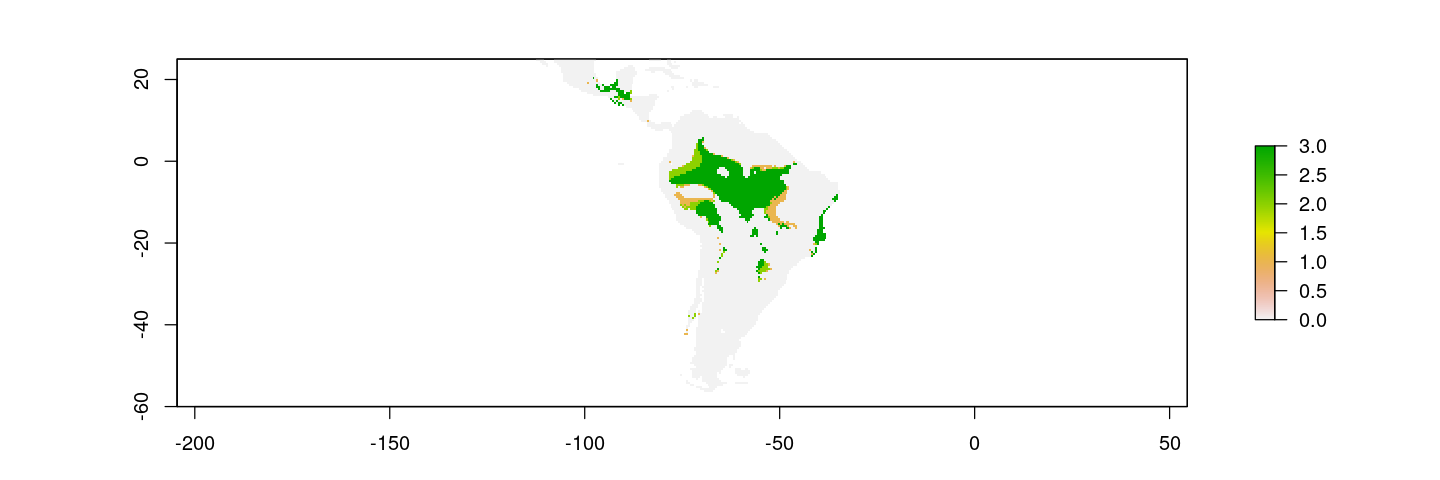

In [162]:
plot(pMat)

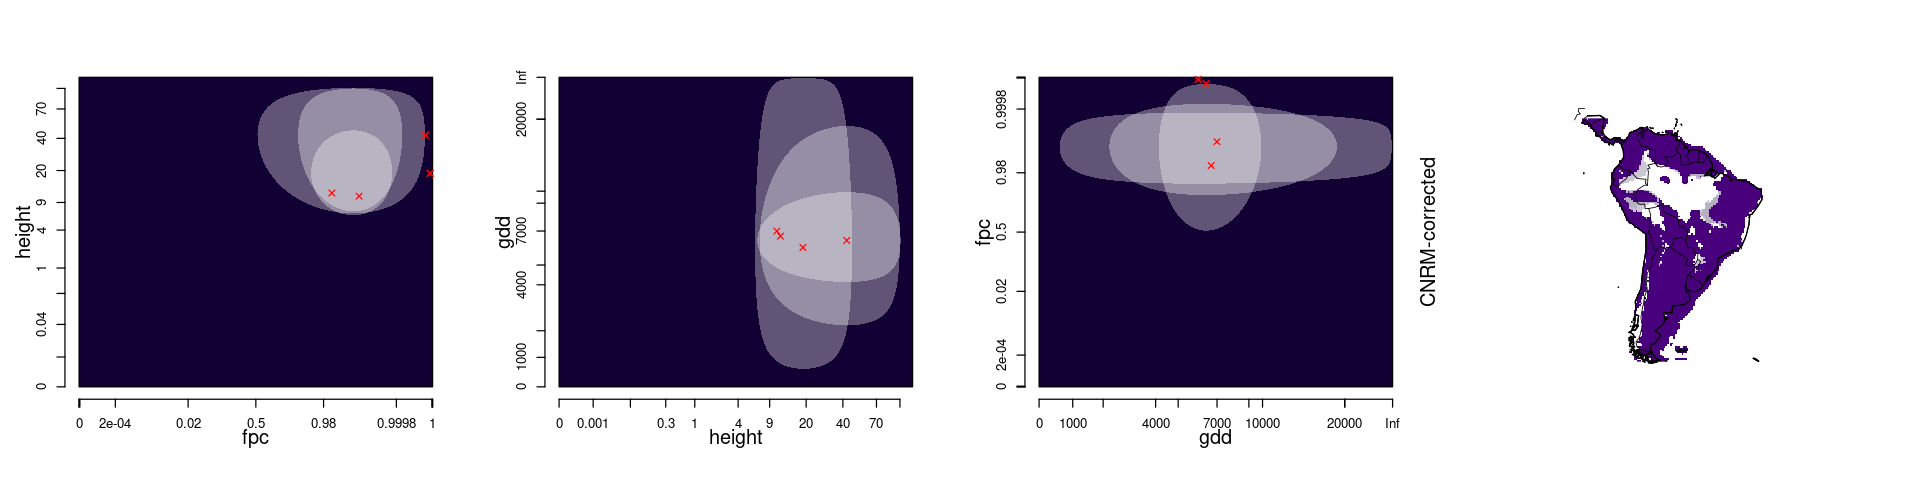

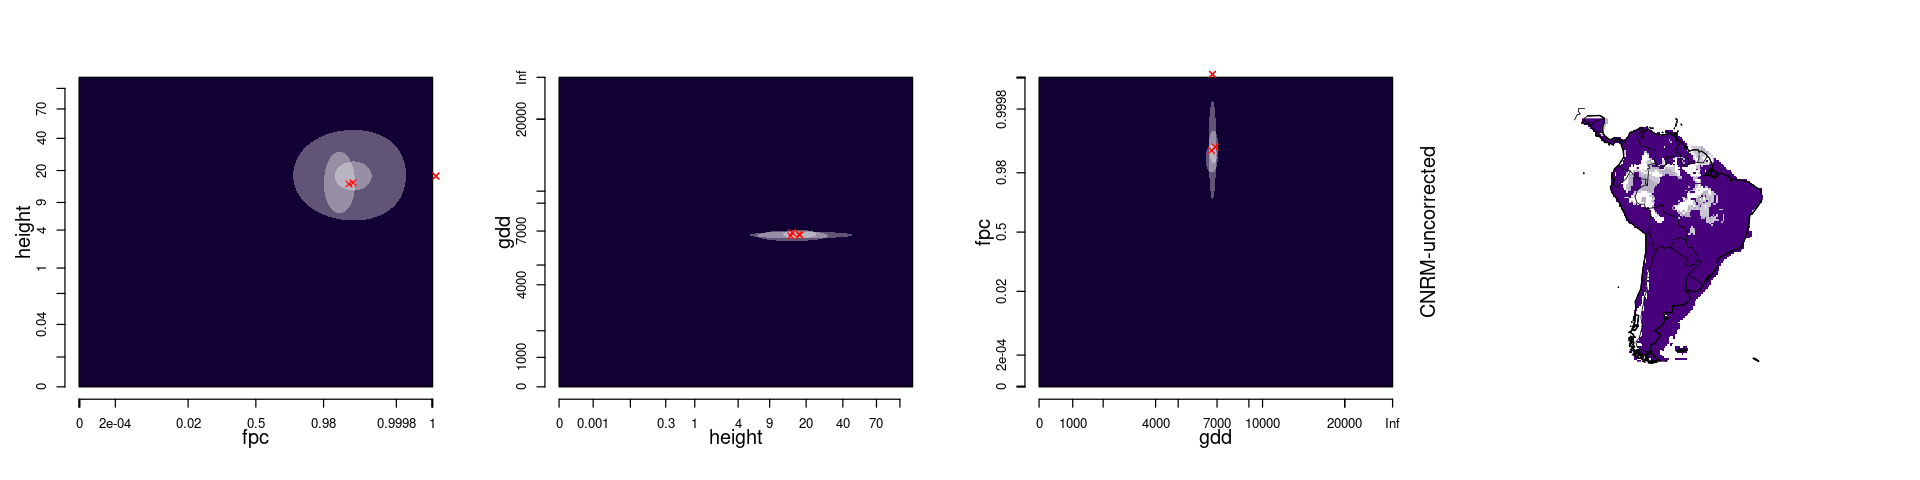

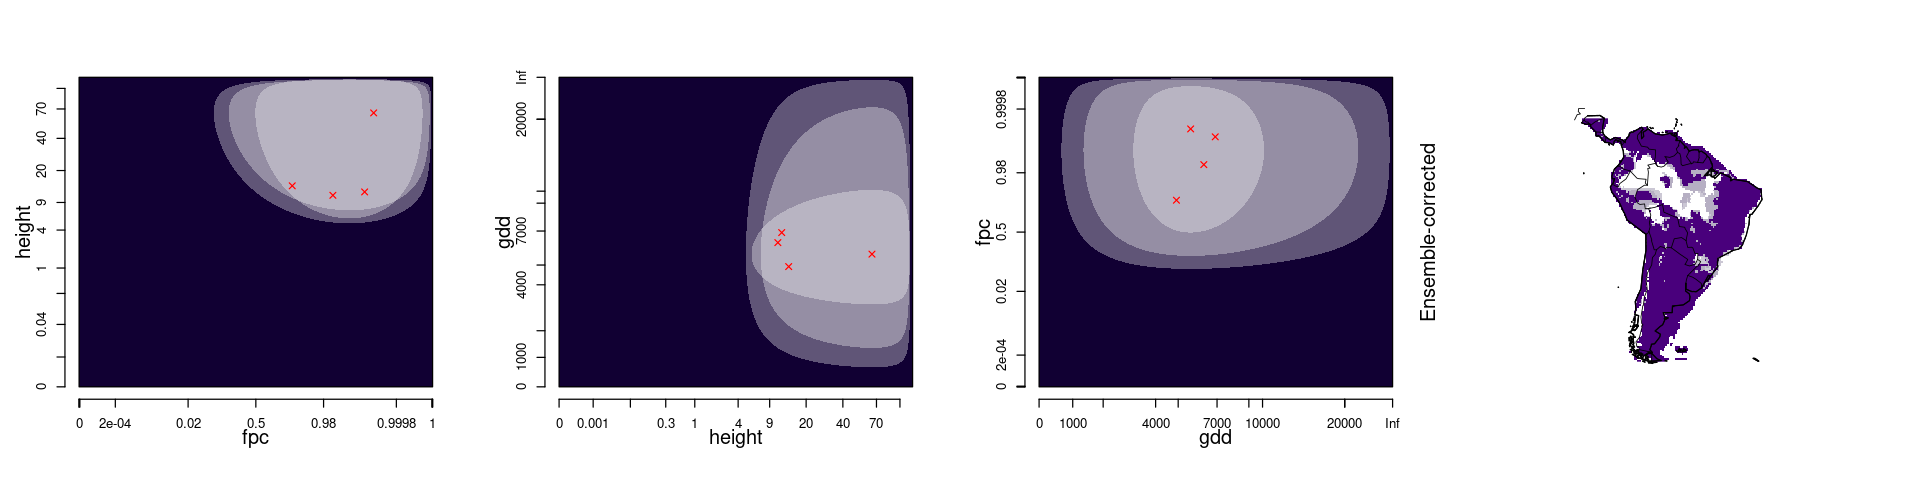

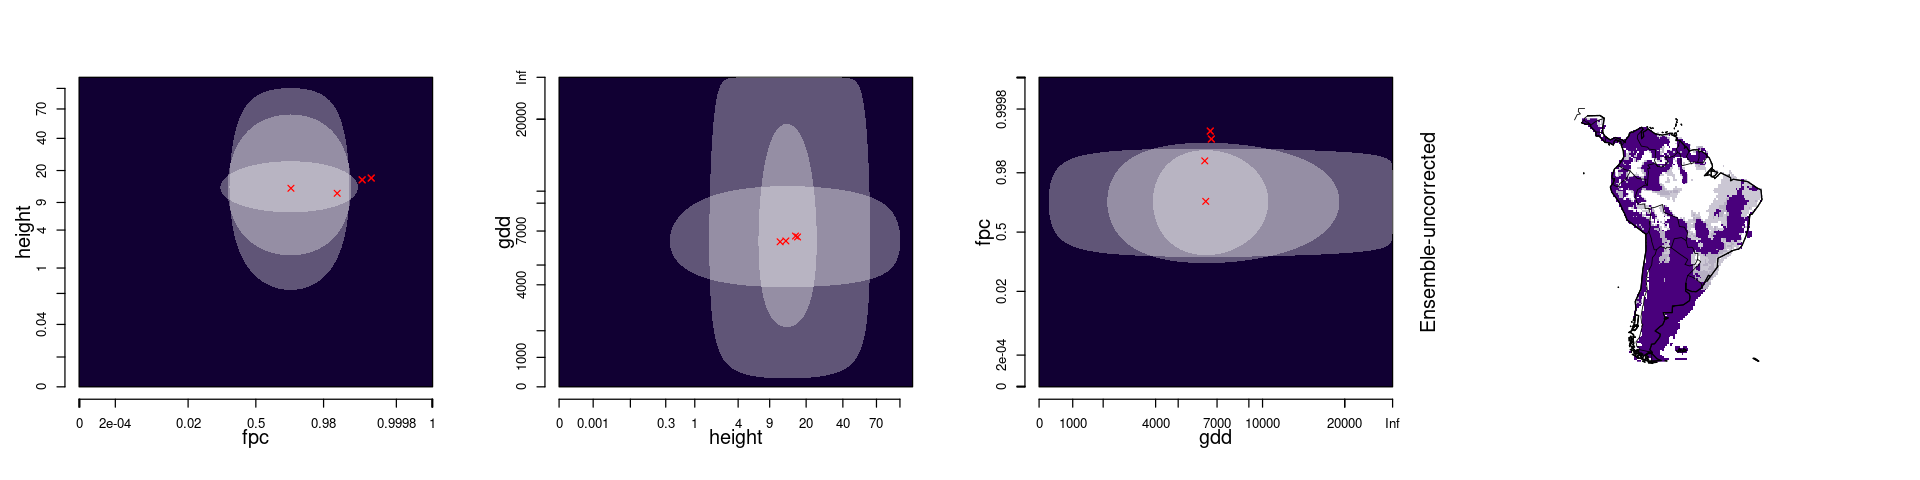

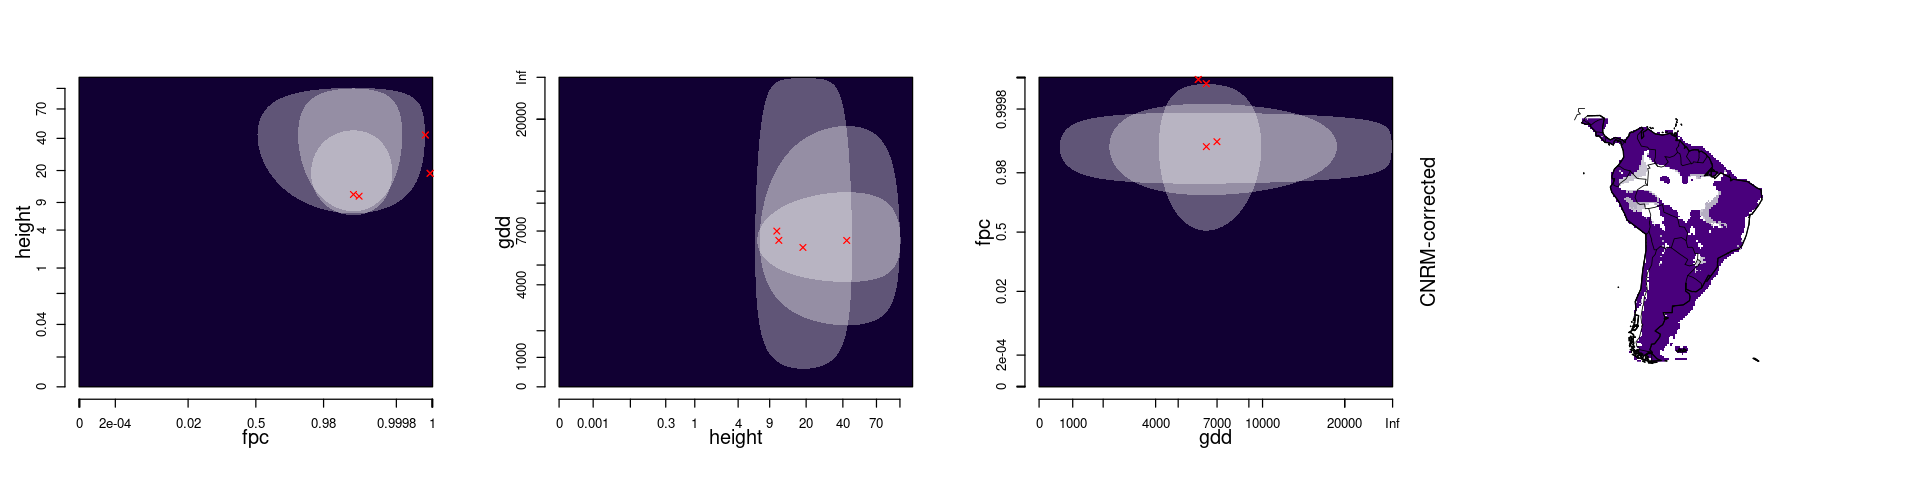

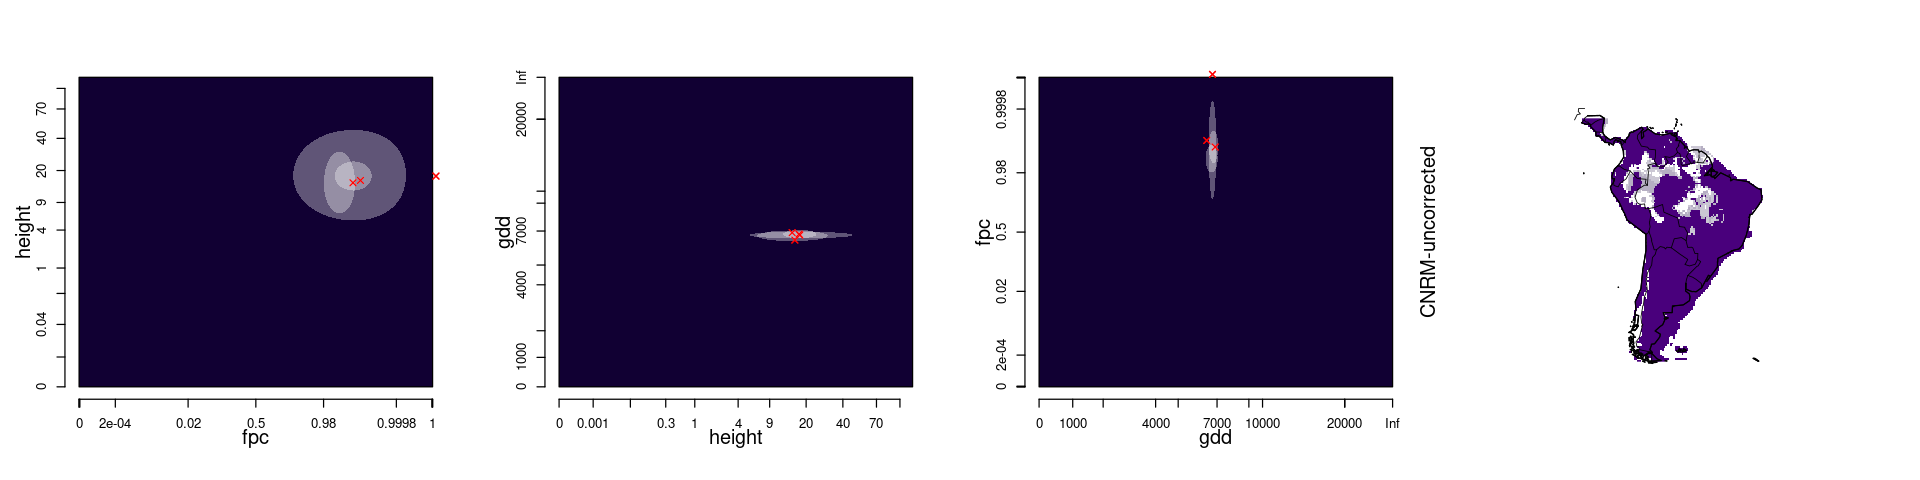

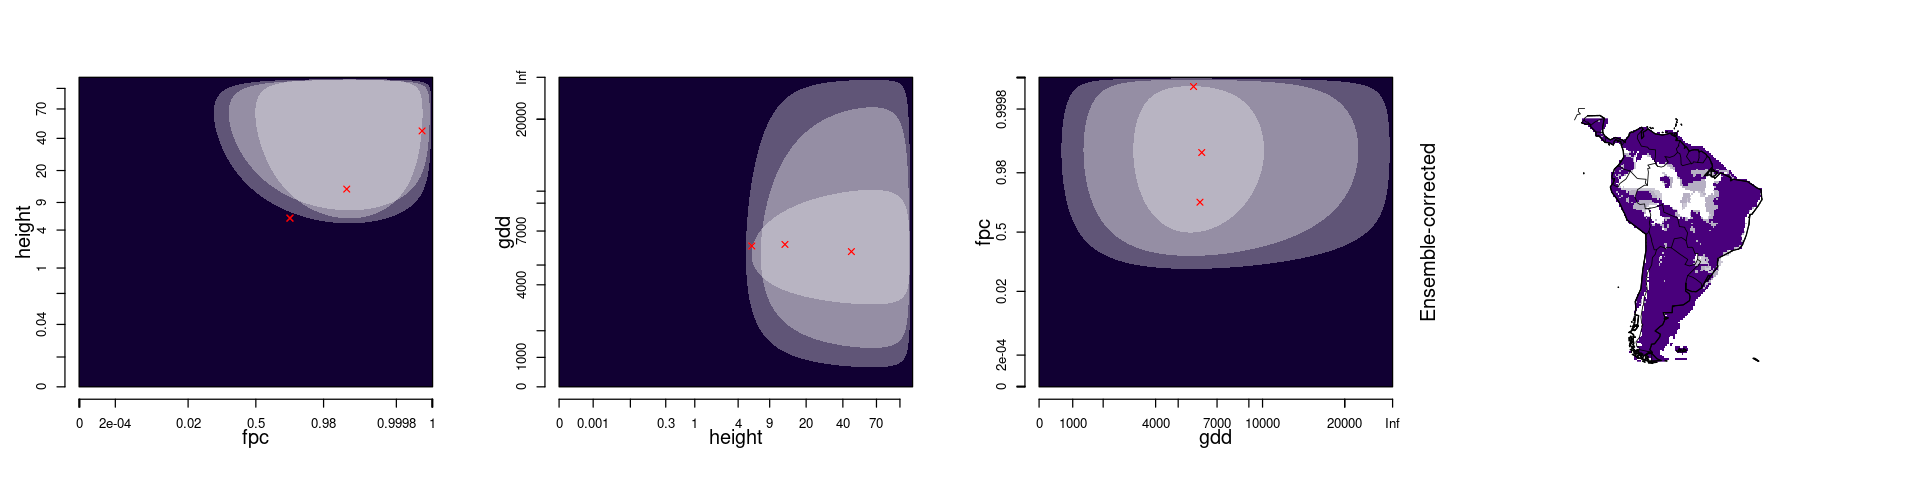

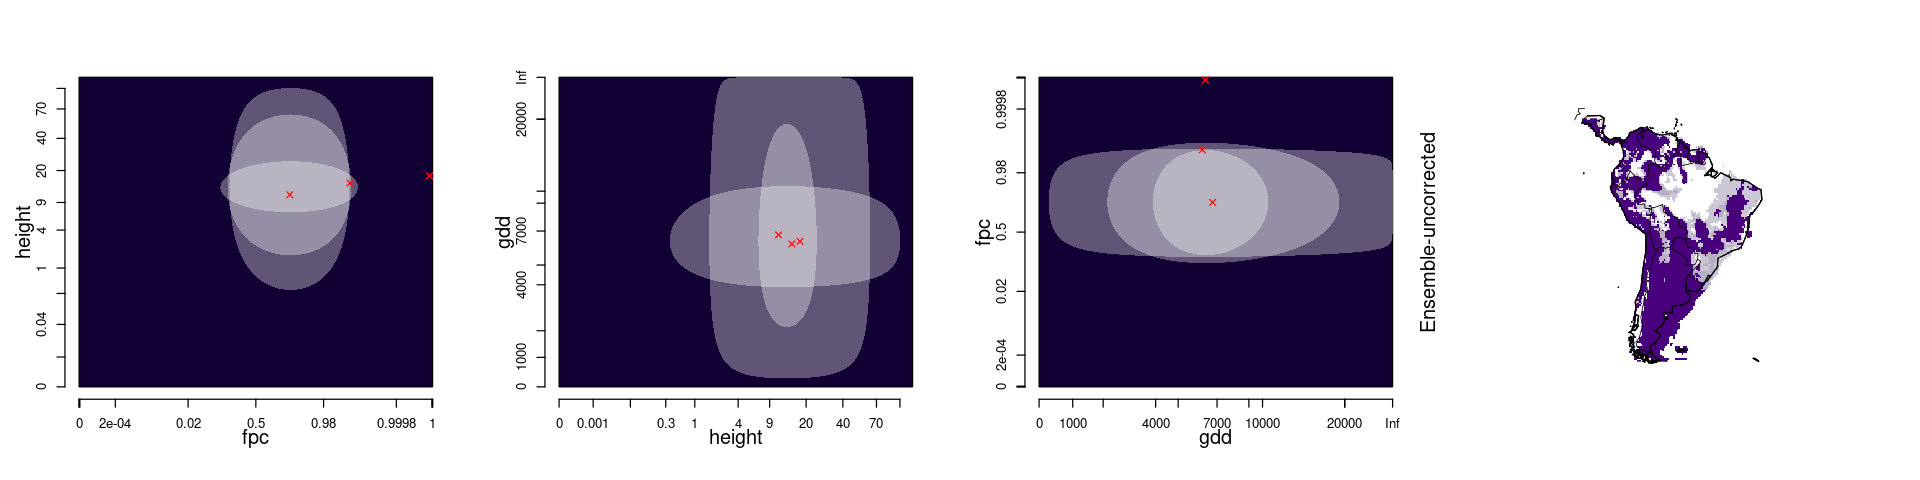

Warning message in mapply(plotModel, outsF, models):
"longer argument not a multiple of length of shorter"


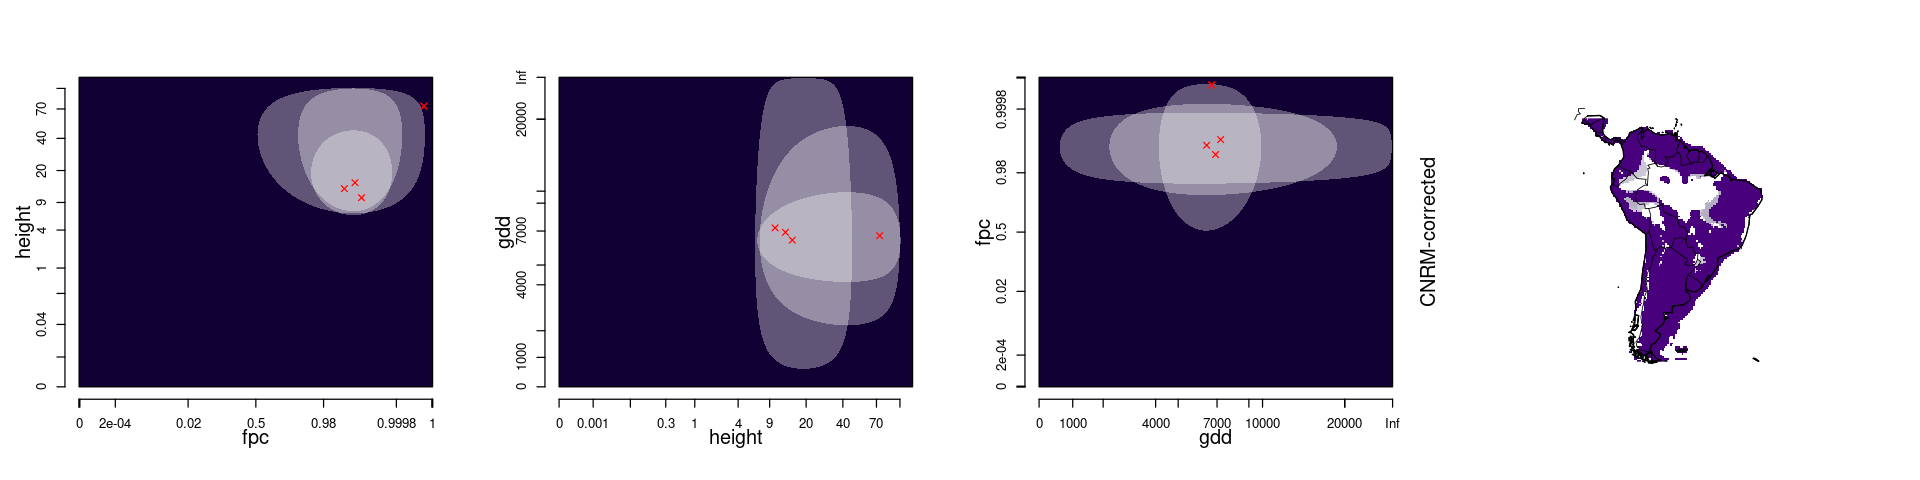

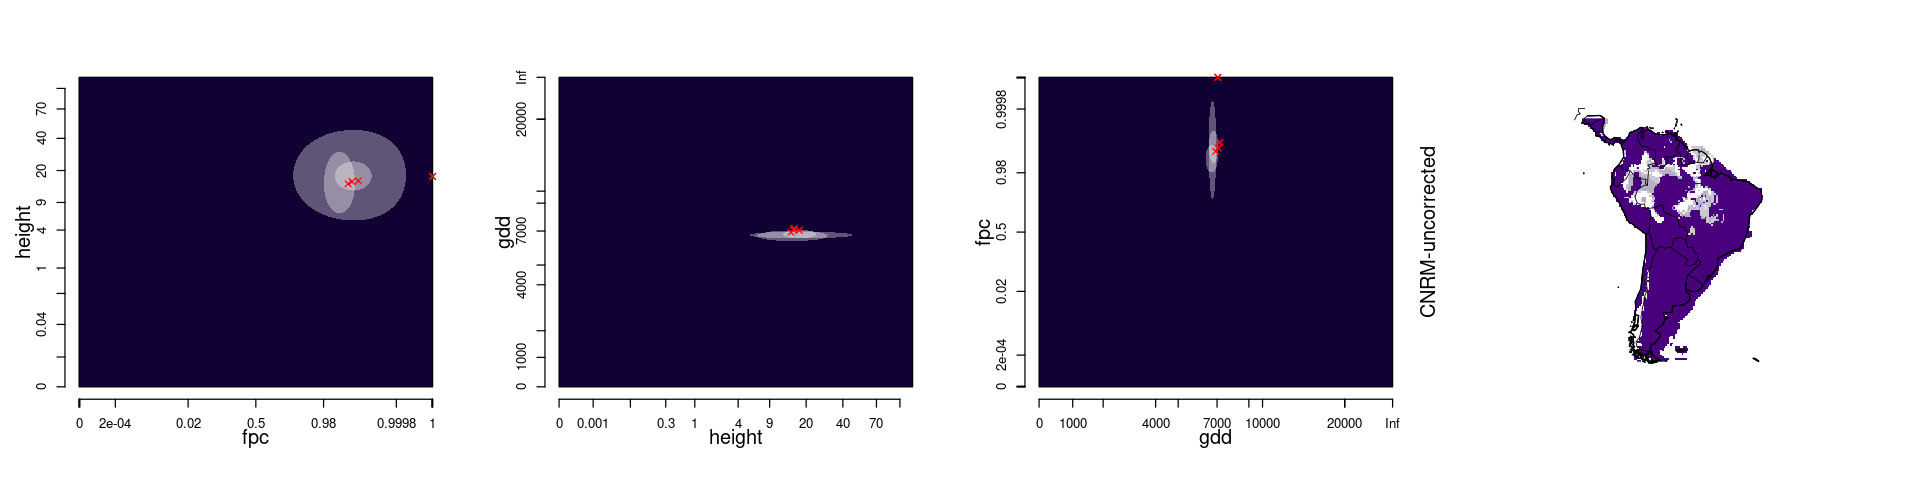

In [169]:
x = seq(-1, 1, 0.001)
y = sqrt(1-x^2)
x = c(x, rev(x)); y = c(y, -rev(y))


plotNichProb <- function(i, j, out) {
    
    centres = out[[2]]
    out = out[[1]]
    xc = ptranss[[i]](centres[[i]]); yc = ptranss[[j]](centres[[j]])
    
    plot(xc, yc, xlim = c(0,1), ylim = c(0,1), type = 'n', axes = FALSE, xlab = '', ylab = '')
    addAxis(i, 1)
    addAxis(j, 2)
    mtext(vars[i], side = 1, line = 2)
    mtext(vars[j], side = 2, line = 2)
    polygon(c(0, 1, 1, 0), c(0, 0, 1, 1), col = '#110033')
    
    addPoly <- function(fail, col, nc) {
        info = fail[[1]]

        shiftScale <- function(x, i){
            #x = logit(x)
            x = (x*diff(info[[i]])/2 + mean(info[[i]]))
            x = ptranss[[i]](itranss[[i]](x))
        }
        xt = shiftScale(x, i); yt = shiftScale(y, j)
        #browser()
        #xt = ptranss[[i]](xt); yt = ptranss[[i]](yt)
        polygon(xt, yt, col = make.transparent(col, min(0.99, 1-1/nc)), border = NA)
    }
    
    addPolys <- function(id, col) {
        con = out[sapply(out, function(i) i[[2]] == id)]                
        lapply(con, addPoly, col, length(con))
    }
    #addPolys(0, 'white')#'#110033')
    #addPolys(2, '#FF0000')
    points(xc, yc, pch = 4, col = 'red')
    addPolys(3, 'white') 
    points(xc, yc, pch = 4, col = 'red')
}
                         
plotNiches <- function(out, ..., model, experiment)   {   
    options(repr.plot.width=16, repr.plot.height=4)
    par(mfrow = c(1, 4))
    nn = plotNichProb(1, 2, out, ...)
    nn = plotNichProb(2, 3, out, ...)
    nn = plotNichProb(3, 1, out, ...)
    mtext(side = 4, paste0(model, '-', experiment), line = 1, xpd = TRUE)
                         
    pMat = out[[3]][[1]]
    pMat[!is.na(pMat)] = 0
    
    niches = out[[1]][sapply(out[[1]], function(i) i[2] == 3)]

    for (niche in niches)
        pMat = pMat + !is.na(niche[[4]])
    pMat = pMat / length(niches)  
    mar = par("mar"); par(mar = rep(0,4))             
    plot_raster_from_raster(pMat, x_range = c(-90, -30), y_range = c(-55, 15), cols = c('#110033', 'white'), 
                       limits = c(0.01, 0.1, 0.2, 0.5, 0.8, 0.9, 0.9), quick = TRUE,
                       add_legend = FALSE, e = NULL)
    par(mar = mar)
}
library(maps)
plotModel <- function(outs, model)
    mapply(plotNiches, outs, experiment = experiments, MoreArgs = list(model = model))
    
                         
nn = mapply(plotModel, outsF, models)
#outss[[1]][[1]][[1]]   
                         

In [ ]:
nn = mapply(plotModel, outsS, models)

In [ ]:
findRefugiaNiche <- function(out) {
    nichMat = out[[1]][[1]][[3]]
    #nichMat[] = 0
    for (mt in out[[1]]) 
        if (mt[[2]] == 3) nichMat = nichMat + 1-mt[[3]]
    nichMat[allDmat == 0] = NaN
    return(nichMat/sum(nichMat, na.rm = TRUE))
}

In [ ]:
nichesF = lapply(outsF, lapply, findRefugiaNiche)
nichesS = lapply(outsS, lapply, findRefugiaNiche)


In [19]:
findOutsideRefugia <- function(specDmat, nichMat) sum(sqrt(specDmat *nichMat), na.rm = TRUE)
nicheAssign <- function(...) sapply(specDmatNorm, findOutsideRefugia, ...)

nicheOLf = lapply(nichesF, lapply, nicheAssign )
nicheOLs = lapply(nichesS, lapply, nicheAssign )
nicheOLf[[1]][[1]]

Ammodramus humeralis           Dendroplex picus 
                0.49959547                 0.27803005 
            Dixiphia pipra           Elaenia cristata 
                0.05922946                 0.07589140 
                   Emb.her        Euphonia chlorotica 
                0.08578276                 0.08552162 
         Formicarius colma           Formicivora rufa 
                0.07192882                 0.05283027 
       Lipaugus vociferans               Piaya cayana 
                0.04698454                 0.11148897 
Piaya.cayana.specimens.onl         Sporophila plumbea 
                0.05532090                 0.07160000 
    Tachyphonus phoenicius 
                0.02926881

In [20]:
sapply(nicheOLf, function(i) round(i[[1]]*100,2))

,CNRM,Ensemble,FGOALS,HAD,MIROC
Ammodramus humeralis,49.96,31.34,49.26,48.28,46.95
Dendroplex picus,27.80,13.96,26.94,27.39,24.74
Dixiphia pipra,5.92,3.74,5.86,5.63,5.65
Elaenia cristata,7.59,4.13,7.47,7.22,7.22
Emb.her,8.58,6.16,8.52,8.13,8.50
Euphonia chlorotica,8.55,6.07,8.52,8.16,8.47
Formicarius colma,7.19,5.11,7.07,6.80,7.03
Formicivora rufa,5.28,3.17,5.18,5.06,5.15
Lipaugus vociferans,4.70,2.58,4.58,4.46,4.25
Piaya cayana,11.15,7.56,11.10,10.57,11.06


In [459]:
sapply(nicheOLs, function(i) round(i[[1]]*100,2))

,CNRM,Ensemble,FGOALS,HAD,MIROC
Ammodramus humeralis,50.38,51.01,51.07,51.07,51.30
Dendroplex picus,28.33,29.51,29.73,29.88,30.07
Dixiphia pipra,6.11,6.11,6.04,6.08,6.06
Elaenia cristata,7.76,7.78,7.69,7.74,7.71
Emb.her,8.86,8.69,8.59,8.65,8.61
Euphonia chlorotica,8.88,8.70,8.60,8.66,8.62
Formicarius colma,7.39,7.31,7.23,7.28,7.24
Formicivora rufa,5.55,5.46,5.40,5.44,5.42
Lipaugus vociferans,4.75,4.88,4.83,4.86,4.84
Piaya cayana,11.57,11.36,11.24,11.31,11.26
